In [1]:
import pandas as pd
import numpy as np
from functools import partial
import os
import random

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GroupShuffleSplit

from dataset import split_val, split_test
from trainer import train_AgeVae, test_AgeVae
from model import VAEAge, TwoLayerNetwork

In [2]:
data = pd.read_csv("./Data/Aging_data_scaled_combined_orthologs.csv")
data.head()
datawNAN = data[data['Species'] == "Mouse"].fillna(0)

In [3]:
datawNAN, y, group = np.array(datawNAN.select_dtypes(include=['float64']).iloc[:, :-1].values), np.array(datawNAN.select_dtypes(include=['float64']).iloc[:, -2].values), \
                      np.array(datawNAN["GEO"].values)
print(y.shape, np.unique(group).shape)

(976,) (9,)


In [4]:
SEED = random.randint(0, 1000)
train, test = split_test(datawNAN, test_split = 0.1, SEED = SEED)
train, test = torch.Tensor(train), torch.Tensor(test)
y_train, y_test = split_test(y, test_split = 0.1, SEED = SEED)
group_train, group_test = split_test(group, test_split = 0.1, SEED = SEED)
print(train.shape, y_train.shape, np.unique(group_train).shape)

torch.Size([879, 15812]) (879,) (9,)


In [5]:
n_groups = 5
gss = GroupShuffleSplit(n_splits = n_groups, train_size=.9, random_state=42)
for train_idx, test_idx in gss.split(train, y_train, group_train):
  print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


| age_weight | batch_size | down_channels | hidden_size/0 | hidden_size/1 | l1_lambda   | l2_lambda   | latent_size | lr          | up_channels | loss    | accuracy   | training_iteration |
|------------|------------|---------------|---------------|---------------|-------------|-------------|-------------|-------------|-------------|---------|------------|--------------------|
|      1     |     20     |       3       |      256      |       4       |  1.0841e-05 | 0.000155484 |      5      | 0.000772848 |      3      | 1290.61 | -0.0558202 |         50         |
| 1          | 20         | 2             | 64            | 256           | 0.000502518 | 1.17864e-05 | 10          | 0.000112061 | 3           | 4888.94 | -44.8302   | 1                  |
| 1          | 10         | 2             | 32            | 256           | 0.000997956 | 0.000649128 | 5           | 0.000820122 | 2           | 3284.94 | -40.0566   | 2                  |
| 10         | 5          | 2             | 32            | 128           | 5.06699e-05 | 0.00040606  | 50          | 0.000496784 | 2           | 2589.92 | -22.2472   | 4                  |
| 10         | 5          | 3             | 256           | 32            | 0.000396552 | 0.00013128  | 10          | 0.00765679  | 2           | 4858    | -0.702724  | 1                  |
| 10         | 20         | 2             | 4             | 8             | 0.000413962 | 0.000614153 | 50          | 0.00169343  | 3           | 1654.96 | -0.0991634 | 16                 |
| 10         | 20         | 2             | 32            | 256           | 0.000110339 | 8.49398e-05 | 10          | 0.000360644 | 3           | 830.974 | -2.54307   | 50                 |
| 10         | 20         | 3             | 32            | 256           | 0.000155275 | 3.35245e-05 | 5           | 0.000683221 | 2           | 4964.49 | -35.366    | 1                  |
| 1          | 20         | 2             | 16            | 4             | 0.000489314 | 0.000225789 | 50          | 0.00976554  | 3           | 22123.1 | -15.932    | 1                  |

**Tune best result:**
{'l1_lambda': 0.00011033857771297112, 'l2_lambda': 8.493979873993043e-05, 'lr': 0.00036064363807128386, 'hidden_size': [32, 256], 'latent_siz|e': 10, 'up_channels': 3, 'down_channels': 2, 'age_weight': 10, 'batch_size': 20}

In [7]:
batch_size = 20
l1_lambda, l2_lambda = 0.00011033857771297112, 8.493979873993043e-05
input_size = train.shape[1] - 1
latent_size = 10
down_channels, up_channels = 2, 3
hidden_size = [32, 256]
lr = 0.00036064363807128386
epochs = 1000
age_weight = 10

In [8]:
all_history = [(0, 0) for epoch in range(epochs)]
all_history_val = [(0, 0) for epoch in range(epochs)]
for train_idx, test_idx in gss.split(train, y_train, group_train):
    train_idx, test_idx = torch.LongTensor(train_idx), torch.LongTensor(test_idx)
    train = torch.Tensor(train)
    print(train_idx.shape, test_idx.shape, train.shape)
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(test_idx)
    train_loader = DataLoader(train, batch_size=batch_size,
                                               sampler=train_sampler)
    val_loader = DataLoader(train, batch_size=batch_size,
                                             sampler=val_sampler)
    AgeModel = TwoLayerNetwork(latent_size, l1_lambda, l2_lambda, hidden_size)
    vae = VAEAge(input_size, AgeModel, latent_size, down_channels, up_channels)
    vae_optim = Adam(vae.parameters(), lr)
    metrics_history, metrics_history_val = train_AgeVae(vae, train_loader, val_loader, batch_size, epochs, vae_optim, device = device, age_weight = age_weight)
    all_history = [(x[0]+y[0], x[1]+y[1]) for x,y in zip(metrics_history, all_history)]
    all_history_val = [(x[0]+y[0], x[1]+y[1]) for x,y in zip(metrics_history_val, all_history_val)]
metrics_history = [(x[0]/n_groups, x[1]/n_groups) for x in all_history]
metrics_history_val = [(x[0]/n_groups, x[1]/n_groups) for x in all_history_val]

torch.Size([871]) torch.Size([8]) torch.Size([879, 15812])
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4798, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5417, device='cuda:0') 20 tensor(1.0472, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 1 | Age r2: -45.26318350503611 | Age loss: 1.040681933247766 |Age reg: 0.15469272088172825 | MSE loss: 5367.392481604288 | R2: 0.15237602799437766 | KLD loss: 22.38247514048288
Epoch 1 | Age r2 val: -23.040979385375977 | Age loss val: 0.9772270321846008 | MSE loss val: 9855.08984375 | R2 val: -303.6019287109375 | KLD loss val: 19.178936004638672
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.7710, de

Epoch 12 | Age r2: -27.548710357311162 | Age loss: 0.8329405188560486 |Age reg: 0.14117942473223044 | MSE loss: 1057.4389534883721 | R2: 0.8331354551537092 | KLD loss: 54.918282531028574
Epoch 12 | Age r2 val: -16.843505859375 | Age loss val: 0.8418980240821838 | MSE loss val: 10716.767578125 | R2 val: -330.2347717285156 | KLD loss val: 40.97642517089844
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2268, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.7509, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 13 | Age r2: -26.229207127593284 | Age loss: 0.8155665314474771 |Age reg: 0.1400786908560021 | MSE loss: 1052.447152071221 | R2: 0.8340651351352071 | KLD loss: 55.25637595598088
Epoch 13 | Age r2 val: -19.10820960998535 | Age loss val: 0.8937295079231262 | MSE loss val: 10846.

Epoch 24 | Age r2: -15.033563436463822 | Age loss: 0.6242481927539028 |Age reg: 0.12949560166791427 | MSE loss: 940.8775450240734 | R2: 0.8503227511117625 | KLD loss: 58.324634285860284
Epoch 24 | Age r2 val: -13.38308048248291 | Age loss val: 0.7558669447898865 | MSE loss val: 10422.24609375 | R2 val: -321.1316833496094 | KLD loss val: 44.99181365966797
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.2170, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.6587, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 25 | Age r2: -14.384966406711312 | Age loss: 0.6130694428155589 |Age reg: 0.12865181891031044 | MSE loss: 936.3551138944404 | R2: 0.8511989698853604 | KLD loss: 58.67367278697879
Epoch 25 | Age r2 val: -11.867258071899414 | Age loss val: 0.714928150177002 | MSE loss val: 1064

Epoch 36 | Age r2: -7.1418339319007345 | Age loss: 0.4454893643079802 |Age reg: 0.11984660649715467 | MSE loss: 884.221072174782 | R2: 0.8591046028358992 | KLD loss: 59.99727834657181
Epoch 36 | Age r2 val: -6.917891502380371 | Age loss val: 0.5608208775520325 | MSE loss val: 11097.19921875 | R2 val: -341.99322509765625 | KLD loss val: 46.71498107910156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.0895, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.4122, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 37 | Age r2: -6.533372707145158 | Age loss: 0.42770146838454315 |Age reg: 0.11919820533935414 | MSE loss: 847.2737838390261 | R2: 0.8657238719075225 | KLD loss: 60.05765515704488
Epoch 37 | Age r2 val: -7.087642669677734 | Age loss val: 0.5668007135391235 | MSE loss val: 10956

Epoch 48 | Age r2: -2.3487503805825876 | Age loss: 0.28060685548671455 |Age reg: 0.1114782701398051 | MSE loss: 816.1481380019077 | R2: 0.8698865785155185 | KLD loss: 60.04409825524618
Epoch 48 | Age r2 val: -3.4375967979431152 | Age loss val: 0.4198491871356964 | MSE loss val: 10924.1328125 | R2 val: -336.64404296875 | KLD loss val: 47.53993225097656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0745, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.3102, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 49 | Age r2: -2.1377864382987797 | Age loss: 0.27119135475435924 |Age reg: 0.110811224857042 | MSE loss: 806.9374489007994 | R2: 0.8707632131354753 | KLD loss: 59.97649543229924
Epoch 49 | Age r2 val: -3.271557331085205 | Age loss val: 0.41191965341567993 | MSE loss val: 11109.87

Epoch 60 | Age r2: -0.3429713387821996 | Age loss: 0.180466731966928 |Age reg: 0.10392018407583237 | MSE loss: 747.2568146461664 | R2: 0.8810906812202098 | KLD loss: 59.18103000729583
Epoch 60 | Age r2 val: -1.051825761795044 | Age loss val: 0.28548917174339294 | MSE loss val: 11157.9345703125 | R2 val: -343.87042236328125 | KLD loss val: 47.56280517578125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2453, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1810, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 61 | Age r2: -0.21887831078019254 | Age loss: 0.1710872528857963 |Age reg: 0.10327106644940931 | MSE loss: 715.8032183979833 | R2: 0.8860023673190627 | KLD loss: 59.38207998941111
Epoch 61 | Age r2 val: -0.8104639053344727 | Age loss val: 0.26817256212234497 | MSE loss val: 

Epoch 72 | Age r2: 0.04967793752980787 | Age loss: 0.15506025819584382 |Age reg: 0.0963352490649667 | MSE loss: 709.4876425099927 | R2: 0.8874668894812118 | KLD loss: 59.69791660752407
Epoch 72 | Age r2 val: -0.20433223247528076 | Age loss val: 0.21872204542160034 | MSE loss val: 10938.740234375 | R2 val: -337.0954895019531 | KLD loss val: 48.420257568359375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2334, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1859, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 73 | Age r2: 0.053019333717434905 | Age loss: 0.15408127980176792 |Age reg: 0.09568221589853597 | MSE loss: 728.091713838799 | R2: 0.8830152112384175 | KLD loss: 59.53434416305187
Epoch 73 | Age r2 val: -0.2702789306640625 | Age loss val: 0.22463060915470123 | MSE loss val

Epoch 84 | Age r2: 0.06204071155814237 | Age loss: 0.15516493001649545 |Age reg: 0.08866390707187874 | MSE loss: 692.3552061568859 | R2: 0.8901587641516397 | KLD loss: 59.185375302336936
Epoch 84 | Age r2 val: -0.09610855579376221 | Age loss val: 0.20866335928440094 | MSE loss val: 10943.9521484375 | R2 val: -337.256591796875 | KLD loss val: 48.083309173583984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4703, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1042, device='cuda:0') 20 tensor(0.1507, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 85 | Age r2: 0.05838372679643853 | Age loss: 0.1541509889932566 |Age reg: 0.08799028777798941 | MSE loss: 646.9515387956486 | R2: 0.8975475014642228 | KLD loss: 59.4822137522143
Epoch 85 | Age r2 val: -0.1597449779510498 | Age loss val: 0.21463505923748016 | MSE loss val

Epoch 96 | Age r2: 0.061384992544041124 | Age loss: 0.15444376562223877 |Age reg: 0.08120624773031057 | MSE loss: 646.8742654489917 | R2: 0.8963604333788849 | KLD loss: 58.33259777690089
Epoch 96 | Age r2 val: -0.20241403579711914 | Age loss val: 0.2185477912425995 | MSE loss val: 10720.751953125 | R2 val: -330.3579406738281 | KLD loss val: 48.41966247558594
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3871, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1580, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 97 | Age r2: 0.08951430403909018 | Age loss: 0.15127753085175225 |Age reg: 0.08053346012913903 | MSE loss: 634.0343684706577 | R2: 0.8995789123135943 | KLD loss: 58.531823624012084
Epoch 97 | Age r2 val: -0.19706940650939941 | Age loss val: 0.21806153655052185 | MSE loss v

Epoch 108 | Age r2: 0.10925298790599025 | Age loss: 0.15055937198705452 |Age reg: 0.07402065673539805 | MSE loss: 601.7689130916152 | R2: 0.904506758201954 | KLD loss: 58.39091402985329
Epoch 108 | Age r2 val: -0.08356189727783203 | Age loss val: 0.20746567845344543 | MSE loss val: 10737.564453125 | R2 val: -330.8775634765625 | KLD loss val: 48.40138244628906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2461, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1387, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 109 | Age r2: 0.11423793781635373 | Age loss: 0.14941545991703523 |Age reg: 0.07343936053126357 | MSE loss: 621.9503947413245 | R2: 0.9010293261949406 | KLD loss: 59.030407484187634
Epoch 109 | Age r2 val: -0.047229886054992676 | Age loss val: 0.20395784080028534 | MSE lo

Epoch 120 | Age r2: 0.05599200171093608 | Age loss: 0.15319100542123928 |Age reg: 0.06762898384138595 | MSE loss: 605.6030997342841 | R2: 0.9040285709292389 | KLD loss: 58.62276618425236
Epoch 120 | Age r2 val: -0.044017672538757324 | Age loss val: 0.203644797205925 | MSE loss val: 11136.8984375 | R2 val: -343.22021484375 | KLD loss val: 48.79796600341797
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2423, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1477, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 121 | Age r2: 0.08735037265821945 | Age loss: 0.1515747480267702 |Age reg: 0.067102090563885 | MSE loss: 599.2621034134266 | R2: 0.9046481501224429 | KLD loss: 59.06455186355946
Epoch 121 | Age r2 val: -0.006999492645263672 | Age loss val: 0.20000186562538147 | MSE loss val: 

Epoch 132 | Age r2: 0.13651295318159945 | Age loss: 0.14767710604639941 |Age reg: 0.062031449706748475 | MSE loss: 564.1441778138626 | R2: 0.9107632983562558 | KLD loss: 57.84300214190816
Epoch 132 | Age r2 val: -0.0746605396270752 | Age loss val: 0.206611767411232 | MSE loss val: 11082.2138671875 | R2 val: -341.530029296875 | KLD loss val: 47.903663635253906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2161, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1281, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 133 | Age r2: 0.1248846553092779 | Age loss: 0.14911247477975004 |Age reg: 0.061672198217968606 | MSE loss: 578.8520522006722 | R2: 0.9080333654270616 | KLD loss: 58.05414430485215
Epoch 133 | Age r2 val: -0.08359050750732422 | Age loss val: 0.2074684202671051 | MSE loss 

Epoch 144 | Age r2: 0.17260898407115494 | Age loss: 0.14405618625324826 |Age reg: 0.05762899866284326 | MSE loss: 572.3262754928234 | R2: 0.908895801666171 | KLD loss: 58.482532323792924
Epoch 144 | Age r2 val: -0.14937186241149902 | Age loss val: 0.21367302536964417 | MSE loss val: 11054.8447265625 | R2 val: -340.6841125488281 | KLD loss val: 49.287288665771484
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3502, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1275, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 145 | Age r2: 0.18747075213942416 | Age loss: 0.1421929701816204 |Age reg: 0.05720586589602537 | MSE loss: 546.6264371650163 | R2: 0.9133166116337443 | KLD loss: 58.80410411746003
Epoch 145 | Age r2 val: -0.11037325859069824 | Age loss val: 0.21001672744750977 | MSE lo

Epoch 156 | Age r2: 0.1734792423802753 | Age loss: 0.1421607720643975 |Age reg: 0.053490687161684036 | MSE loss: 532.3278049202853 | R2: 0.9156073484309885 | KLD loss: 57.12954951441565
Epoch 156 | Age r2 val: -0.2330394983291626 | Age loss val: 0.2213134914636612 | MSE loss val: 10747.64453125 | R2 val: -331.1891174316406 | KLD loss val: 47.762733459472656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2079, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1153, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 157 | Age r2: 0.21200249915899233 | Age loss: 0.14128360897302628 |Age reg: 0.05315246805548668 | MSE loss: 531.08418096498 | R2: 0.9156554216562316 | KLD loss: 56.914421613826306
Epoch 157 | Age r2 val: -0.16717875003814697 | Age loss val: 0.2153218388557434 | MSE loss val

Epoch 168 | Age r2: 0.25756977741108383 | Age loss: 0.13621713671573374 |Age reg: 0.05016176480540009 | MSE loss: 542.6267962788427 | R2: 0.9135618722716043 | KLD loss: 57.563516395036565
Epoch 168 | Age r2 val: -0.16900241374969482 | Age loss val: 0.21548999845981598 | MSE loss val: 11149.1064453125 | R2 val: -343.5975036621094 | KLD loss val: 48.105201721191406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3034, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1395, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 169 | Age r2: 0.24566181038701257 | Age loss: 0.13795870871737945 |Age reg: 0.049894712518814 | MSE loss: 529.0373932594476 | R2: 0.916090800318607 | KLD loss: 57.25240822725518
Epoch 169 | Age r2 val: -0.1579732894897461 | Age loss val: 0.21447104215621948 | MSE loss

Epoch 180 | Age r2: 0.18763832158820573 | Age loss: 0.13838924190332724 |Age reg: 0.04735952537766723 | MSE loss: 511.92448105922966 | R2: 0.9189628487409547 | KLD loss: 57.83510979940725
Epoch 180 | Age r2 val: -0.35942256450653076 | Age loss val: 0.23237887024879456 | MSE loss val: 10500.498046875 | R2 val: -323.5502624511719 | KLD loss val: 48.80595397949219
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3611, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1143, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 181 | Age r2: 0.2413729748060537 | Age loss: 0.1382014248953309 |Age reg: 0.047172648182442024 | MSE loss: 509.73803923850835 | R2: 0.9190052415049353 | KLD loss: 57.348419100739235
Epoch 181 | Age r2 val: -0.2633860111236572 | Age loss val: 0.2240203320980072 | MSE los

Epoch 192 | Age r2: 0.28923286255015884 | Age loss: 0.1333094256561856 |Age reg: 0.04502879403704821 | MSE loss: 514.050757829533 | R2: 0.9177906180537024 | KLD loss: 57.59903060558231
Epoch 192 | Age r2 val: -0.15658605098724365 | Age loss val: 0.21434253454208374 | MSE loss val: 10574.9453125 | R2 val: -325.8512878417969 | KLD loss val: 49.332828521728516
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5340, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1413, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 193 | Age r2: 0.2604309167972831 | Age loss: 0.1367326980066854 |Age reg: 0.04484389150558516 | MSE loss: 504.157577869504 | R2: 0.9197546243667603 | KLD loss: 58.43975812335347
Epoch 193 | Age r2 val: -0.22585761547088623 | Age loss val: 0.2206680327653885 | MSE loss val: 

Epoch 204 | Age r2: 0.2860469457715057 | Age loss: 0.1336962014090183 |Age reg: 0.042982455256373384 | MSE loss: 495.55562289925507 | R2: 0.9212609418602877 | KLD loss: 56.96239923876385
Epoch 204 | Age r2 val: -0.1679011583328247 | Age loss val: 0.2153884619474411 | MSE loss val: 10541.951171875 | R2 val: -324.83154296875 | KLD loss val: 48.83832931518555
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4001, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1109, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 205 | Age r2: 0.2989750948063163 | Age loss: 0.1314544336393822 |Age reg: 0.04281321887013524 | MSE loss: 492.359452358512 | R2: 0.9220148629920427 | KLD loss: 57.05745856706486
Epoch 205 | Age r2 val: -0.14079225063323975 | Age loss val: 0.21287402510643005 | MSE loss val: 

Epoch 216 | Age r2: 0.32630895597990167 | Age loss: 0.1283090523509092 |Age reg: 0.041113082232863404 | MSE loss: 466.8020416969477 | R2: 0.9263599833776784 | KLD loss: 57.3126835490382
Epoch 216 | Age r2 val: -0.2566477060317993 | Age loss val: 0.2234221249818802 | MSE loss val: 10508.62109375 | R2 val: -323.8014221191406 | KLD loss val: 48.84836196899414
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2522, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1397, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 217 | Age r2: 0.3058750088824782 | Age loss: 0.1318127504268358 |Age reg: 0.04094608058763105 | MSE loss: 492.3718545603198 | R2: 0.9213413069414538 | KLD loss: 57.17871714747229
Epoch 217 | Age r2 val: -0.24031102657318115 | Age loss val: 0.22196510434150696 | MSE loss val:

Epoch 228 | Age r2: 0.27924413736476456 | Age loss: 0.12945681325224942 |Age reg: 0.03945534962207772 | MSE loss: 484.734529717024 | R2: 0.9227211239726044 | KLD loss: 56.926525648250134
Epoch 228 | Age r2 val: -0.22346413135528564 | Age loss val: 0.22045250236988068 | MSE loss val: 10408.712890625 | R2 val: -320.7133483886719 | KLD loss val: 49.80139923095703
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4403, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5417, device='cuda:0') 20 tensor(0.1135, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 229 | Age r2: 0.3559363997259805 | Age loss: 0.12606396907290748 |Age reg: 0.03931694469133089 | MSE loss: 475.00105746956757 | R2: 0.9246848987978559 | KLD loss: 57.36164758371752
Epoch 229 | Age r2 val: -0.17973840236663818 | Age loss val: 0.21647724509239197 | MSE los

Epoch 240 | Age r2: 0.3346919666889102 | Age loss: 0.12867502331040626 |Age reg: 0.03795269590824149 | MSE loss: 473.6891692405523 | R2: 0.9245606744012167 | KLD loss: 56.429666474808094
Epoch 240 | Age r2 val: -0.26700639724731445 | Age loss val: 0.22434107959270477 | MSE loss val: 10386.7158203125 | R2 val: -320.03350830078125 | KLD loss val: 49.24810028076172
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2331, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1164, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 241 | Age r2: 0.3170036715130473 | Age loss: 0.12853754363780798 |Age reg: 0.037826603841643 | MSE loss: 468.11399167083033 | R2: 0.9257373851399089 | KLD loss: 55.818291508874225
Epoch 241 | Age r2 val: -0.2680165767669678 | Age loss val: 0.22443048655986786 | MSE los

Epoch 252 | Age r2: 0.3447154344514359 | Age loss: 0.12563807378674663 |Age reg: 0.03657961298906526 | MSE loss: 460.8798459075218 | R2: 0.9272337597469951 | KLD loss: 55.94904451592024
Epoch 252 | Age r2 val: -0.3383471965789795 | Age loss val: 0.23057052493095398 | MSE loss val: 10333.2080078125 | R2 val: -318.37969970703125 | KLD loss val: 49.073184967041016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3938, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1226, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 253 | Age r2: 0.29731149728908096 | Age loss: 0.1259974755866583 |Age reg: 0.036470813720032226 | MSE loss: 452.3933197731196 | R2: 0.9282235919043075 | KLD loss: 55.64598713364712
Epoch 253 | Age r2 val: -0.4011877775192261 | Age loss val: 0.23592153191566467 | MSE los

Epoch 264 | Age r2: 0.39530125329660815 | Age loss: 0.12144773886647335 |Age reg: 0.03535045700710873 | MSE loss: 449.32534931981286 | R2: 0.9286492314449576 | KLD loss: 56.119457865870274
Epoch 264 | Age r2 val: -0.24285471439361572 | Age loss val: 0.22219258546829224 | MSE loss val: 10297.890625 | R2 val: -317.2880859375 | KLD loss val: 49.47761154174805
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4045, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1343, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 265 | Age r2: 0.3723048540048821 | Age loss: 0.1241264078159665 |Age reg: 0.035254412005807076 | MSE loss: 464.6804092762082 | R2: 0.9262687910434811 | KLD loss: 56.811541535133536
Epoch 265 | Age r2 val: 0.08384120464324951 | Age loss val: 0.19076767563819885 | MSE loss val

Epoch 276 | Age r2: 0.4199021721995154 | Age loss: 0.11965646352185759 |Age reg: 0.034214261572721394 | MSE loss: 450.93670583325763 | R2: 0.928125612957533 | KLD loss: 56.67143826152003
Epoch 276 | Age r2 val: -0.14229178428649902 | Age loss val: 0.2130138874053955 | MSE loss val: 10183.4619140625 | R2 val: -313.7513122558594 | KLD loss val: 50.44517135620117
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1858, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1058, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 277 | Age r2: 0.42092314986295476 | Age loss: 0.12031026357828184 |Age reg: 0.03411035958764165 | MSE loss: 450.5037536621094 | R2: 0.9286631248718085 | KLD loss: 57.07923436719318
Epoch 277 | Age r2 val: -0.2883487939834595 | Age loss val: 0.2262226641178131 | MSE loss 

Epoch 288 | Age r2: 0.43457859477331473 | Age loss: 0.1172090150242628 |Age reg: 0.03320994574663251 | MSE loss: 435.960556385129 | R2: 0.9307832884234052 | KLD loss: 56.103444210318635
Epoch 288 | Age r2 val: -0.2580040693283081 | Age loss val: 0.22354266047477722 | MSE loss val: 10226.125 | R2 val: -315.0699157714844 | KLD loss val: 49.79949951171875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3659, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1210, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 289 | Age r2: 0.4048210950784905 | Age loss: 0.11900774822678677 |Age reg: 0.03311473330439523 | MSE loss: 443.5758844419967 | R2: 0.9290531943010729 | KLD loss: 56.62348698460779
Epoch 289 | Age r2 val: -0.3133751153945923 | Age loss val: 0.2284093052148819 | MSE loss val: 1030

Epoch 300 | Age r2: 0.4295753753462503 | Age loss: 0.1183613202599592 |Age reg: 0.03233406276896943 | MSE loss: 447.7054989836937 | R2: 0.9285759399103564 | KLD loss: 56.252260784770165
Epoch 300 | Age r2 val: -0.2216336727142334 | Age loss val: 0.2202875167131424 | MSE loss val: 10039.1318359375 | R2 val: -309.2903137207031 | KLD loss val: 50.16379165649414
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1965, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1051, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 301 | Age r2: 0.4352132040400838 | Age loss: 0.11740717465101286 |Age reg: 0.03225677304489668 | MSE loss: 448.7034472088481 | R2: 0.9285953599353169 | KLD loss: 56.8951872892158
Epoch 301 | Age r2 val: -0.2543959617614746 | Age loss val: 0.22322186827659607 | MSE loss val

Epoch 312 | Age r2: 0.36729902444883833 | Age loss: 0.12101369818975759 |Age reg: 0.031536083581835725 | MSE loss: 420.78015349632085 | R2: 0.9333446164463841 | KLD loss: 56.14573926703874
Epoch 312 | Age r2 val: -0.2493453025817871 | Age loss val: 0.222772017121315 | MSE loss val: 10172.9296875 | R2 val: -313.42578125 | KLD loss val: 50.08857345581055
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3458, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2083, device='cuda:0') 20 tensor(0.1362, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 313 | Age r2: 0.3834326003873071 | Age loss: 0.12190281825010167 |Age reg: 0.031444902163605355 | MSE loss: 427.5702869503997 | R2: 0.9320169742717299 | KLD loss: 56.281784678614414
Epoch 313 | Age r2 val: -0.2817295789718628 | Age loss val: 0.22564078867435455 | MSE loss val: 9

Epoch 324 | Age r2: 0.422930498455846 | Age loss: 0.11838120897842008 |Age reg: 0.030772221599553905 | MSE loss: 441.5477245242097 | R2: 0.9294229898341867 | KLD loss: 56.900133354719294
Epoch 324 | Age r2 val: -0.21570324897766113 | Age loss val: 0.21975217759609222 | MSE loss val: 10192.32421875 | R2 val: -314.0252380371094 | KLD loss val: 50.37340545654297
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3407, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1189, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 325 | Age r2: 0.38680765656537786 | Age loss: 0.12115772137808245 |Age reg: 0.030722544853423916 | MSE loss: 437.83689773914426 | R2: 0.9304327659828718 | KLD loss: 56.43337116685024
Epoch 325 | Age r2 val: -0.44800376892089844 | Age loss val: 0.2398304045200348 | MSE los

Epoch 336 | Age r2: 0.4251705671465674 | Age loss: 0.11618568782889566 |Age reg: 0.030203543603420258 | MSE loss: 417.2700244992278 | R2: 0.9340874940850014 | KLD loss: 55.85972843613735
Epoch 336 | Age r2 val: -0.23096418380737305 | Age loss val: 0.22112716734409332 | MSE loss val: 10127.6337890625 | R2 val: -312.0257873535156 | KLD loss val: 49.568885803222656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3680, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.1070, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 337 | Age r2: 0.3800264596939087 | Age loss: 0.11914413231749867 |Age reg: 0.030144691164063854 | MSE loss: 422.6356740552326 | R2: 0.9327359435170196 | KLD loss: 56.020268905994506
Epoch 337 | Age r2 val: -0.45990800857543945 | Age loss val: 0.2408142238855362 | MSE l

Epoch 348 | Age r2: 0.4868307931478633 | Age loss: 0.11370915538349817 |Age reg: 0.029585861622594124 | MSE loss: 411.60002668513806 | R2: 0.9347190718318141 | KLD loss: 56.41391993677893
Epoch 348 | Age r2 val: -0.2539440393447876 | Age loss val: 0.22318165004253387 | MSE loss val: 10024.009765625 | R2 val: -308.82293701171875 | KLD loss val: 50.35813903808594
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1155, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1284, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 349 | Age r2: 0.40297619132108464 | Age loss: 0.11884790139142858 |Age reg: 0.029539860048612882 | MSE loss: 411.4315277809321 | R2: 0.9343695903933326 | KLD loss: 55.79404289777889
Epoch 349 | Age r2 val: -0.364992618560791 | Age loss val: 0.2328544557094574 | MSE loss

Epoch 360 | Age r2: 0.4588135882865551 | Age loss: 0.11553559071102808 |Age reg: 0.029098402188960894 | MSE loss: 407.22605079828304 | R2: 0.9353129586508108 | KLD loss: 56.5388622727505
Epoch 360 | Age r2 val: -0.4715304374694824 | Age loss val: 0.2417708933353424 | MSE loss val: 9948.294921875 | R2 val: -306.4827575683594 | KLD loss val: 50.733821868896484
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2623, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1172, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 361 | Age r2: 0.4298713248829509 | Age loss: 0.11649197132088417 |Age reg: 0.029044864785879157 | MSE loss: 408.07513001907705 | R2: 0.9351248422334361 | KLD loss: 55.97120356005291
Epoch 361 | Age r2 val: -0.35627102851867676 | Age loss val: 0.23210935294628143 | MSE loss

Epoch 372 | Age r2: 0.446614496929701 | Age loss: 0.1161893925001455 |Age reg: 0.028653258977587834 | MSE loss: 405.24651744753817 | R2: 0.9354410587355148 | KLD loss: 56.125161636707396
Epoch 372 | Age r2 val: -0.21891546249389648 | Age loss val: 0.22004231810569763 | MSE loss val: 10112.177734375 | R2 val: -311.54803466796875 | KLD loss val: 51.00532531738281
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1738, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1046, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 373 | Age r2: 0.38724824439647587 | Age loss: 0.11754819716131965 |Age reg: 0.028607626467250114 | MSE loss: 404.5717681175054 | R2: 0.9353522020717 | KLD loss: 56.0233347693155
Epoch 373 | Age r2 val: -0.31897830963134766 | Age loss val: 0.22889600694179535 | MSE loss 

Epoch 384 | Age r2: 0.45072027001270026 | Age loss: 0.11419781418733818 |Age reg: 0.028152141590104547 | MSE loss: 400.4851400685865 | R2: 0.9364191376885702 | KLD loss: 56.01090755019077
Epoch 384 | Age r2 val: -0.09240114688873291 | Age loss val: 0.20831017196178436 | MSE loss val: 9987.44140625 | R2 val: -307.6927185058594 | KLD loss val: 51.20513153076172
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3306, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1321, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 385 | Age r2: 0.44616678980893865 | Age loss: 0.11542359912811323 |Age reg: 0.028114966614994893 | MSE loss: 411.1140981274982 | R2: 0.9345917119536289 | KLD loss: 56.09190173481786
Epoch 385 | Age r2 val: -0.08423388004302979 | Age loss val: 0.20752999186515808 | MSE los

Epoch 396 | Age r2: 0.489738731883293 | Age loss: 0.11267149950875792 |Age reg: 0.027699916645191437 | MSE loss: 413.2907523221748 | R2: 0.9339559993078542 | KLD loss: 55.4767390406409
Epoch 396 | Age r2 val: 0.09720301628112793 | Age loss val: 0.18937142193317413 | MSE loss val: 10035.4228515625 | R2 val: -309.17572021484375 | KLD loss val: 50.4653434753418
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2561, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1384, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 397 | Age r2: 0.46339272482450616 | Age loss: 0.11533493981804958 |Age reg: 0.027659073298753695 | MSE loss: 392.9154946970385 | R2: 0.9376919172530951 | KLD loss: 55.05846227601517
Epoch 397 | Age r2 val: 0.0064917802810668945 | Age loss val: 0.1986575722694397 | MSE loss

Epoch 408 | Age r2: 0.46636113455129224 | Age loss: 0.11103727200696635 |Age reg: 0.027272117995592052 | MSE loss: 398.7035990870276 | R2: 0.9364266811415206 | KLD loss: 56.027871597644896
Epoch 408 | Age r2 val: -0.28132152557373047 | Age loss val: 0.2256048619747162 | MSE loss val: 9763.759765625 | R2 val: -300.7791442871094 | KLD loss val: 50.616695404052734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3441, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1084, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 409 | Age r2: 0.48783783579981604 | Age loss: 0.11352000437503637 |Age reg: 0.027232499230046604 | MSE loss: 389.61128128406614 | R2: 0.9380541457686313 | KLD loss: 55.747953902843385
Epoch 409 | Age r2 val: -0.17956554889678955 | Age loss val: 0.2164613902568817 | MSE 

Epoch 420 | Age r2: 0.48187713013138883 | Age loss: 0.11136236370995987 |Age reg: 0.02689852795108806 | MSE loss: 391.02723516419877 | R2: 0.937748461268669 | KLD loss: 55.379675754280974
Epoch 420 | Age r2 val: -0.02386176586151123 | Age loss val: 0.20166942477226257 | MSE loss val: 9882.7265625 | R2 val: -304.4561767578125 | KLD loss val: 50.98548889160156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4051, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0883, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 421 | Age r2: 0.43235430467960445 | Age loss: 0.11704741349053938 |Age reg: 0.026880670295551766 | MSE loss: 394.42955691315404 | R2: 0.937451068745103 | KLD loss: 55.20597768384357
Epoch 421 | Age r2 val: -0.1105576753616333 | Age loss val: 0.21003417670726776 | MSE loss 

Epoch 432 | Age r2: 0.47772046854329664 | Age loss: 0.11275680155255073 |Age reg: 0.02651634465816409 | MSE loss: 402.2012463946675 | R2: 0.9354926264563272 | KLD loss: 56.17714291949605
Epoch 432 | Age r2 val: -0.03550362586975098 | Age loss val: 0.20281273126602173 | MSE loss val: 9803.6171875 | R2 val: -302.01104736328125 | KLD loss val: 52.106449127197266
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3874, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1368, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 433 | Age r2: 0.5027193690455237 | Age loss: 0.10924595195886701 |Age reg: 0.026475555674974307 | MSE loss: 399.56306847860645 | R2: 0.9359211589014808 | KLD loss: 56.034792345623636
Epoch 433 | Age r2 val: 0.011572301387786865 | Age loss val: 0.19814898073673248 | MSE lo

Epoch 444 | Age r2: 0.4713443295900212 | Age loss: 0.11422307919277701 |Age reg: 0.02617453931029453 | MSE loss: 377.09856680936593 | R2: 0.9405055836189625 | KLD loss: 55.64955032703488
Epoch 444 | Age r2 val: 0.15020966529846191 | Age loss val: 0.18372797966003418 | MSE loss val: 9898.490234375 | R2 val: -304.9433898925781 | KLD loss val: 52.02899932861328
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2799, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1142, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 445 | Age r2: 0.49312291450278706 | Age loss: 0.10939284673956938 |Age reg: 0.026154800079936206 | MSE loss: 354.77201949718386 | R2: 0.9440760751103245 | KLD loss: 54.8917553036712
Epoch 445 | Age r2 val: 0.07759422063827515 | Age loss val: 0.19141694903373718 | MSE loss 

Epoch 456 | Age r2: 0.467427835908047 | Age loss: 0.11038797088833742 |Age reg: 0.025829162491961967 | MSE loss: 387.9176422828852 | R2: 0.9384658253470133 | KLD loss: 55.776406931322676
Epoch 456 | Age r2 val: -0.46990537643432617 | Age loss val: 0.24163736402988434 | MSE loss val: 9953.138671875 | R2 val: -306.6324768066406 | KLD loss val: 52.31629180908203
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3768, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0730, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 457 | Age r2: 0.4521443455718284 | Age loss: 0.11353388688592024 |Age reg: 0.025800380162721456 | MSE loss: 373.20939316860466 | R2: 0.9409170386403106 | KLD loss: 55.720248466314274
Epoch 457 | Age r2 val: -0.40389442443847656 | Age loss val: 0.23614928126335144 | MSE lo

Epoch 468 | Age r2: 0.48840812195179073 | Age loss: 0.11105591474577438 |Age reg: 0.025533564908559934 | MSE loss: 383.50353720021803 | R2: 0.9385433557421662 | KLD loss: 55.70998577738917
Epoch 468 | Age r2 val: -0.32816457748413086 | Age loss val: 0.22969172894954681 | MSE loss val: 9869.1640625 | R2 val: -304.0369873046875 | KLD loss val: 51.34769821166992
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1443, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1260, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 469 | Age r2: 0.5128256456796513 | Age loss: 0.10904655259015948 |Age reg: 0.025488771714789922 | MSE loss: 377.96484162086665 | R2: 0.9397075855454733 | KLD loss: 55.243358789488326
Epoch 469 | Age r2 val: -0.3587007522583008 | Age loss val: 0.23231716454029083 | MSE los

Epoch 480 | Age r2: 0.47082452441370765 | Age loss: 0.11151641485996025 |Age reg: 0.02518699569411056 | MSE loss: 386.45871326535246 | R2: 0.9382794721182003 | KLD loss: 55.56906740055528
Epoch 480 | Age r2 val: -0.4056580066680908 | Age loss val: 0.23629756271839142 | MSE loss val: 9830.109375 | R2 val: -302.829833984375 | KLD loss val: 52.222923278808594
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1785, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1154, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 481 | Age r2: 0.5054461969885715 | Age loss: 0.11014521208613418 |Age reg: 0.02515358971648438 | MSE loss: 375.2729300565498 | R2: 0.9401664955671444 | KLD loss: 54.979712197946945
Epoch 481 | Age r2 val: -0.24085211753845215 | Age loss val: 0.22201351821422577 | MSE loss va

Epoch 492 | Age r2: 0.46656957476638083 | Age loss: 0.11050863529360572 |Age reg: 0.024889858742786007 | MSE loss: 375.16865433094114 | R2: 0.9400444100069445 | KLD loss: 55.84421521563863
Epoch 492 | Age r2 val: -0.540547251701355 | Age loss val: 0.24737563729286194 | MSE loss val: 9894.705078125 | R2 val: -304.826416015625 | KLD loss val: 53.04092025756836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4839, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1374, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 493 | Age r2: 0.5135694963987484 | Age loss: 0.10925075914277586 |Age reg: 0.024868820555681407 | MSE loss: 380.0272649720658 | R2: 0.9393065294554067 | KLD loss: 55.69262562241665
Epoch 493 | Age r2 val: -0.3986316919326782 | Age loss val: 0.23570623993873596 | MSE loss v

Epoch 504 | Age r2: 0.531051964260811 | Age loss: 0.10699763062388398 |Age reg: 0.024694398088857185 | MSE loss: 375.25321570108105 | R2: 0.9400934216588043 | KLD loss: 54.93577424869981
Epoch 504 | Age r2 val: -0.5126762390136719 | Age loss val: 0.24512770771980286 | MSE loss val: 10002.7392578125 | R2 val: -308.16552734375 | KLD loss val: 52.17261505126953
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2598, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0730, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 505 | Age r2: 0.5006232164626898 | Age loss: 0.10916964397873989 |Age reg: 0.024654467048686603 | MSE loss: 373.9009158112282 | R2: 0.9402986723323201 | KLD loss: 54.971149888149526
Epoch 505 | Age r2 val: -0.4428671598434448 | Age loss val: 0.23940463364124298 | MSE loss 

Epoch 516 | Age r2: 0.5198270415150842 | Age loss: 0.10784897606733233 |Age reg: 0.02442455469349096 | MSE loss: 347.85572140715846 | R2: 0.9449607355650081 | KLD loss: 54.96824796809707
Epoch 516 | Age r2 val: -0.17757463455200195 | Age loss val: 0.21627862751483917 | MSE loss val: 9926.533203125 | R2 val: -305.8101501464844 | KLD loss val: 51.9202995300293
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3134, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5056, device='cuda:0') 20 tensor(0.1456, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 517 | Age r2: 0.49443981259368186 | Age loss: 0.11078559451324996 |Age reg: 0.024380730421737183 | MSE loss: 365.26844113372096 | R2: 0.9414122922475948 | KLD loss: 54.37925853285679
Epoch 517 | Age r2 val: -0.44429969787597656 | Age loss val: 0.23952347040176392 | MSE los

Epoch 528 | Age r2: 0.499273115812346 | Age loss: 0.10939645524634871 |Age reg: 0.02415588333509689 | MSE loss: 370.82871476994006 | R2: 0.9410071664078291 | KLD loss: 54.530886006909746
Epoch 528 | Age r2 val: -0.14613020420074463 | Age loss val: 0.21337148547172546 | MSE loss val: 9761.564453125 | R2 val: -300.71124267578125 | KLD loss val: 52.13379669189453
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1411, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1127, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 529 | Age r2: 0.47379894727884336 | Age loss: 0.10977739511534225 |Age reg: 0.024128576524035876 | MSE loss: 364.38353285678596 | R2: 0.942053756048513 | KLD loss: 55.15494768009629
Epoch 529 | Age r2 val: -0.10109615325927734 | Age loss val: 0.20913754403591156 | MSE lo

Epoch 540 | Age r2: 0.42995114520538685 | Age loss: 0.11405792953663094 |Age reg: 0.023898390230051306 | MSE loss: 383.48998313726383 | R2: 0.9388443910798361 | KLD loss: 54.513102686682416
Epoch 540 | Age r2 val: -0.27287793159484863 | Age loss val: 0.2248602956533432 | MSE loss val: 9735.8427734375 | R2 val: -299.916259765625 | KLD loss val: 52.17169952392578
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4247, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6319, device='cuda:0') 20 tensor(0.0784, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 541 | Age r2: 0.5281774484834005 | Age loss: 0.1062576528205428 |Age reg: 0.02387247377530087 | MSE loss: 355.25674509447674 | R2: 0.9435958709827689 | KLD loss: 55.07962435345317
Epoch 541 | Age r2 val: -0.3616241216659546 | Age loss val: 0.2325669676065445 | MSE loss 

Epoch 552 | Age r2: 0.472440944161526 | Age loss: 0.11076336735209753 |Age reg: 0.02367905245790648 | MSE loss: 366.760390880496 | R2: 0.9415461226951244 | KLD loss: 55.05824350756268
Epoch 552 | Age r2 val: -0.37999653816223145 | Age loss val: 0.23413071036338806 | MSE loss val: 9746.38671875 | R2 val: -300.2421569824219 | KLD loss val: 52.888519287109375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4249, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0893, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 553 | Age r2: 0.5008454794107482 | Age loss: 0.10914738545584124 |Age reg: 0.02365456889708375 | MSE loss: 351.9783147767533 | R2: 0.9444179299265839 | KLD loss: 54.717875724615055
Epoch 553 | Age r2 val: -0.3865112066268921 | Age loss val: 0.23468270897865295 | MSE loss val

Epoch 564 | Age r2: 0.4522340741268424 | Age loss: 0.11233041920634203 |Age reg: 0.023467463202947795 | MSE loss: 374.9572214525799 | R2: 0.9401079943013746 | KLD loss: 55.41875440020894
Epoch 564 | Age r2 val: -0.33856499195098877 | Age loss val: 0.23058930039405823 | MSE loss val: 9687.505859375 | R2 val: -298.4222412109375 | KLD loss val: 52.3876953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2620, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1161, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 565 | Age r2: 0.49260659411896107 | Age loss: 0.1098542754040208 |Age reg: 0.023479185305362523 | MSE loss: 373.18064773914426 | R2: 0.9408423262973165 | KLD loss: 54.79117939084075
Epoch 565 | Age r2 val: -0.3140648603439331 | Age loss val: 0.22846926748752594 | MSE loss val

Epoch 576 | Age r2: 0.48949727901192597 | Age loss: 0.10930331709773042 |Age reg: 0.023259693366843602 | MSE loss: 367.46063161450763 | R2: 0.9416014732316483 | KLD loss: 54.91724448980287
Epoch 576 | Age r2 val: -0.19616365432739258 | Age loss val: 0.21797902882099152 | MSE loss val: 9817.5263671875 | R2 val: -302.4409484863281 | KLD loss val: 53.15711975097656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4228, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1279, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 577 | Age r2: 0.49186365410339 | Age loss: 0.10931313280449358 |Age reg: 0.02326160768956639 | MSE loss: 364.53472474563955 | R2: 0.9414172519085019 | KLD loss: 55.45080726091252
Epoch 577 | Age r2 val: -0.05254781246185303 | Age loss val: 0.2044750452041626 | MSE loss

Epoch 588 | Age r2: 0.5372966999231383 | Age loss: 0.10544458603443102 |Age reg: 0.02309754399885965 | MSE loss: 352.9862408305323 | R2: 0.9436546827471534 | KLD loss: 55.02331259084303
Epoch 588 | Age r2 val: -0.3258674144744873 | Age loss val: 0.22949300706386566 | MSE loss val: 9712.82421875 | R2 val: -299.2048034667969 | KLD loss val: 52.898536682128906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3333, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1045, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 589 | Age r2: 0.5547603535097699 | Age loss: 0.10564694726882978 |Age reg: 0.023065861791025762 | MSE loss: 352.6078285394713 | R2: 0.9441131575163021 | KLD loss: 55.28461811154388
Epoch 589 | Age r2 val: -0.32969045639038086 | Age loss val: 0.22982363402843475 | MSE loss v

Epoch 600 | Age r2: 0.5582940037860427 | Age loss: 0.10541415838308113 |Age reg: 0.022903076308064683 | MSE loss: 350.74764446879544 | R2: 0.9442295113275218 | KLD loss: 55.347092118374135
Epoch 600 | Age r2 val: -0.529998779296875 | Age loss val: 0.24652725458145142 | MSE loss val: 9571.5390625 | R2 val: -294.8379211425781 | KLD loss val: 52.668067932128906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2501, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0922, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 601 | Age r2: 0.5474639382473258 | Age loss: 0.10393378207849902 |Age reg: 0.022897618194652157 | MSE loss: 342.02943597837935 | R2: 0.9457373327987139 | KLD loss: 54.41748348502226
Epoch 601 | Age r2 val: -0.3578990697860718 | Age loss val: 0.23224861919879913 | MSE loss 

Epoch 612 | Age r2: 0.4883568286895752 | Age loss: 0.10944099654985029 |Age reg: 0.022701660517689792 | MSE loss: 343.72472292877904 | R2: 0.945665602074113 | KLD loss: 53.851234613462935
Epoch 612 | Age r2 val: -0.12391781806945801 | Age loss val: 0.2112937718629837 | MSE loss val: 9567.546875 | R2 val: -294.7145690917969 | KLD loss val: 51.65802001953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2485, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1117, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 613 | Age r2: 0.5010494631390239 | Age loss: 0.10821103079374446 |Age reg: 0.022685473221679065 | MSE loss: 340.7828908521076 | R2: 0.9458324742871661 | KLD loss: 53.80013035618982
Epoch 613 | Age r2 val: 0.042069077491760254 | Age loss val: 0.19506821036338806 | MSE loss va

Epoch 624 | Age r2: 0.5642363304315612 | Age loss: 0.10224316078563069 |Age reg: 0.022519216547871746 | MSE loss: 346.02234028660973 | R2: 0.9449445937955102 | KLD loss: 54.05428740035656
Epoch 624 | Age r2 val: -0.2982248067855835 | Age loss val: 0.2270880937576294 | MSE loss val: 9510.1982421875 | R2 val: -292.9419860839844 | KLD loss val: 52.115203857421875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1276, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1296, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 625 | Age r2: 0.4844304129134777 | Age loss: 0.10912158106302106 |Age reg: 0.022493270940558856 | MSE loss: 359.30801533543786 | R2: 0.9425347918687865 | KLD loss: 54.525857437488646
Epoch 625 | Age r2 val: -0.13607072830200195 | Age loss val: 0.21243305504322052 | MSE l

Epoch 636 | Age r2: 0.46835435268490816 | Age loss: 0.11177513211272484 |Age reg: 0.022352923574142678 | MSE loss: 333.5529259970022 | R2: 0.9472034753755082 | KLD loss: 54.39884806788245
Epoch 636 | Age r2 val: -0.30840063095092773 | Age loss val: 0.22797633707523346 | MSE loss val: 9551.873046875 | R2 val: -294.2301330566406 | KLD loss val: 52.53511047363281
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1425, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0858, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 637 | Age r2: 0.5310604156449784 | Age loss: 0.10607275522725526 |Age reg: 0.022329076171614403 | MSE loss: 354.8507924634357 | R2: 0.9433422587638678 | KLD loss: 54.14224695604901
Epoch 637 | Age r2 val: -0.3454059362411499 | Age loss val: 0.23117776215076447 | MSE loss

Epoch 648 | Age r2: 0.5556610157323438 | Age loss: 0.1040968413269797 |Age reg: 0.022198423483344012 | MSE loss: 353.2072902945585 | R2: 0.943497106086376 | KLD loss: 54.08474536274755
Epoch 648 | Age r2 val: -0.49602413177490234 | Age loss val: 0.24377474188804626 | MSE loss val: 9730.603515625 | R2 val: -299.75433349609375 | KLD loss val: 52.892738342285156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3153, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2083, device='cuda:0') 20 tensor(0.1140, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 649 | Age r2: 0.5203447064688039 | Age loss: 0.10780387458413146 |Age reg: 0.02217715865997381 | MSE loss: 358.48699880200763 | R2: 0.9425815662672353 | KLD loss: 54.676003034724744
Epoch 649 | Age r2 val: -0.22964906692504883 | Age loss val: 0.2210090160369873 | MSE loss

Epoch 660 | Age r2: 0.5639684283456137 | Age loss: 0.10337593960900639 |Age reg: 0.022050198167562485 | MSE loss: 350.95049977857013 | R2: 0.9441768970600394 | KLD loss: 55.375351661859554
Epoch 660 | Age r2 val: -0.24641883373260498 | Age loss val: 0.2225109487771988 | MSE loss val: 9671.4755859375 | R2 val: -297.92681884765625 | KLD loss val: 53.928348541259766
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1612, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1347, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 661 | Age r2: 0.4763145460638889 | Age loss: 0.10898509959495345 |Age reg: 0.02203638561416504 | MSE loss: 354.55540714707485 | R2: 0.9432664582895678 | KLD loss: 55.05550730505655
Epoch 661 | Age r2 val: -0.1272338628768921 | Age loss val: 0.2116052359342575 | MSE lo

Epoch 672 | Age r2: 0.5195873920307603 | Age loss: 0.1058869710148767 |Age reg: 0.02190975571960904 | MSE loss: 354.5502560637718 | R2: 0.9432164319725924 | KLD loss: 54.41927106990371
Epoch 672 | Age r2 val: -0.16828548908233643 | Age loss val: 0.21542389690876007 | MSE loss val: 9581.62890625 | R2 val: -295.1498107910156 | KLD loss val: 53.31258773803711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1760, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0889, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 673 | Age r2: 0.5440759839013566 | Age loss: 0.1057726952225663 |Age reg: 0.021908622061790423 | MSE loss: 341.53529535337935 | R2: 0.9454783007156017 | KLD loss: 54.60507122305937
Epoch 673 | Age r2 val: -0.1559309959411621 | Age loss val: 0.2142818421125412 | MSE loss val:

Epoch 684 | Age r2: 0.5490772516228432 | Age loss: 0.10432764090770899 |Age reg: 0.021787303954709406 | MSE loss: 335.57612645348837 | R2: 0.9464723828227021 | KLD loss: 53.90295099657635
Epoch 684 | Age r2 val: -0.20861506462097168 | Age loss val: 0.2191106081008911 | MSE loss val: 9371.111328125 | R2 val: -288.64312744140625 | KLD loss val: 52.99657440185547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4652, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4167, device='cuda:0') 20 tensor(0.1095, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 685 | Age r2: 0.5179397616275522 | Age loss: 0.10705041296260301 |Age reg: 0.02177798353828663 | MSE loss: 345.5598392930142 | R2: 0.944790571234947 | KLD loss: 55.02483146135197
Epoch 685 | Age r2 val: -0.3400416374206543 | Age loss val: 0.23071643710136414 | MSE loss v

Epoch 696 | Age r2: 0.541644832422567 | Age loss: 0.10551400586616161 |Age reg: 0.02162063364372697 | MSE loss: 346.6353809445403 | R2: 0.9445907723071963 | KLD loss: 54.87400755771371
Epoch 696 | Age r2 val: 0.16366952657699585 | Age loss val: 0.18226712942123413 | MSE loss val: 9554.138671875 | R2 val: -294.3001708984375 | KLD loss val: 53.25363540649414
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2052, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1102, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 697 | Age r2: 0.48642143676447314 | Age loss: 0.1059445915527122 |Age reg: 0.021604784699373467 | MSE loss: 334.0071031437364 | R2: 0.9469484451205231 | KLD loss: 54.44123033035633
Epoch 697 | Age r2 val: -0.03406810760498047 | Age loss val: 0.2026720941066742 | MSE loss val

Epoch 708 | Age r2: 0.5207256314366363 | Age loss: 0.10705521477516307 |Age reg: 0.02149114679805068 | MSE loss: 346.7004543570585 | R2: 0.9445968131686366 | KLD loss: 54.09891439038654
Epoch 708 | Age r2 val: -0.27209722995758057 | Age loss val: 0.22479133307933807 | MSE loss val: 9362.166015625 | R2 val: -288.36663818359375 | KLD loss val: 52.717018127441406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2443, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0632, device='cuda:0') 20 tensor(0.1200, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 709 | Age r2: 0.5062556322230849 | Age loss: 0.10783205458591151 |Age reg: 0.021485608027771462 | MSE loss: 337.7850199854651 | R2: 0.9464649696682774 | KLD loss: 54.16894327208053
Epoch 709 | Age r2 val: -0.1548161506652832 | Age loss val: 0.21417847275733948 | MSE loss

Epoch 720 | Age r2: 0.549995694049569 | Age loss: 0.10317410459352094 |Age reg: 0.02135215833956419 | MSE loss: 323.0275183389353 | R2: 0.9490480630896813 | KLD loss: 53.62442619856014
Epoch 720 | Age r2 val: -0.2107534408569336 | Age loss val: 0.21930435299873352 | MSE loss val: 9596.2978515625 | R2 val: -295.60321044921875 | KLD loss val: 52.01387023925781
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4702, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0902, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 721 | Age r2: 0.5349838539611461 | Age loss: 0.1044619474126849 |Age reg: 0.021338438441933588 | MSE loss: 343.05748305209846 | R2: 0.9455127563587454 | KLD loss: 53.65372875124909
Epoch 721 | Age r2 val: -0.40681540966033936 | Age loss val: 0.23639482259750366 | MSE loss 

Epoch 732 | Age r2: 0.5675511152245277 | Age loss: 0.10272518406773723 |Age reg: 0.021197018191911454 | MSE loss: 318.938661087391 | R2: 0.9495417849962101 | KLD loss: 53.45331724299941
Epoch 732 | Age r2 val: -0.14283764362335205 | Age loss val: 0.2130647748708725 | MSE loss val: 9543.6474609375 | R2 val: -293.9758605957031 | KLD loss val: 51.827613830566406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3482, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1453, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 733 | Age r2: 0.5528692921926809 | Age loss: 0.10297688339338747 |Age reg: 0.021172521982428638 | MSE loss: 323.9264292162518 | R2: 0.9488787207492563 | KLD loss: 52.98061308749887
Epoch 733 | Age r2 val: -0.20266926288604736 | Age loss val: 0.2185709923505783 | MSE loss 

Epoch 744 | Age r2: 0.5112447419831919 | Age loss: 0.10756640214213105 |Age reg: 0.0210693274992843 | MSE loss: 350.89982995321583 | R2: 0.9438887418702592 | KLD loss: 53.854799847270165
Epoch 744 | Age r2 val: -0.3160717487335205 | Age loss val: 0.22864367067813873 | MSE loss val: 9715.7958984375 | R2 val: -299.2966613769531 | KLD loss val: 51.656211853027344
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4628, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0937, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 745 | Age r2: 0.5416259017101553 | Age loss: 0.10559363056753956 |Age reg: 0.021054375180324842 | MSE loss: 335.18485703579216 | R2: 0.9468483730804088 | KLD loss: 53.04897175278774
Epoch 745 | Age r2 val: -0.33151698112487793 | Age loss val: 0.2299814224243164 | MSE los

Epoch 756 | Age r2: 0.4960670110791229 | Age loss: 0.10952090203415515 |Age reg: 0.020936773396855176 | MSE loss: 334.76411402502725 | R2: 0.946213866389075 | KLD loss: 53.22472505791243
Epoch 756 | Age r2 val: -0.07650375366210938 | Age loss val: 0.20678886771202087 | MSE loss val: 9530.0673828125 | R2 val: -293.55615234375 | KLD loss val: 52.35562515258789
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3817, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.1394, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 757 | Age r2: 0.5535369695619096 | Age loss: 0.10321970474581386 |Age reg: 0.020925929466652317 | MSE loss: 337.94864388399344 | R2: 0.9460206530814947 | KLD loss: 53.78269470569699
Epoch 757 | Age r2 val: -0.13640129566192627 | Age loss val: 0.21246396005153656 | MSE loss

Epoch 768 | Age r2: 0.5450608439223711 | Age loss: 0.1043966357964416 |Age reg: 0.02082085895330407 | MSE loss: 332.7542085869368 | R2: 0.946924090385437 | KLD loss: 54.167094652042834
Epoch 768 | Age r2 val: -0.03465259075164795 | Age loss val: 0.20272937417030334 | MSE loss val: 9555.314453125 | R2 val: -294.3365173339844 | KLD loss val: 53.165740966796875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5422, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1150, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 769 | Age r2: 0.5438489803048068 | Age loss: 0.10427459849174632 |Age reg: 0.020806184688279796 | MSE loss: 339.5569699309593 | R2: 0.9455804395121198 | KLD loss: 54.08883232294127
Epoch 769 | Age r2 val: -0.11653292179107666 | Age loss val: 0.2105984389781952 | MSE loss v

Epoch 780 | Age r2: 0.5865204958028571 | Age loss: 0.1007912902291431 |Age reg: 0.020732350864036138 | MSE loss: 312.26960222111194 | R2: 0.9505925109220106 | KLD loss: 53.75530562289926
Epoch 780 | Age r2 val: -0.43829548358917236 | Age loss val: 0.2390250712633133 | MSE loss val: 9425.11328125 | R2 val: -290.3122253417969 | KLD loss val: 52.92493438720703
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3968, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0951, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 781 | Age r2: 0.5362932848375898 | Age loss: 0.10470056221928707 |Age reg: 0.020705630569610486 | MSE loss: 327.3035257028979 | R2: 0.9479253915853278 | KLD loss: 53.30362958686296
Epoch 781 | Age r2 val: -0.3198966979980469 | Age loss val: 0.22897568345069885 | MSE loss va

Epoch 792 | Age r2: 0.5619745614916779 | Age loss: 0.1021674751888874 |Age reg: 0.02055864919756734 | MSE loss: 332.2312544002089 | R2: 0.9466026134269182 | KLD loss: 53.48367353927257
Epoch 792 | Age r2 val: -0.12423431873321533 | Age loss val: 0.21132351458072662 | MSE loss val: 9484.8505859375 | R2 val: -292.1585388183594 | KLD loss val: 52.592098236083984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1476, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0955, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 793 | Age r2: 0.5866616867309393 | Age loss: 0.10208547097998996 |Age reg: 0.02055722882234773 | MSE loss: 322.97812599359554 | R2: 0.9486254966536234 | KLD loss: 53.80048547789108
Epoch 793 | Age r2 val: -0.07555258274078369 | Age loss val: 0.2066974937915802 | MSE loss 

Epoch 804 | Age r2: 0.5310143052145492 | Age loss: 0.1045091797619365 |Age reg: 0.02047352666078612 | MSE loss: 328.9433366642442 | R2: 0.9477516814719799 | KLD loss: 54.74067554917446
Epoch 804 | Age r2 val: -0.13136255741119385 | Age loss val: 0.21199241280555725 | MSE loss val: 9480.501953125 | R2 val: -292.0241394042969 | KLD loss val: 53.265811920166016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4963, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1093, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 805 | Age r2: 0.6013760123141977 | Age loss: 0.09963898222113765 |Age reg: 0.0204569369467885 | MSE loss: 321.05720981331757 | R2: 0.9490211592164151 | KLD loss: 53.57935217923896
Epoch 805 | Age r2 val: -0.11038219928741455 | Age loss val: 0.21001757681369781 | MSE loss v

Epoch 816 | Age r2: 0.5722389761791673 | Age loss: 0.100744326100793 |Age reg: 0.0203211483827164 | MSE loss: 326.3702059013899 | R2: 0.9478478889132655 | KLD loss: 53.78826238942701
Epoch 816 | Age r2 val: -0.07575857639312744 | Age loss val: 0.20671728253364563 | MSE loss val: 9517.0888671875 | R2 val: -293.15496826171875 | KLD loss val: 53.15766143798828
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4810, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0744, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 817 | Age r2: 0.49911313694576886 | Age loss: 0.10936884235504062 |Age reg: 0.020305002411437588 | MSE loss: 325.46534232206125 | R2: 0.947997392610062 | KLD loss: 53.81472680735033
Epoch 817 | Age r2 val: -0.167671799659729 | Age loss val: 0.21536731719970703 | MSE loss va

Epoch 828 | Age r2: 0.5509236371794413 | Age loss: 0.10408374892417775 |Age reg: 0.020201632449793262 | MSE loss: 320.78938187000364 | R2: 0.9490339437196421 | KLD loss: 52.664110405500544
Epoch 828 | Age r2 val: -0.01176905632019043 | Age loss val: 0.20047493278980255 | MSE loss val: 9380.400390625 | R2 val: -288.9302673339844 | KLD loss val: 52.167686462402344
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3053, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1245, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 829 | Age r2: 0.591142148472542 | Age loss: 0.10060671812226606 |Age reg: 0.020188547194350596 | MSE loss: 322.7536571413972 | R2: 0.9487692270168039 | KLD loss: 52.916866302490234
Epoch 829 | Age r2 val: -0.17895710468292236 | Age loss val: 0.21640555560588837 | MSE l

Epoch 840 | Age r2: 0.5547885201698126 | Age loss: 0.10178020596504211 |Age reg: 0.020112210538151654 | MSE loss: 316.608702193859 | R2: 0.949853050154309 | KLD loss: 52.95804684661155
Epoch 840 | Age r2 val: -0.42343711853027344 | Age loss val: 0.23778723180294037 | MSE loss val: 9427.767578125 | R2 val: -290.3942565917969 | KLD loss val: 52.6340446472168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4104, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1124, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 841 | Age r2: 0.5483158549597097 | Age loss: 0.10298002286012782 |Age reg: 0.020090493135327517 | MSE loss: 319.012430235397 | R2: 0.9492721377417098 | KLD loss: 53.448997053989146
Epoch 841 | Age r2 val: -0.15267860889434814 | Age loss val: 0.21398016810417175 | MSE loss va

Epoch 852 | Age r2: 0.5613157166991123 | Age loss: 0.1022532700106155 |Age reg: 0.020003124508400295 | MSE loss: 333.8554935898892 | R2: 0.9465165886768075 | KLD loss: 53.11067341649255
Epoch 852 | Age r2 val: -0.24582767486572266 | Age loss val: 0.22245818376541138 | MSE loss val: 9463.654296875 | R2 val: -291.5034484863281 | KLD loss val: 52.68220901489258
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2248, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0854, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 853 | Age r2: 0.573071118011031 | Age loss: 0.10118296317929446 |Age reg: 0.020003176272608513 | MSE loss: 328.5723401446675 | R2: 0.947864105535108 | KLD loss: 53.14250866202421
Epoch 853 | Age r2 val: -0.22711241245269775 | Age loss val: 0.22078093886375427 | MSE loss va

Epoch 864 | Age r2: 0.5574349234270495 | Age loss: 0.10368950457073921 |Age reg: 0.019840447881887126 | MSE loss: 332.97143838571947 | R2: 0.9465775129406951 | KLD loss: 53.0207062654717
Epoch 864 | Age r2 val: -0.10565018653869629 | Age loss val: 0.20956958830356598 | MSE loss val: 9427.044921875 | R2 val: -290.3719177246094 | KLD loss val: 52.81820297241211
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2612, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0854, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 865 | Age r2: 0.5822295851485674 | Age loss: 0.1013639517301737 |Age reg: 0.019833046379824016 | MSE loss: 322.59098425576855 | R2: 0.9482888925907224 | KLD loss: 52.964841354724975
Epoch 865 | Age r2 val: -0.1807008981704712 | Age loss val: 0.21656553447246552 | MSE loss

Epoch 876 | Age r2: 0.543619082417599 | Age loss: 0.10369971221269564 |Age reg: 0.019788309108725814 | MSE loss: 310.4399705044059 | R2: 0.9506810598595198 | KLD loss: 52.56115403286246
Epoch 876 | Age r2 val: -0.20564401149749756 | Age loss val: 0.21884112060070038 | MSE loss val: 9420.0703125 | R2 val: -290.15631103515625 | KLD loss val: 52.51127624511719
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0978, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0876, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 877 | Age r2: 0.5903061517449313 | Age loss: 0.09962486960860185 |Age reg: 0.01977331641801568 | MSE loss: 330.4161096617233 | R2: 0.9473308588183204 | KLD loss: 52.913344982058504
Epoch 877 | Age r2 val: -0.514224648475647 | Age loss val: 0.24525313079357147 | MSE loss val

Epoch 888 | Age r2: 0.5553697721902714 | Age loss: 0.10240931393102158 |Age reg: 0.019686551894559416 | MSE loss: 322.2775438885356 | R2: 0.9484032849932826 | KLD loss: 53.71573612301849
Epoch 888 | Age r2 val: -0.014299273490905762 | Age loss val: 0.20072545111179352 | MSE loss val: 9431.955078125 | R2 val: -290.523681640625 | KLD loss val: 53.52177429199219
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2709, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0949, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 889 | Age r2: 0.5523318897846133 | Age loss: 0.10457345999257509 |Age reg: 0.01967161906839803 | MSE loss: 332.754638671875 | R2: 0.9468447690786317 | KLD loss: 53.96268179250318
Epoch 889 | Age r2 val: -0.3793386220932007 | Age loss val: 0.2340749055147171 | MSE loss val

Epoch 900 | Age r2: 0.5051638969155245 | Age loss: 0.10497480405624522 |Age reg: 0.019589731469750404 | MSE loss: 331.80249484749726 | R2: 0.9467536987260331 | KLD loss: 53.45345891908158
Epoch 900 | Age r2 val: 0.0022369027137756348 | Age loss val: 0.19908250868320465 | MSE loss val: 9402.3955078125 | R2 val: -289.61004638671875 | KLD loss val: 53.448768615722656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2786, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0879, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 901 | Age r2: 0.558749679909196 | Age loss: 0.10155067038397457 |Age reg: 0.01957788582631322 | MSE loss: 316.3900238746821 | R2: 0.9496576855348986 | KLD loss: 53.29592851150868
Epoch 901 | Age r2 val: 0.12378197908401489 | Age loss val: 0.18656298518180847 | MSE lo

Epoch 912 | Age r2: 0.6007144645202992 | Age loss: 0.09819768975640453 |Age reg: 0.01948022677801376 | MSE loss: 310.1347166549328 | R2: 0.950584163499433 | KLD loss: 52.641707398170645
Epoch 912 | Age r2 val: 0.1929718255996704 | Age loss val: 0.1790456473827362 | MSE loss val: 9458.8857421875 | R2 val: -291.3560485839844 | KLD loss val: 52.43296813964844
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1599, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1374, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 913 | Age r2: 0.5327051975006281 | Age loss: 0.1057519837347574 |Age reg: 0.019442661080596058 | MSE loss: 321.32853308389355 | R2: 0.9485557564469271 | KLD loss: 52.994560862696446
Epoch 913 | Age r2 val: 0.21287798881530762 | Age loss val: 0.1768236756324768 | MSE loss val

Epoch 924 | Age r2: 0.5688940744067348 | Age loss: 0.10119605480238449 |Age reg: 0.01937495774134647 | MSE loss: 310.21433098371637 | R2: 0.9506201993587405 | KLD loss: 52.610417920489645
Epoch 924 | Age r2 val: 0.2876591086387634 | Age loss val: 0.16821447014808655 | MSE loss val: 9511.6806640625 | R2 val: -292.9878234863281 | KLD loss val: 52.61151123046875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2092, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0759, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 925 | Age r2: 0.5819714540658996 | Age loss: 0.09977506612275922 |Age reg: 0.019349182501088743 | MSE loss: 298.8967118374137 | R2: 0.9527778653211372 | KLD loss: 52.11864498049714
Epoch 925 | Age r2 val: 0.05297034978866577 | Age loss val: 0.19395509362220764 | MSE loss 

Epoch 936 | Age r2: 0.5759458597316298 | Age loss: 0.09872819387982058 |Age reg: 0.019285385475255722 | MSE loss: 299.8423632244731 | R2: 0.9524844857149346 | KLD loss: 52.62716328820517
Epoch 936 | Age r2 val: 0.3079770803451538 | Age loss val: 0.1657981276512146 | MSE loss val: 9536.7939453125 | R2 val: -293.76409912109375 | KLD loss val: 53.06740951538086
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2143, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1114, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 937 | Age r2: 0.5923756679823232 | Age loss: 0.09902247006809989 |Age reg: 0.019271252633527268 | MSE loss: 303.82404983875364 | R2: 0.9516300240228343 | KLD loss: 52.639886900436046
Epoch 937 | Age r2 val: -0.07561969757080078 | Age loss val: 0.20670394599437714 | MSE los

Epoch 948 | Age r2: 0.5884485757628153 | Age loss: 0.10043493311765582 |Age reg: 0.019195681134628696 | MSE loss: 310.0106481507767 | R2: 0.950632723264916 | KLD loss: 52.559980436813
Epoch 948 | Age r2 val: 0.10055893659591675 | Age loss val: 0.1890191286802292 | MSE loss val: 9470.0712890625 | R2 val: -291.7017517089844 | KLD loss val: 52.7966194152832
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3072, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0792, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 949 | Age r2: 0.6032745450042015 | Age loss: 0.09717623283003651 |Age reg: 0.019184410182196042 | MSE loss: 302.2203624636628 | R2: 0.9521549953970798 | KLD loss: 52.54643222897552
Epoch 949 | Age r2 val: 0.08492279052734375 | Age loss val: 0.19065503776073456 | MSE loss val: 

Epoch 960 | Age r2: 0.5678433720455613 | Age loss: 0.09996202206888864 |Age reg: 0.01909272862208444 | MSE loss: 312.4226606502089 | R2: 0.9504057862037836 | KLD loss: 52.66973752753679
Epoch 960 | Age r2 val: 0.18363964557647705 | Age loss val: 0.18007788062095642 | MSE loss val: 9386.9228515625 | R2 val: -289.1318359375 | KLD loss val: 53.311134338378906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2684, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0951, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 961 | Age r2: 0.5946415011272874 | Age loss: 0.09762470008328904 |Age reg: 0.019097489153229914 | MSE loss: 303.25303472474565 | R2: 0.9516653473987136 | KLD loss: 53.11634374219318
Epoch 961 | Age r2 val: 0.001891791820526123 | Age loss val: 0.19911694526672363 | MSE loss v

Epoch 972 | Age r2: 0.5684997009676557 | Age loss: 0.10025482720067334 |Age reg: 0.019028367604627165 | MSE loss: 308.8470682543377 | R2: 0.9507617077162099 | KLD loss: 52.508229277854745
Epoch 972 | Age r2 val: -0.0652533769607544 | Age loss val: 0.20570547878742218 | MSE loss val: 9442.439453125 | R2 val: -290.8477478027344 | KLD loss val: 52.88925552368164
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4205, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0874, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 973 | Age r2: 0.5659356491510258 | Age loss: 0.10130895951459574 |Age reg: 0.01900905972823154 | MSE loss: 300.2976084864417 | R2: 0.9522784546364186 | KLD loss: 52.18375982240189
Epoch 973 | Age r2 val: 0.20038533210754395 | Age loss val: 0.17822137475013733 | MSE loss v

Epoch 984 | Age r2: 0.5859026423720426 | Age loss: 0.10032942388639894 |Age reg: 0.01893660867976588 | MSE loss: 309.222742479901 | R2: 0.9508603575617768 | KLD loss: 52.329352534094525
Epoch 984 | Age r2 val: 0.0028747916221618652 | Age loss val: 0.19901886582374573 | MSE loss val: 9442.6298828125 | R2 val: -290.8536071777344 | KLD loss val: 53.101741790771484
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5457, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0826, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 985 | Age r2: 0.5691274002540944 | Age loss: 0.10103947703921518 |Age reg: 0.01893074325350828 | MSE loss: 303.6836824638899 | R2: 0.9519092149512712 | KLD loss: 52.46470349334007
Epoch 985 | Age r2 val: -0.016976118087768555 | Age loss val: 0.20099015533924103 | MSE lo

Epoch 996 | Age r2: 0.571519136428833 | Age loss: 0.10195038363684056 |Age reg: 0.018841235270333843 | MSE loss: 319.31620043377546 | R2: 0.9491327640622161 | KLD loss: 53.023250491120095
Epoch 996 | Age r2 val: -0.10172665119171143 | Age loss val: 0.20919743180274963 | MSE loss val: 9378.6689453125 | R2 val: -288.876708984375 | KLD loss val: 53.58551788330078
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1880, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0702, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 997 | Age r2: 0.6000089645385742 | Age loss: 0.09879197007001833 |Age reg: 0.018846976852347683 | MSE loss: 316.0198286189589 | R2: 0.9496320070222367 | KLD loss: 53.391829202341476
Epoch 997 | Age r2 val: -0.15031719207763672 | Age loss val: 0.2137608677148819 | MSE los

Epoch 8 | Age r2: -30.618066965147506 | Age loss: 0.9009252855944079 |Age reg: 0.14486525571623513 | MSE loss: 1317.9851755541424 | R2: 0.7882075489953507 | KLD loss: 51.710457823997324
Epoch 8 | Age r2 val: -20.709598541259766 | Age loss val: 0.7370924949645996 | MSE loss val: 15627.8642578125 | R2 val: -113.67852783203125 | KLD loss val: 39.72953414916992
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.4553, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.8828, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 9 | Age r2: -30.58734228444654 | Age loss: 0.8807967845783677 |Age reg: 0.1437275652275529 | MSE loss: 1242.860863973928 | R2: 0.8000945739967879 | KLD loss: 52.56795084753702
Epoch 9 | Age r2 val: -21.78312110900879 | Age loss val: 0.7550969123840332 | MSE loss val: 15000

Epoch 20 | Age r2: -18.63063936455305 | Age loss: 0.6891599200492682 |Age reg: 0.1331099819305331 | MSE loss: 985.0395096180051 | R2: 0.8428392992463223 | KLD loss: 57.36141462104265
Epoch 20 | Age r2 val: -10.592897415161133 | Age loss val: 0.5386319160461426 | MSE loss val: 14634.462890625 | R2 val: -106.38886260986328 | KLD loss val: 47.73635482788086
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1577, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.6840, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 21 | Age r2: -17.10849595624347 | Age loss: 0.6690342162930688 |Age reg: 0.1322429921737937 | MSE loss: 1010.1692008085029 | R2: 0.838494944017987 | KLD loss: 57.096370519593705
Epoch 21 | Age r2 val: -11.527766227722168 | Age loss val: 0.5599289536476135 | MSE loss val: 14111

Epoch 32 | Age r2: -8.924053502637287 | Age loss: 0.4868117002553718 |Age reg: 0.12383613077013991 | MSE loss: 922.7917721770531 | R2: 0.8520803077276363 | KLD loss: 58.89214466893396
Epoch 32 | Age r2 val: -7.044856071472168 | Age loss val: 0.44869911670684814 | MSE loss val: 14719.640625 | R2 val: -107.01390838623047 | KLD loss val: 49.38678741455078
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.0589, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.4259, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 33 | Age r2: -8.597641379334206 | Age loss: 0.48360026437182757 |Age reg: 0.12312858066586561 | MSE loss: 876.9615946924964 | R2: 0.8603688076485035 | KLD loss: 59.00404251453488
Epoch 33 | Age r2 val: -6.026952266693115 | Age loss val: 0.41935282945632935 | MSE loss val: 14686

Epoch 44 | Age r2: -3.4782471545906954 | Age loss: 0.32860134126142015 |Age reg: 0.11564398747543957 | MSE loss: 787.2595257426417 | R2: 0.8746596657952597 | KLD loss: 58.50252816843432
Epoch 44 | Age r2 val: -2.2500483989715576 | Age loss val: 0.28519439697265625 | MSE loss val: 14609.275390625 | R2 val: -106.20404052734375 | KLD loss val: 49.59822463989258
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0850, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.3488, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 45 | Age r2: -2.9185819182285044 | Age loss: 0.30933059405448826 |Age reg: 0.1149866508190022 | MSE loss: 798.1949533861737 | R2: 0.8726147842961688 | KLD loss: 58.51203332945358
Epoch 45 | Age r2 val: -1.270949363708496 | Age loss val: 0.23839646577835083 | MSE loss val: 

Epoch 56 | Age r2: -0.6304662976154062 | Age loss: 0.19887603750062544 |Age reg: 0.1079854495650114 | MSE loss: 757.1674251112827 | R2: 0.8789862976517788 | KLD loss: 59.1001143344613
Epoch 56 | Age r2 val: -0.0643610954284668 | Age loss val: 0.16320767998695374 | MSE loss val: 15152.9560546875 | R2 val: -110.19361114501953 | KLD loss val: 50.36027908325195
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1724, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.2079, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 57 | Age r2: -0.4073065020317255 | Age loss: 0.1872881730628568 |Age reg: 0.1073508205455403 | MSE loss: 777.5393577398256 | R2: 0.8758659127146698 | KLD loss: 58.811569568722746
Epoch 57 | Age r2 val: -0.025890827178955078 | Age loss val: 0.16023103892803192 | MSE loss val

Epoch 68 | Age r2: 0.06564051744549773 | Age loss: 0.15388222957073255 |Age reg: 0.10049878736568052 | MSE loss: 700.2102448219476 | R2: 0.8887313368708588 | KLD loss: 58.56494468866393
Epoch 68 | Age r2 val: 0.12948226928710938 | Age loss val: 0.1475995033979416 | MSE loss val: 14334.7294921875 | R2 val: -104.18939971923828 | KLD loss val: 49.63854217529297
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4240, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1208, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 69 | Age r2: 0.04768440335295921 | Age loss: 0.15472076053536216 |Age reg: 0.09983455389738083 | MSE loss: 701.8503943154979 | R2: 0.8876791014227756 | KLD loss: 58.715798932452536
Epoch 69 | Age r2 val: 0.04566919803619385 | Age loss val: 0.15454165637493134 | MSE loss va

Epoch 80 | Age r2: 0.07662421326304591 | Age loss: 0.15129321605660195 |Age reg: 0.09265091790016307 | MSE loss: 670.4523783839027 | R2: 0.893236638501633 | KLD loss: 57.86676664130632
Epoch 80 | Age r2 val: 0.05487382411956787 | Age loss val: 0.1537945568561554 | MSE loss val: 14603.9921875 | R2 val: -106.16526794433594 | KLD loss val: 49.034217834472656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4881, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1418, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 81 | Age r2: 0.07290451609811117 | Age loss: 0.15224954347277797 |Age reg: 0.09198906931073167 | MSE loss: 646.191567354424 | R2: 0.8967968613602394 | KLD loss: 57.78301265627839
Epoch 81 | Age r2 val: 0.020058035850524902 | Age loss val: 0.15660162270069122 | MSE loss val: 1

Epoch 92 | Age r2: 0.0836815501368323 | Age loss: 0.15234478840301202 |Age reg: 0.08480520615744036 | MSE loss: 645.2431129632994 | R2: 0.8975474973057591 | KLD loss: 57.934009108432505
Epoch 92 | Age r2 val: 0.022860169410705566 | Age loss val: 0.15637756884098053 | MSE loss val: 14513.072265625 | R2 val: -105.49809265136719 | KLD loss val: 49.92390441894531
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2367, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1654, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 93 | Age r2: 0.06769146198450132 | Age loss: 0.15281866334898528 |Age reg: 0.08416322532088258 | MSE loss: 659.4702091660611 | R2: 0.8946259700974752 | KLD loss: 57.908679784730424
Epoch 93 | Age r2 val: -0.0011807680130004883 | Age loss val: 0.1582895815372467 | MSE loss

Epoch 104 | Age r2: 0.10078071993450786 | Age loss: 0.15151484431915505 |Age reg: 0.07727391879225887 | MSE loss: 609.1429478844931 | R2: 0.9027623104494672 | KLD loss: 58.3416968057322
Epoch 104 | Age r2 val: 0.059374332427978516 | Age loss val: 0.15342795848846436 | MSE loss val: 14654.392578125 | R2 val: -106.53511047363281 | KLD loss val: 50.7041015625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3235, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6319, device='cuda:0') 20 tensor(0.1537, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 105 | Age r2: 0.10471937961356584 | Age loss: 0.14987436248812563 |Age reg: 0.0766455752905025 | MSE loss: 612.2179274448129 | R2: 0.902053928652475 | KLD loss: 58.24842541716819
Epoch 105 | Age r2 val: -0.029380202293395996 | Age loss val: 0.1605033129453659 | MSE loss val:

Epoch 116 | Age r2: 0.12457162141799927 | Age loss: 0.14868293997160223 |Age reg: 0.07030539214611053 | MSE loss: 570.1039244186046 | R2: 0.9092384299566579 | KLD loss: 58.01473821595658
Epoch 116 | Age r2 val: 0.05613863468170166 | Age loss val: 0.1536916196346283 | MSE loss val: 14797.1201171875 | R2 val: -107.58245849609375 | KLD loss val: 51.0607795715332
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5083, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6667, device='cuda:0') 20 tensor(0.1872, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 117 | Age r2: 0.1315533394037291 | Age loss: 0.14760952217634335 |Age reg: 0.06973839533883472 | MSE loss: 582.1213251158249 | R2: 0.9073344760162886 | KLD loss: 57.962868091671965
Epoch 117 | Age r2 val: 0.026157379150390625 | Age loss val: 0.15611350536346436 | MSE loss

Epoch 128 | Age r2: 0.15104733095612638 | Age loss: 0.1455359770808109 |Age reg: 0.06405733560406884 | MSE loss: 561.4607260060865 | R2: 0.9104836638583693 | KLD loss: 57.19429255640784
Epoch 128 | Age r2 val: -0.34486687183380127 | Age loss val: 0.183457612991333 | MSE loss val: 14376.640625 | R2 val: -104.4969482421875 | KLD loss val: 50.18764877319336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2453, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1177, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 129 | Age r2: 0.11070642776267473 | Age loss: 0.14753346474364745 |Age reg: 0.06359177100103955 | MSE loss: 593.5830539437228 | R2: 0.9049345559852068 | KLD loss: 57.15435161147007
Epoch 129 | Age r2 val: -0.37961363792419434 | Age loss val: 0.18581245839595795 | MSE loss val:

Epoch 140 | Age r2: 0.14512422750162524 | Age loss: 0.14754592072825098 |Age reg: 0.058663992341174635 | MSE loss: 541.2062406318132 | R2: 0.9138923495314842 | KLD loss: 57.73529345490212
Epoch 140 | Age r2 val: -0.8957211971282959 | Age loss val: 0.21781276166439056 | MSE loss val: 14365.234375 | R2 val: -104.41324615478516 | KLD loss val: 50.529541015625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3694, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1231, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 141 | Age r2: 0.15548550943995632 | Age loss: 0.14470370356426682 |Age reg: 0.05826464555291242 | MSE loss: 551.1692824252816 | R2: 0.9122290763744089 | KLD loss: 57.70378512005473
Epoch 141 | Age r2 val: -1.098503828048706 | Age loss val: 0.2291664183139801 | MSE loss val: 

Epoch 152 | Age r2: 0.13095783355624177 | Age loss: 0.14698775615109955 |Age reg: 0.05398937288758367 | MSE loss: 560.7423443461573 | R2: 0.9105626289234605 | KLD loss: 57.95578437627748
Epoch 152 | Age r2 val: -0.8239858150482178 | Age loss val: 0.21365192532539368 | MSE loss val: 14445.3251953125 | R2 val: -105.00096130371094 | KLD loss val: 50.468875885009766
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2328, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1293, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 153 | Age r2: 0.1949667403864306 | Age loss: 0.14358642350795658 |Age reg: 0.05365564916716065 | MSE loss: 564.5704430868459 | R2: 0.9096879529398542 | KLD loss: 58.07254072677257
Epoch 153 | Age r2 val: -0.8038570880889893 | Age loss val: 0.21246977150440216 | MSE los

Epoch 164 | Age r2: 0.20716341290363047 | Age loss: 0.1387570710029713 |Age reg: 0.05052075613030167 | MSE loss: 524.6173698957576 | R2: 0.9161310778107754 | KLD loss: 57.001000603964165
Epoch 164 | Age r2 val: -0.9169968366622925 | Age loss val: 0.21903160214424133 | MSE loss val: 14247.517578125 | R2 val: -103.5494155883789 | KLD loss val: 49.91780090332031
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2360, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1199, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 165 | Age r2: 0.20623404342074728 | Age loss: 0.13930428426626118 |Age reg: 0.05025115773774857 | MSE loss: 547.861774533294 | R2: 0.9122791941775832 | KLD loss: 57.357882832371914
Epoch 165 | Age r2 val: -1.053962230682373 | Age loss val: 0.22672130167484283 | MSE loss v

Epoch 176 | Age r2: 0.2210146521413049 | Age loss: 0.13970433019621428 |Age reg: 0.04751329990320428 | MSE loss: 501.8540429403616 | R2: 0.9204408207605052 | KLD loss: 56.64212213560592
Epoch 176 | Age r2 val: -1.258669137954712 | Age loss val: 0.2377510368824005 | MSE loss val: 13996.1220703125 | R2 val: -101.70466613769531 | KLD loss val: 49.06026840209961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2771, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3792, device='cuda:0') 20 tensor(0.1296, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 177 | Age r2: 0.2154647569323695 | Age loss: 0.13771912247635598 |Age reg: 0.04726111351750618 | MSE loss: 532.9614917843841 | R2: 0.9149897819341615 | KLD loss: 56.70291749821153
Epoch 177 | Age r2 val: -1.20784330368042 | Age loss val: 0.23506079614162445 | MSE loss val:

Epoch 188 | Age r2: 0.25104380347007926 | Age loss: 0.13459386589915254 |Age reg: 0.04494450457913931 | MSE loss: 501.31569086119185 | R2: 0.920192398304163 | KLD loss: 57.031199255654975
Epoch 188 | Age r2 val: -1.4297418594360352 | Age loss val: 0.24659039080142975 | MSE loss val: 14034.9287109375 | R2 val: -101.98943328857422 | KLD loss val: 51.11259460449219
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3600, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1750, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 189 | Age r2: 0.2717813447464344 | Age loss: 0.1333660755393117 |Age reg: 0.044755425650713054 | MSE loss: 519.2754694029343 | R2: 0.9168782788653707 | KLD loss: 57.198371088782025
Epoch 189 | Age r2 val: -1.72819185256958 | Age loss val: 0.26129648089408875 | MSE loss

Epoch 200 | Age r2: 0.2698022737059482 | Age loss: 0.13482495431983194 |Age reg: 0.04272274378427239 | MSE loss: 481.7953817678052 | R2: 0.923116896041604 | KLD loss: 57.71426844042401
Epoch 200 | Age r2 val: -1.4622128009796143 | Age loss val: 0.2482326328754425 | MSE loss val: 14081.4736328125 | R2 val: -102.33098602294922 | KLD loss val: 51.137298583984375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1391, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0918, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 201 | Age r2: 0.2745060934576877 | Age loss: 0.13018568830434665 |Age reg: 0.04256527810249218 | MSE loss: 500.27162276866824 | R2: 0.9199831000594205 | KLD loss: 56.84993051928143
Epoch 201 | Age r2 val: -1.0799832344055176 | Age loss val: 0.22815290093421936 | MSE loss 

Epoch 212 | Age r2: 0.2888468060382577 | Age loss: 0.13139173648385113 |Age reg: 0.04085311536179032 | MSE loss: 480.2505989961846 | R2: 0.923447920832523 | KLD loss: 58.17665366239326
Epoch 212 | Age r2 val: -0.9340715408325195 | Age loss val: 0.22000490128993988 | MSE loss val: 14027.484375 | R2 val: -101.93480682373047 | KLD loss val: 51.947235107421875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2077, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2083, device='cuda:0') 20 tensor(0.1253, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 213 | Age r2: 0.3389511149983073 | Age loss: 0.12847044717433842 |Age reg: 0.040687654600587 | MSE loss: 477.70387800349744 | R2: 0.9240746220877004 | KLD loss: 57.88470636412155
Epoch 213 | Age r2 val: -0.18055188655853271 | Age loss val: 0.17188525199890137 | MSE loss val:

Epoch 224 | Age r2: 0.3435208894485651 | Age loss: 0.12689800924339958 |Age reg: 0.03913910938210265 | MSE loss: 474.1480365132177 | R2: 0.9245747022850569 | KLD loss: 56.54245891127476
Epoch 224 | Age r2 val: -1.8215889930725098 | Age loss val: 0.26573145389556885 | MSE loss val: 13915.2783203125 | R2 val: -101.11143493652344 | KLD loss val: 50.652626037597656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3575, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1044, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 225 | Age r2: 0.35162921700366706 | Age loss: 0.1273291703573493 |Age reg: 0.039010222568068395 | MSE loss: 477.0011036007903 | R2: 0.9243668373240981 | KLD loss: 56.70546252228493
Epoch 225 | Age r2 val: -0.9851338863372803 | Age loss val: 0.2228901982307434 | MSE loss

Epoch 236 | Age r2: 0.32898074804350386 | Age loss: 0.1289458302564399 |Age reg: 0.03773722052574158 | MSE loss: 481.7013620775799 | R2: 0.9228729120520658 | KLD loss: 58.1266071408294
Epoch 236 | Age r2 val: -1.2784583568572998 | Age loss val: 0.23879027366638184 | MSE loss val: 13520.921875 | R2 val: -98.21761322021484 | KLD loss val: 52.2757568359375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3066, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.1046, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 237 | Age r2: 0.31125157655671587 | Age loss: 0.12960228202647942 |Age reg: 0.03762529773074527 | MSE loss: 459.7980694438136 | R2: 0.9269715907961823 | KLD loss: 57.26184268330419
Epoch 237 | Age r2 val: -1.486947774887085 | Age loss val: 0.2494763731956482 | MSE loss val: 138

Epoch 248 | Age r2: 0.3407065632731415 | Age loss: 0.12538841193498568 |Age reg: 0.036423787387997605 | MSE loss: 451.97598763399344 | R2: 0.9282832894214365 | KLD loss: 57.661181871281116
Epoch 248 | Age r2 val: -1.358947992324829 | Age loss val: 0.24297146499156952 | MSE loss val: 13861.4658203125 | R2 val: -100.71653747558594 | KLD loss val: 52.62421417236328
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2651, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1098, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 249 | Age r2: 0.35829184221666915 | Age loss: 0.12621208418940388 |Age reg: 0.03632969868391059 | MSE loss: 458.7841108455214 | R2: 0.9269364573234735 | KLD loss: 57.43986307188522
Epoch 249 | Age r2 val: -1.2669899463653564 | Age loss val: 0.23818854987621307 | MSE lo

Epoch 260 | Age r2: 0.3803207084190014 | Age loss: 0.12369373873915783 |Age reg: 0.03526293676952983 | MSE loss: 472.74714554187864 | R2: 0.9242480951686238 | KLD loss: 57.748175687568136
Epoch 260 | Age r2 val: -1.642291784286499 | Age loss val: 0.25714996457099915 | MSE loss val: 13916.7998046875 | R2 val: -101.12259674072266 | KLD loss val: 53.4788703918457
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3458, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0857, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 261 | Age r2: 0.3838011151136354 | Age loss: 0.12405037030924199 |Age reg: 0.035198852679757184 | MSE loss: 443.04041378997096 | R2: 0.9297565942586854 | KLD loss: 57.84427146024482
Epoch 261 | Age r2 val: -1.3148212432861328 | Age loss val: 0.24068821966648102 | MSE los

Epoch 272 | Age r2: 0.3786678757778434 | Age loss: 0.12415906960187956 |Age reg: 0.03430012552890667 | MSE loss: 450.93900671670605 | R2: 0.927861443785734 | KLD loss: 57.82505487841229
Epoch 272 | Age r2 val: -1.2062993049621582 | Age loss val: 0.2349786013364792 | MSE loss val: 13723.634765625 | R2 val: -99.70512390136719 | KLD loss val: 53.53303909301758
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4304, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0776, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 273 | Age r2: 0.38964815472447595 | Age loss: 0.12358370180739912 |Age reg: 0.03419954632950384 | MSE loss: 448.32383124772895 | R2: 0.9285551198693209 | KLD loss: 57.90436642668968
Epoch 273 | Age r2 val: -1.1758334636688232 | Age loss val: 0.23335058987140656 | MSE loss v

Epoch 284 | Age r2: 0.39679811444393426 | Age loss: 0.12321384389733159 |Age reg: 0.033317683567834454 | MSE loss: 443.8528534645258 | R2: 0.929138369338457 | KLD loss: 56.67362142163654
Epoch 284 | Age r2 val: -1.7723641395568848 | Age loss val: 0.2634032964706421 | MSE loss val: 13767.7080078125 | R2 val: -100.02854919433594 | KLD loss val: 51.2693977355957
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2419, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1458, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 285 | Age r2: 0.3822511323662691 | Age loss: 0.12356710139402123 |Age reg: 0.03326472362806631 | MSE loss: 446.7136620809866 | R2: 0.9285804878833682 | KLD loss: 56.10341262817383
Epoch 285 | Age r2 val: -1.9028549194335938 | Age loss val: 0.2695310115814209 | MSE loss va

Epoch 296 | Age r2: 0.3856391532476558 | Age loss: 0.12081421114677607 |Age reg: 0.032520804467589357 | MSE loss: 435.9818895916606 | R2: 0.9305839815805125 | KLD loss: 57.19771061387173
Epoch 296 | Age r2 val: -1.4476501941680908 | Age loss val: 0.24749746918678284 | MSE loss val: 13792.9609375 | R2 val: -100.21385955810547 | KLD loss val: 52.02204513549805
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2386, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1185, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 297 | Age r2: 0.4060789457587309 | Age loss: 0.11881062319112379 |Age reg: 0.032451762103064115 | MSE loss: 422.96089065906614 | R2: 0.9326827636984891 | KLD loss: 56.760959004246914
Epoch 297 | Age r2 val: -1.3189888000488281 | Age loss val: 0.2409047782421112 | MSE loss 

Epoch 308 | Age r2: 0.3658228225486223 | Age loss: 0.12349893932425698 |Age reg: 0.03175630455100259 | MSE loss: 425.2400420432867 | R2: 0.9324599435163099 | KLD loss: 58.089989950490555
Epoch 308 | Age r2 val: -1.628462314605713 | Age loss val: 0.25647613406181335 | MSE loss val: 13582.9560546875 | R2 val: -98.67282104492188 | KLD loss val: 52.704444885253906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3733, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1292, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 309 | Age r2: 0.40084604329841084 | Age loss: 0.12104747600333635 |Age reg: 0.03167785478885784 | MSE loss: 435.9055026741915 | R2: 0.9301715590233026 | KLD loss: 56.62671812190566
Epoch 309 | Age r2 val: -1.546903133392334 | Age loss val: 0.2524656653404236 | MSE loss v

Epoch 320 | Age r2: 0.4126464835433073 | Age loss: 0.11946627307076786 |Age reg: 0.031026858749777772 | MSE loss: 430.9053018259448 | R2: 0.9312709264977034 | KLD loss: 56.7059123904206
Epoch 320 | Age r2 val: -1.4136486053466797 | Age loss val: 0.24577239155769348 | MSE loss val: 13829.1943359375 | R2 val: -100.47974395751953 | KLD loss val: 53.28438949584961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3912, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1415, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 321 | Age r2: 0.4345878584440364 | Age loss: 0.1182568296790123 |Age reg: 0.03097435173600219 | MSE loss: 417.3365996604742 | R2: 0.9333441451538441 | KLD loss: 57.116138280824174
Epoch 321 | Age r2 val: -1.4629626274108887 | Age loss val: 0.2482704222202301 | MSE loss v

Epoch 332 | Age r2: 0.41413927355477975 | Age loss: 0.11987676696721898 |Age reg: 0.03037366232033386 | MSE loss: 421.15077883698217 | R2: 0.9326165166012076 | KLD loss: 56.74428327693496
Epoch 332 | Age r2 val: -1.6309964656829834 | Age loss val: 0.2565997242927551 | MSE loss val: 13984.5693359375 | R2 val: -101.61988067626953 | KLD loss val: 51.8235969543457
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1769, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0417, device='cuda:0') 20 tensor(0.1168, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 333 | Age r2: 0.4077809217364289 | Age loss: 0.11981517180453899 |Age reg: 0.030325606205435687 | MSE loss: 416.3078812000363 | R2: 0.9336852361989576 | KLD loss: 56.26804192121639
Epoch 333 | Age r2 val: -1.3430566787719727 | Age loss val: 0.24215167760849 | MSE loss va

Epoch 344 | Age r2: 0.4560429883557697 | Age loss: 0.11582470633262812 |Age reg: 0.02973578839974348 | MSE loss: 427.26965899800143 | R2: 0.9317716568015343 | KLD loss: 55.96262634632199
Epoch 344 | Age r2 val: -1.2779064178466797 | Age loss val: 0.23876135051250458 | MSE loss val: 13894.3037109375 | R2 val: -100.95751953125 | KLD loss val: 50.911495208740234
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0848, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0950, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 345 | Age r2: 0.43503825193227724 | Age loss: 0.11763843114292899 |Age reg: 0.029676596179257993 | MSE loss: 408.43372930482377 | R2: 0.9351993646732596 | KLD loss: 55.65711433942928
Epoch 345 | Age r2 val: -1.3180537223815918 | Age loss val: 0.24085620045661926 | MSE los

Epoch 356 | Age r2: 0.43182529820952303 | Age loss: 0.11765215545892715 |Age reg: 0.02918941375994405 | MSE loss: 400.1811175679052 | R2: 0.9365851449411969 | KLD loss: 56.678056051564774
Epoch 356 | Age r2 val: -1.3230290412902832 | Age loss val: 0.241114541888237 | MSE loss val: 13920.4736328125 | R2 val: -101.14955139160156 | KLD loss val: 52.3073844909668
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3982, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1038, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 357 | Age r2: 0.4161059191060621 | Age loss: 0.11912929977095404 |Age reg: 0.029140576633603074 | MSE loss: 424.18238085369734 | R2: 0.9319786983867024 | KLD loss: 56.45978856641193
Epoch 357 | Age r2 val: -1.5391740798950195 | Age loss val: 0.25208228826522827 | MSE loss

Epoch 368 | Age r2: 0.4388344870057217 | Age loss: 0.1176841007762177 |Age reg: 0.028651874988924627 | MSE loss: 402.9535160508267 | R2: 0.9357216469077176 | KLD loss: 56.23432469922443
Epoch 368 | Age r2 val: -1.550894021987915 | Age loss val: 0.25266337394714355 | MSE loss val: 13746.6484375 | R2 val: -99.87400817871094 | KLD loss val: 52.40249252319336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2585, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1153, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 369 | Age r2: 0.42816696333330734 | Age loss: 0.11734410254068153 |Age reg: 0.028614667915674144 | MSE loss: 391.55942766056506 | R2: 0.9378835863845293 | KLD loss: 56.08641957127771
Epoch 369 | Age r2 val: -1.533768653869629 | Age loss val: 0.2518138289451599 | MSE loss val:

Epoch 380 | Age r2: 0.4530726865280506 | Age loss: 0.11649746205224547 |Age reg: 0.02812399182382018 | MSE loss: 394.0535938351653 | R2: 0.9372822046279907 | KLD loss: 56.87844671205033
Epoch 380 | Age r2 val: -1.5286264419555664 | Age loss val: 0.25155818462371826 | MSE loss val: 14011.376953125 | R2 val: -101.81661224365234 | KLD loss val: 53.33251953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2857, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1081, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 381 | Age r2: 0.49630938435709754 | Age loss: 0.11242828483498374 |Age reg: 0.02808837094452492 | MSE loss: 392.9191454510356 | R2: 0.93694757444914 | KLD loss: 56.17365646362305
Epoch 381 | Age r2 val: -1.4191617965698242 | Age loss val: 0.24605293571949005 | MSE loss val: 

Epoch 392 | Age r2: 0.4853971129239992 | Age loss: 0.1133686687017596 |Age reg: 0.027689643334164175 | MSE loss: 409.2890511446221 | R2: 0.934157274490179 | KLD loss: 56.33510181515716
Epoch 392 | Age r2 val: -1.1565971374511719 | Age loss val: 0.232316792011261 | MSE loss val: 13724.0966796875 | R2 val: -99.70852661132812 | KLD loss val: 53.34366989135742
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2418, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3792, device='cuda:0') 20 tensor(0.0975, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 393 | Age r2: 0.4532132897266122 | Age loss: 0.11642092414373575 |Age reg: 0.02765301749283491 | MSE loss: 399.95553517896076 | R2: 0.9357902310615362 | KLD loss: 56.246803638546965
Epoch 393 | Age r2 val: -1.3125953674316406 | Age loss val: 0.24057245254516602 | MSE loss va

Epoch 404 | Age r2: 0.5087234585784203 | Age loss: 0.11058199405670166 |Age reg: 0.027271447616607644 | MSE loss: 380.82591992755266 | R2: 0.9393603801727295 | KLD loss: 56.12417877552121
Epoch 404 | Age r2 val: -1.299295425415039 | Age loss val: 0.23987968266010284 | MSE loss val: 13630.2236328125 | R2 val: -99.0196762084961 | KLD loss val: 52.84263229370117
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2289, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1232, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 405 | Age r2: 0.428501378658206 | Age loss: 0.11691596116437468 |Age reg: 0.02725464508457239 | MSE loss: 406.4358023710029 | R2: 0.9347792586614919 | KLD loss: 56.43404743283294
Epoch 405 | Age r2 val: -1.654670238494873 | Age loss val: 0.25775161385536194 | MSE loss val

Epoch 416 | Age r2: 0.4443428363910941 | Age loss: 0.11624790312245835 |Age reg: 0.02690507337277712 | MSE loss: 410.0204332928325 | R2: 0.9344444732333339 | KLD loss: 56.08801411473474
Epoch 416 | Age r2 val: -1.3475606441497803 | Age loss val: 0.24238429963588715 | MSE loss val: 13709.8203125 | R2 val: -99.60375213623047 | KLD loss val: 52.73359298706055
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2237, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0706, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 417 | Age r2: 0.40267737660297126 | Age loss: 0.11420109469530194 |Age reg: 0.026849303437873374 | MSE loss: 381.26216160973837 | R2: 0.939483085344004 | KLD loss: 56.24231755456259
Epoch 417 | Age r2 val: -1.3391804695129395 | Age loss val: 0.24195130169391632 | MSE loss va

Epoch 428 | Age r2: 0.451804123645605 | Age loss: 0.11644784898258918 |Age reg: 0.026548221100901447 | MSE loss: 386.5991466433503 | R2: 0.9383464511050734 | KLD loss: 55.23252558153729
Epoch 428 | Age r2 val: -1.8049628734588623 | Age loss val: 0.26494738459587097 | MSE loss val: 13773.6318359375 | R2 val: -100.072021484375 | KLD loss val: 52.5527458190918
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4718, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1260, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 429 | Age r2: 0.49093796347462854 | Age loss: 0.11235179873399956 |Age reg: 0.02652962393192358 | MSE loss: 397.7504336334938 | R2: 0.9364366475925889 | KLD loss: 55.258721285088114
Epoch 429 | Age r2 val: -1.605947732925415 | Age loss val: 0.25537532567977905 | MSE loss va

Epoch 440 | Age r2: 0.4573979890623758 | Age loss: 0.11291671700255815 |Age reg: 0.026201443660051324 | MSE loss: 388.1601952841116 | R2: 0.9375025713166525 | KLD loss: 54.88766426263854
Epoch 440 | Age r2 val: -1.6613214015960693 | Age loss val: 0.2580742835998535 | MSE loss val: 14033.6162109375 | R2 val: -101.97980499267578 | KLD loss val: 51.21721267700195
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1917, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5056, device='cuda:0') 20 tensor(0.0967, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 441 | Age r2: 0.46078962087631226 | Age loss: 0.11535524282344552 |Age reg: 0.02615443660422813 | MSE loss: 409.23223876953125 | R2: 0.9339607385701911 | KLD loss: 55.24006732674532
Epoch 441 | Age r2 val: -1.5856654644012451 | Age loss val: 0.2543795704841614 | MSE loss

Epoch 452 | Age r2: 0.4920231450435727 | Age loss: 0.1119031204387199 |Age reg: 0.025856177344225174 | MSE loss: 399.32544655023617 | R2: 0.935977253802987 | KLD loss: 55.849280335182364
Epoch 452 | Age r2 val: -1.5356254577636719 | Age loss val: 0.25190606713294983 | MSE loss val: 13887.859375 | R2 val: -100.91023254394531 | KLD loss val: 52.82806396484375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4738, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1221, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 453 | Age r2: 0.46859512911286466 | Age loss: 0.11331593106652416 |Age reg: 0.025814045480517453 | MSE loss: 390.1790586959484 | R2: 0.9375304288642351 | KLD loss: 56.30613859309707
Epoch 453 | Age r2 val: -1.7966697216033936 | Age loss val: 0.264555424451828 | MSE loss val

Epoch 464 | Age r2: 0.4805038557496182 | Age loss: 0.1123773199181224 |Age reg: 0.02549503427432027 | MSE loss: 360.3023007415062 | R2: 0.9425448816876079 | KLD loss: 55.46273111742596
Epoch 464 | Age r2 val: -1.7372398376464844 | Age loss val: 0.2617293894290924 | MSE loss val: 13801.806640625 | R2 val: -100.27877044677734 | KLD loss val: 53.131935119628906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4359, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1088, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 465 | Age r2: 0.5336633172146109 | Age loss: 0.10811853928621425 |Age reg: 0.025459408716753472 | MSE loss: 384.152998813363 | R2: 0.9380635300347971 | KLD loss: 55.70333418735238
Epoch 465 | Age r2 val: -1.6176502704620361 | Age loss val: 0.25594809651374817 | MSE loss va

Epoch 476 | Age r2: 0.4254738258761029 | Age loss: 0.11645886405955913 |Age reg: 0.02516020721820898 | MSE loss: 376.3482147926508 | R2: 0.9395941856295563 | KLD loss: 55.36737708158271
Epoch 476 | Age r2 val: -1.4736852645874023 | Age loss val: 0.248810276389122 | MSE loss val: 13806.5595703125 | R2 val: -100.31364440917969 | KLD loss val: 51.953582763671875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3611, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0691, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 477 | Age r2: 0.46395348670870756 | Age loss: 0.11139510173437207 |Age reg: 0.02512952100572198 | MSE loss: 365.6070215979288 | R2: 0.9415380095326623 | KLD loss: 54.72904941647552
Epoch 477 | Age r2 val: -1.790257215499878 | Age loss val: 0.2642519474029541 | MSE loss va

Epoch 488 | Age r2: 0.4946483858796053 | Age loss: 0.11190686132325682 |Age reg: 0.024856017339368198 | MSE loss: 372.4244626067406 | R2: 0.9404876412347306 | KLD loss: 55.32815604986146
Epoch 488 | Age r2 val: -1.7179059982299805 | Age loss val: 0.2608034312725067 | MSE loss val: 13668.666015625 | R2 val: -99.30177307128906 | KLD loss val: 52.7689094543457
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6514, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1067, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 489 | Age r2: 0.5066706607508105 | Age loss: 0.10983475453631822 |Age reg: 0.02482459239315155 | MSE loss: 377.55111623364826 | R2: 0.9394974542218585 | KLD loss: 56.2701222619345
Epoch 489 | Age r2 val: -1.5007710456848145 | Age loss val: 0.25016874074935913 | MSE loss val

Epoch 500 | Age r2: 0.4888509179270545 | Age loss: 0.110501337709815 |Age reg: 0.02460382146717504 | MSE loss: 368.6492763785429 | R2: 0.940928507682889 | KLD loss: 55.07592329868051
Epoch 500 | Age r2 val: -1.4629085063934326 | Age loss val: 0.24826771020889282 | MSE loss val: 13943.390625 | R2 val: -101.31771850585938 | KLD loss val: 52.2065315246582
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2017, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1136, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 501 | Age r2: 0.4284928843032482 | Age loss: 0.11639984454526457 |Age reg: 0.02458261460239111 | MSE loss: 383.65327347156614 | R2: 0.9386108559231425 | KLD loss: 55.44902668442837
Epoch 501 | Age r2 val: -1.5580408573150635 | Age loss val: 0.2530170679092407 | MSE loss val: 135

Epoch 512 | Age r2: 0.5086986034415489 | Age loss: 0.10852045669805171 |Age reg: 0.02432051227363043 | MSE loss: 388.83341021870456 | R2: 0.9375574949175812 | KLD loss: 54.68681725790334
Epoch 512 | Age r2 val: -1.7739500999450684 | Age loss val: 0.2634786367416382 | MSE loss val: 13901.984375 | R2 val: -101.01387786865234 | KLD loss val: 51.4748649597168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2086, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1068, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 513 | Age r2: 0.531106194784475 | Age loss: 0.10700001966121585 |Age reg: 0.024317445536685543 | MSE loss: 371.80096861373545 | R2: 0.940722217393476 | KLD loss: 55.45922390250273
Epoch 513 | Age r2 val: -1.708632230758667 | Age loss val: 0.2603580951690674 | MSE loss val: 13

Epoch 524 | Age r2: 0.47180955631788385 | Age loss: 0.11293624705353449 |Age reg: 0.024048580636465273 | MSE loss: 362.2334083734557 | R2: 0.9420008493024249 | KLD loss: 54.704897326092386
Epoch 524 | Age r2 val: -1.6033706665039062 | Age loss val: 0.2552490234375 | MSE loss val: 13797.0830078125 | R2 val: -100.24410247802734 | KLD loss val: 51.905433654785156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3848, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1264, device='cuda:0') 20 tensor(0.0992, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 525 | Age r2: 0.5046648729679196 | Age loss: 0.10951938757369685 |Age reg: 0.024009972550841266 | MSE loss: 375.3543147597202 | R2: 0.9399861000304999 | KLD loss: 54.80216846909634
Epoch 525 | Age r2 val: -1.6656994819641113 | Age loss val: 0.2582864761352539 | MSE loss 

Epoch 536 | Age r2: 0.48022411035936935 | Age loss: 0.11225710895865462 |Age reg: 0.02378380571513675 | MSE loss: 362.9824481343114 | R2: 0.9421487117922583 | KLD loss: 55.2055918671364
Epoch 536 | Age r2 val: -1.367091417312622 | Age loss val: 0.24339048564434052 | MSE loss val: 13813.353515625 | R2 val: -100.3635025024414 | KLD loss val: 52.36149978637695
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4636, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1212, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 537 | Age r2: 0.4964996839678565 | Age loss: 0.11130422856225523 |Age reg: 0.02376012348158415 | MSE loss: 367.5026003815407 | R2: 0.94123886768208 | KLD loss: 55.07063275714253
Epoch 537 | Age r2 val: -1.7811775207519531 | Age loss val: 0.26382166147232056 | MSE loss val: 

Epoch 548 | Age r2: 0.5288660470829454 | Age loss: 0.10810299702855043 |Age reg: 0.02354853037138318 | MSE loss: 358.3686679573946 | R2: 0.9426765927048617 | KLD loss: 55.446293232052824
Epoch 548 | Age r2 val: -1.4356348514556885 | Age loss val: 0.24688924849033356 | MSE loss val: 14055.509765625 | R2 val: -102.14046478271484 | KLD loss val: 52.3173828125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1781, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0869, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 549 | Age r2: 0.4753299826799437 | Age loss: 0.11068649243476779 |Age reg: 0.02352728174869404 | MSE loss: 353.60289888603745 | R2: 0.9438328604365505 | KLD loss: 54.617652981780296
Epoch 549 | Age r2 val: -1.3360826969146729 | Age loss val: 0.2417910397052765 | MSE loss val

Epoch 560 | Age r2: 0.4771735335505286 | Age loss: 0.11203639313232067 |Age reg: 0.02329985788741777 | MSE loss: 370.15602644099744 | R2: 0.9406706108603367 | KLD loss: 55.56206698750341
Epoch 560 | Age r2 val: -1.7338550090789795 | Age loss val: 0.26156753301620483 | MSE loss val: 13794.8486328125 | R2 val: -100.22770690917969 | KLD loss val: 52.4272346496582
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1540, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1135, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 561 | Age r2: 0.5380319842072421 | Age loss: 0.10629550021055133 |Age reg: 0.02329704719920491 | MSE loss: 351.0105420489644 | R2: 0.9443156455838403 | KLD loss: 54.958578154098156
Epoch 561 | Age r2 val: -1.6911189556121826 | Age loss val: 0.25951504707336426 | MSE loss

Epoch 572 | Age r2: 0.4747244868167611 | Age loss: 0.11178218521351038 |Age reg: 0.023068320915796036 | MSE loss: 366.22356680936593 | R2: 0.9415327962054763 | KLD loss: 54.30111454808435
Epoch 572 | Age r2 val: -1.7024879455566406 | Age loss val: 0.26006263494491577 | MSE loss val: 13726.796875 | R2 val: -99.72834014892578 | KLD loss val: 51.78349685668945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0886, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1302, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 573 | Age r2: 0.5388033805891524 | Age loss: 0.10703556083662566 |Age reg: 0.02304609137219052 | MSE loss: 366.6763142430505 | R2: 0.9412641816361006 | KLD loss: 54.8534216769906
Epoch 573 | Age r2 val: -1.902388095855713 | Age loss val: 0.26950934529304504 | MSE loss val: 

Epoch 584 | Age r2: 0.5401138940522837 | Age loss: 0.10718608197084693 |Age reg: 0.022862146716824797 | MSE loss: 353.6614174066588 | R2: 0.943647469198981 | KLD loss: 54.48130958024846
Epoch 584 | Age r2 val: -2.0562212467193604 | Age loss val: 0.276559442281723 | MSE loss val: 13845.9521484375 | R2 val: -100.60270690917969 | KLD loss val: 52.221168518066406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3150, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1366, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 585 | Age r2: 0.46441812709320424 | Age loss: 0.11121810435555703 |Age reg: 0.02283661448678305 | MSE loss: 351.7982610658158 | R2: 0.9436680230983469 | KLD loss: 54.4169061350268
Epoch 585 | Age r2 val: -1.9909255504608154 | Age loss val: 0.273589164018631 | MSE loss val

Epoch 596 | Age r2: 0.5250016007312509 | Age loss: 0.1058493034784184 |Age reg: 0.02263722633726375 | MSE loss: 345.70747836800507 | R2: 0.9449723154999489 | KLD loss: 55.242986191150756
Epoch 596 | Age r2 val: -2.053180456161499 | Age loss val: 0.27642181515693665 | MSE loss val: 13721.0625 | R2 val: -99.6862564086914 | KLD loss val: 53.35308837890625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3264, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1162, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 597 | Age r2: 0.4728329140086507 | Age loss: 0.10937502391116563 |Age reg: 0.022627877071499825 | MSE loss: 345.7689734170603 | R2: 0.9449070899985558 | KLD loss: 55.00460913014967
Epoch 597 | Age r2 val: -1.5017743110656738 | Age loss val: 0.25021892786026 | MSE loss val: 13575

Epoch 608 | Age r2: 0.5307441409244094 | Age loss: 0.10719977336567502 |Age reg: 0.02249907169404418 | MSE loss: 351.22297562000364 | R2: 0.944147809993389 | KLD loss: 54.56409649516261
Epoch 608 | Age r2 val: -2.0192999839782715 | Age loss val: 0.27488383650779724 | MSE loss val: 13796.314453125 | R2 val: -100.23846435546875 | KLD loss val: 52.65932846069336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1506, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1202, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 609 | Age r2: 0.4646453025729157 | Age loss: 0.11208482762408811 |Age reg: 0.022491577666166218 | MSE loss: 341.55750363372096 | R2: 0.9455154371816058 | KLD loss: 54.647156560143756
Epoch 609 | Age r2 val: -2.0238454341888428 | Age loss val: 0.27509069442749023 | MSE los

Epoch 620 | Age r2: 0.5077175470285638 | Age loss: 0.10876218506763148 |Age reg: 0.02234046815266443 | MSE loss: 346.63310028785884 | R2: 0.9445228382598522 | KLD loss: 55.19509497354197
Epoch 620 | Age r2 val: -2.512565851211548 | Age loss val: 0.29648882150650024 | MSE loss val: 13708.392578125 | R2 val: -99.5932846069336 | KLD loss val: 52.10537338256836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2430, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1275, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 621 | Age r2: 0.5562620828318041 | Age loss: 0.1038100277615148 |Age reg: 0.02231326335391333 | MSE loss: 354.22345964298694 | R2: 0.9431260796480401 | KLD loss: 54.36062435771144
Epoch 621 | Age r2 val: -2.0075747966766357 | Age loss val: 0.2743496000766754 | MSE loss val:

Epoch 632 | Age r2: 0.5739940460338149 | Age loss: 0.10308973205297492 |Age reg: 0.022114869683634405 | MSE loss: 342.17203326557956 | R2: 0.9453406597292701 | KLD loss: 54.6784246577773
Epoch 632 | Age r2 val: -2.048189401626587 | Age loss val: 0.27619579434394836 | MSE loss val: 13834.556640625 | R2 val: -100.51908874511719 | KLD loss val: 52.27838897705078
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2735, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0919, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 633 | Age r2: 0.5227400313976199 | Age loss: 0.10721136490965999 |Age reg: 0.022117571688668673 | MSE loss: 346.0233544637991 | R2: 0.9445767735326013 | KLD loss: 54.605927933094115
Epoch 633 | Age r2 val: -2.0362353324890137 | Age loss val: 0.2756536900997162 | MSE loss 

Epoch 644 | Age r2: 0.5352384406466817 | Age loss: 0.10428263004436049 |Age reg: 0.021927901175479558 | MSE loss: 346.77515216206393 | R2: 0.9443721022716788 | KLD loss: 54.823504337044646
Epoch 644 | Age r2 val: -1.9467973709106445 | Age loss val: 0.2715633809566498 | MSE loss val: 13894.3154296875 | R2 val: -100.95760345458984 | KLD loss val: 52.28430938720703
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1145, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0783, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 645 | Age r2: 0.5151769726775414 | Age loss: 0.1072704715784206 |Age reg: 0.02190696911583113 | MSE loss: 348.99669629474016 | R2: 0.9442790774411933 | KLD loss: 54.339703670767854
Epoch 645 | Age r2 val: -1.7752752304077148 | Age loss val: 0.2635415494441986 | MSE los

Epoch 656 | Age r2: 0.4733045475427495 | Age loss: 0.10991240032883577 |Age reg: 0.021754844850578974 | MSE loss: 344.5863860374273 | R2: 0.94485765418341 | KLD loss: 55.08817051732263
Epoch 656 | Age r2 val: -2.3665194511413574 | Age loss val: 0.29025962948799133 | MSE loss val: 13778.6845703125 | R2 val: -100.10909271240234 | KLD loss val: 52.270301818847656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4207, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0676, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 657 | Age r2: 0.5336710921553678 | Age loss: 0.10666101148655248 |Age reg: 0.021725572125856265 | MSE loss: 347.2306156602017 | R2: 0.9445283482241076 | KLD loss: 53.743944212447765
Epoch 657 | Age r2 val: -2.318599224090576 | Age loss val: 0.2881864011287689 | MSE loss 

Epoch 668 | Age r2: 0.6040490588476491 | Age loss: 0.09852946809557982 |Age reg: 0.02155853071531584 | MSE loss: 334.709871513899 | R2: 0.9464700208153836 | KLD loss: 54.055980771086936
Epoch 668 | Age r2 val: -2.3337135314941406 | Age loss val: 0.28884193301200867 | MSE loss val: 13865.3466796875 | R2 val: -100.74502563476562 | KLD loss val: 51.7346305847168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1779, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0883, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 669 | Age r2: 0.5928832819295484 | Age loss: 0.10019698652417161 |Age reg: 0.02155086982908637 | MSE loss: 323.45975228243094 | R2: 0.9485919655755509 | KLD loss: 53.57693587901981
Epoch 669 | Age r2 val: -2.599452018737793 | Age loss val: 0.3001333773136139 | MSE loss va

Epoch 680 | Age r2: 0.5079626066740169 | Age loss: 0.1084588109407314 |Age reg: 0.021401584105089654 | MSE loss: 348.9745753088663 | R2: 0.9442937013714813 | KLD loss: 53.712246739587115
Epoch 680 | Age r2 val: -2.08168625831604 | Age loss val: 0.2777092158794403 | MSE loss val: 13730.0341796875 | R2 val: -99.7520980834961 | KLD loss val: 52.334285736083984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3478, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1025, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 681 | Age r2: 0.5213790258695913 | Age loss: 0.10662613947724187 |Age reg: 0.021399692220743314 | MSE loss: 336.26162861668786 | R2: 0.9464988320372826 | KLD loss: 54.50531884126885
Epoch 681 | Age r2 val: -2.2513506412506104 | Age loss val: 0.28525152802467346 | MSE loss v

Epoch 692 | Age r2: 0.5084776365479757 | Age loss: 0.10903899960739669 |Age reg: 0.021216174847511357 | MSE loss: 346.42946677984196 | R2: 0.944378956805828 | KLD loss: 54.33919117062591
Epoch 692 | Age r2 val: -2.187112808227539 | Age loss val: 0.2824195921421051 | MSE loss val: 13966.7314453125 | R2 val: -101.48899841308594 | KLD loss val: 52.749996185302734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4067, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1150, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 693 | Age r2: 0.542099327542061 | Age loss: 0.10466600374080413 |Age reg: 0.021200035200562586 | MSE loss: 348.18411822651706 | R2: 0.9439130577930185 | KLD loss: 54.77251292383948
Epoch 693 | Age r2 val: -2.264134407043457 | Age loss val: 0.28581178188323975 | MSE loss 

Epoch 704 | Age r2: 0.5034378739290459 | Age loss: 0.10689586305687594 |Age reg: 0.021060051656393117 | MSE loss: 330.13736742596296 | R2: 0.9472381029018137 | KLD loss: 53.87664679593818
Epoch 704 | Age r2 val: -2.363342046737671 | Age loss val: 0.2901226282119751 | MSE loss val: 13824.90625 | R2 val: -100.44827270507812 | KLD loss val: 52.2182502746582
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2209, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1069, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 705 | Age r2: 0.4950297627338143 | Age loss: 0.10777187330085178 |Age reg: 0.021049142836831337 | MSE loss: 325.90348603004634 | R2: 0.9479825760042945 | KLD loss: 53.69696657047715
Epoch 705 | Age r2 val: -2.149775981903076 | Age loss val: 0.28076043725013733 | MSE loss val: 

Epoch 716 | Age r2: 0.5260659276052962 | Age loss: 0.10734025718167771 |Age reg: 0.020893833491691324 | MSE loss: 336.2259280182594 | R2: 0.9459965825080872 | KLD loss: 53.89902274553166
Epoch 716 | Age r2 val: -2.54306697845459 | Age loss val: 0.2977733016014099 | MSE loss val: 13726.1474609375 | R2 val: -99.72357177734375 | KLD loss val: 52.754920959472656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4017, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1004, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 717 | Age r2: 0.5190227641615757 | Age loss: 0.1092209453846133 |Age reg: 0.020876364825769912 | MSE loss: 338.4794964457667 | R2: 0.9459467918373817 | KLD loss: 54.342935340349065
Epoch 717 | Age r2 val: -2.55991792678833 | Age loss val: 0.2984805703163147 | MSE loss val:

Epoch 728 | Age r2: 0.539065886375516 | Age loss: 0.10529342501662499 |Age reg: 0.020757594340762426 | MSE loss: 333.4278422510901 | R2: 0.946663381055344 | KLD loss: 53.99651673782704
Epoch 728 | Age r2 val: -2.306443452835083 | Age loss val: 0.28765812516212463 | MSE loss val: 13929.9404296875 | R2 val: -101.21902465820312 | KLD loss val: 52.02737045288086
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1150, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0973, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 729 | Age r2: 0.586211713247521 | Age loss: 0.09986423527778582 |Age reg: 0.020749212047734927 | MSE loss: 321.0180557605832 | R2: 0.94886426870213 | KLD loss: 53.85598364541697
Epoch 729 | Age r2 val: -2.3268096446990967 | Age loss val: 0.2885426878929138 | MSE loss val: 

Epoch 740 | Age r2: 0.5248216030209564 | Age loss: 0.10598843752644783 |Age reg: 0.02061109188510928 | MSE loss: 337.2867921341297 | R2: 0.9458611066951308 | KLD loss: 54.10303639256677
Epoch 740 | Age r2 val: -2.2830467224121094 | Age loss val: 0.2866385579109192 | MSE loss val: 13942.6279296875 | R2 val: -101.31212615966797 | KLD loss val: 52.4448127746582
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4191, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5417, device='cuda:0') 20 tensor(0.1311, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 741 | Age r2: 0.5564319962678954 | Age loss: 0.10261715099562047 |Age reg: 0.020593819316736487 | MSE loss: 329.70777218840846 | R2: 0.9470914616141208 | KLD loss: 54.12533924191497
Epoch 741 | Age r2 val: -2.498466968536377 | Age loss val: 0.29589319229125977 | MSE loss v

Epoch 752 | Age r2: 0.5479844420455223 | Age loss: 0.10515574634421704 |Age reg: 0.020507456691459168 | MSE loss: 339.4659913528797 | R2: 0.9458488239798435 | KLD loss: 53.83705538372661
Epoch 752 | Age r2 val: -2.34093976020813 | Age loss val: 0.2891547977924347 | MSE loss val: 13763.025390625 | R2 val: -99.99418640136719 | KLD loss val: 52.81763458251953
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4232, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4167, device='cuda:0') 20 tensor(0.0867, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 753 | Age r2: 0.5404054910637611 | Age loss: 0.1041512182632158 |Age reg: 0.020504814680925635 | MSE loss: 333.28040828261265 | R2: 0.946456559868746 | KLD loss: 54.08060384351154
Epoch 753 | Age r2 val: -2.1032967567443848 | Age loss val: 0.2786812484264374 | MSE loss val: 

Epoch 764 | Age r2: 0.5010644239048625 | Age loss: 0.10758718467035959 |Age reg: 0.02033718120913173 | MSE loss: 326.91525978265804 | R2: 0.9476390480995178 | KLD loss: 53.58493441204692
Epoch 764 | Age r2 val: -2.192013740539551 | Age loss val: 0.2826366424560547 | MSE loss val: 13855.7060546875 | R2 val: -100.67428588867188 | KLD loss val: 52.195404052734375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1408, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0777, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 765 | Age r2: 0.5157781298770461 | Age loss: 0.10622138096842655 |Age reg: 0.020327994036813114 | MSE loss: 316.8700316673101 | R2: 0.9494511180145796 | KLD loss: 53.4131763369538
Epoch 765 | Age r2 val: -1.914853572845459 | Age loss val: 0.27008751034736633 | MSE loss v

Epoch 776 | Age r2: 0.5455773015354954 | Age loss: 0.1049901075487913 |Age reg: 0.020217472167555674 | MSE loss: 333.9658487009448 | R2: 0.946497613607451 | KLD loss: 53.95275550664857
Epoch 776 | Age r2 val: -1.948758602142334 | Age loss val: 0.2716537415981293 | MSE loss val: 13841.884765625 | R2 val: -100.57286071777344 | KLD loss val: 52.9575309753418
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4223, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0768, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 777 | Age r2: 0.6015955292901327 | Age loss: 0.10040680258426556 |Age reg: 0.02020233934528606 | MSE loss: 319.929306385129 | R2: 0.9490242364794709 | KLD loss: 53.75349577083144
Epoch 777 | Age r2 val: -2.2690086364746094 | Age loss val: 0.2860250771045685 | MSE loss val: 13

Epoch 788 | Age r2: 0.581229379010755 | Age loss: 0.10112905710242516 |Age reg: 0.02010798488938531 | MSE loss: 319.92448886605195 | R2: 0.9489919252173845 | KLD loss: 53.412094914635944
Epoch 788 | Age r2 val: -2.2349679470062256 | Age loss val: 0.28453198075294495 | MSE loss val: 13611.1064453125 | R2 val: -98.87937927246094 | KLD loss val: 53.319984436035156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0772, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0208, device='cuda:0') 20 tensor(0.1212, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 789 | Age r2: 0.5177761094514713 | Age loss: 0.10613892383353654 |Age reg: 0.020109804780330767 | MSE loss: 309.86210419410884 | R2: 0.950901634471361 | KLD loss: 54.18600135625795
Epoch 789 | Age r2 val: -2.1252379417419434 | Age loss val: 0.27966469526290894 | MSE los

Epoch 800 | Age r2: 0.5537598937056786 | Age loss: 0.10422489757454673 |Age reg: 0.019989994766060695 | MSE loss: 345.3836918320767 | R2: 0.9443142441816108 | KLD loss: 54.46457175321357
Epoch 800 | Age r2 val: -2.15632963180542 | Age loss val: 0.2810523808002472 | MSE loss val: 13639.134765625 | R2 val: -99.08506774902344 | KLD loss val: 53.287940979003906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1679, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1071, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 801 | Age r2: 0.5395938684774 | Age loss: 0.10571346172066622 |Age reg: 0.019968862753621367 | MSE loss: 323.41465156022895 | R2: 0.9484199562738108 | KLD loss: 54.34988962217819
Epoch 801 | Age r2 val: -2.0585439205169678 | Age loss val: 0.27666449546813965 | MSE loss val:

Epoch 812 | Age r2: 0.5641912111016207 | Age loss: 0.10240554099166116 |Age reg: 0.019868278875947 | MSE loss: 315.5006053835847 | R2: 0.9496477093807486 | KLD loss: 53.793584690537564
Epoch 812 | Age r2 val: -2.428863763809204 | Age loss val: 0.29293495416641235 | MSE loss val: 13683.587890625 | R2 val: -99.41127014160156 | KLD loss val: 52.553524017333984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1688, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0838, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 813 | Age r2: 0.5444450489310331 | Age loss: 0.10504001924811407 |Age reg: 0.019850890390401662 | MSE loss: 314.9854828590571 | R2: 0.9498806484909945 | KLD loss: 53.38299445218818
Epoch 813 | Age r2 val: -2.1152541637420654 | Age loss val: 0.2792176306247711 | MSE loss val

Epoch 824 | Age r2: 0.5226314137148302 | Age loss: 0.10745056614626286 |Age reg: 0.019744839909118274 | MSE loss: 326.1401466547057 | R2: 0.9477523274199907 | KLD loss: 53.14113182245299
Epoch 824 | Age r2 val: -1.8255832195281982 | Age loss val: 0.2659194767475128 | MSE loss val: 13604.8505859375 | R2 val: -98.83348846435547 | KLD loss val: 52.44517135620117
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2055, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1042, device='cuda:0') 20 tensor(0.1030, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 825 | Age r2: 0.5544293411942416 | Age loss: 0.10334632874921311 |Age reg: 0.019752121335545252 | MSE loss: 317.3555752066679 | R2: 0.9491926847502242 | KLD loss: 53.45960900949877
Epoch 825 | Age r2 val: -1.9763569831848145 | Age loss val: 0.2729220390319824 | MSE loss v

Epoch 836 | Age r2: 0.5869205746539804 | Age loss: 0.10089091133586196 |Age reg: 0.01961826138891453 | MSE loss: 305.66723597326944 | R2: 0.9514969032864238 | KLD loss: 53.727344335511674
Epoch 836 | Age r2 val: -2.4808568954467773 | Age loss val: 0.29514753818511963 | MSE loss val: 13931.1171875 | R2 val: -101.2276611328125 | KLD loss val: 52.93769454956055
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0946, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0987, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 837 | Age r2: 0.4928519545599472 | Age loss: 0.10851929995209672 |Age reg: 0.01961254895946314 | MSE loss: 320.1106056390807 | R2: 0.9487808845763983 | KLD loss: 53.651937617812045
Epoch 837 | Age r2 val: -2.5203988552093506 | Age loss val: 0.29681921005249023 | MSE loss v

Epoch 848 | Age r2: 0.5326438074888185 | Age loss: 0.10423154886378798 |Age reg: 0.019548677211237507 | MSE loss: 315.09975734976837 | R2: 0.9497843828312186 | KLD loss: 53.32116867775141
Epoch 848 | Age r2 val: -2.2279391288757324 | Age loss val: 0.28422269225120544 | MSE loss val: 13877.1435546875 | R2 val: -100.83158111572266 | KLD loss val: 52.46688461303711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1127, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0838, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 849 | Age r2: 0.5553665743317715 | Age loss: 0.1037512963940931 |Age reg: 0.01954811248321866 | MSE loss: 315.5992396155069 | R2: 0.9498186444127282 | KLD loss: 52.816687295603195
Epoch 849 | Age r2 val: -2.2041263580322266 | Age loss val: 0.2831723690032959 | MSE loss

Epoch 860 | Age r2: 0.5146858539692191 | Age loss: 0.10588339300349701 |Age reg: 0.01941354382176732 | MSE loss: 324.1071294740189 | R2: 0.9480433755142744 | KLD loss: 53.33457024152889
Epoch 860 | Age r2 val: -2.328608512878418 | Age loss val: 0.2886206805706024 | MSE loss val: 13878.5439453125 | R2 val: -100.84187316894531 | KLD loss val: 52.34990310668945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2263, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0947, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 861 | Age r2: 0.50475284387899 | Age loss: 0.10460592286531316 |Age reg: 0.019394901212911275 | MSE loss: 304.1593333399573 | R2: 0.9517007844392643 | KLD loss: 53.45207347426304
Epoch 861 | Age r2 val: -2.1532461643218994 | Age loss val: 0.2809150516986847 | MSE loss val:

Epoch 872 | Age r2: 0.5672433528789255 | Age loss: 0.10311640781718631 |Age reg: 0.019283390885522198 | MSE loss: 316.27985293366186 | R2: 0.9494769171226857 | KLD loss: 54.21868568242982
Epoch 872 | Age r2 val: -2.2217535972595215 | Age loss val: 0.28395023941993713 | MSE loss val: 13724.4990234375 | R2 val: -99.71147918701172 | KLD loss val: 53.0020637512207
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3336, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0845, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 873 | Age r2: 0.5436569826547489 | Age loss: 0.10507281349841939 |Age reg: 0.01926681390681932 | MSE loss: 313.95583396734196 | R2: 0.9499469967775567 | KLD loss: 53.68733525830646
Epoch 873 | Age r2 val: -2.185786247253418 | Age loss val: 0.28236082196235657 | MSE loss 

Epoch 884 | Age r2: 0.5786712225093398 | Age loss: 0.10027659987640936 |Age reg: 0.0191586478938197 | MSE loss: 313.3266278643941 | R2: 0.9499855637550354 | KLD loss: 52.76815609599269
Epoch 884 | Age r2 val: -2.1892037391662598 | Age loss val: 0.28251221776008606 | MSE loss val: 14017.7412109375 | R2 val: -101.86331176757812 | KLD loss val: 52.10285568237305
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2967, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0903, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 885 | Age r2: 0.5740831203238909 | Age loss: 0.10234240546476009 |Age reg: 0.01916811615228653 | MSE loss: 309.3989871712618 | R2: 0.9507833802422812 | KLD loss: 52.515247256256814
Epoch 885 | Age r2 val: -2.149395227432251 | Age loss val: 0.28074347972869873 | MSE loss v

Epoch 896 | Age r2: 0.516869115275006 | Age loss: 0.10589851525633834 |Age reg: 0.01907030739929787 | MSE loss: 315.61165814067044 | R2: 0.9494827084763106 | KLD loss: 53.35420732719954
Epoch 896 | Age r2 val: -2.0345332622528076 | Age loss val: 0.2755764126777649 | MSE loss val: 13717.533203125 | R2 val: -99.66034698486328 | KLD loss val: 53.02846908569336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2603, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0994, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 897 | Age r2: 0.5130321702291799 | Age loss: 0.10649676620960236 |Age reg: 0.01906162305453489 | MSE loss: 306.4286619674328 | R2: 0.95108004226241 | KLD loss: 53.10402874613917
Epoch 897 | Age r2 val: -2.204230785369873 | Age loss val: 0.283176988363266 | MSE loss val: 137

Epoch 908 | Age r2: 0.5618393213249916 | Age loss: 0.10348790502825449 |Age reg: 0.018976148001329844 | MSE loss: 314.4048905483512 | R2: 0.9494851176128831 | KLD loss: 52.53644685967024
Epoch 908 | Age r2 val: -1.5711631774902344 | Age loss val: 0.2536652088165283 | MSE loss val: 13760.9873046875 | R2 val: -99.97921752929688 | KLD loss val: 52.61648178100586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3745, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6250, device='cuda:0') 20 tensor(0.1326, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 909 | Age r2: 0.5177833590396616 | Age loss: 0.10624926762525426 |Age reg: 0.018972310735735784 | MSE loss: 321.4927116216615 | R2: 0.9485394025957862 | KLD loss: 53.04617877339208
Epoch 909 | Age r2 val: -1.4938528537750244 | Age loss val: 0.2498224675655365 | MSE loss v

Epoch 920 | Age r2: 0.596863308618235 | Age loss: 0.09772761374018914 |Age reg: 0.018849370914489724 | MSE loss: 299.26463637241096 | R2: 0.9522904323977094 | KLD loss: 53.43551813169967
Epoch 920 | Age r2 val: -1.6091878414154053 | Age loss val: 0.2555340528488159 | MSE loss val: 13607.6826171875 | R2 val: -98.8542709350586 | KLD loss val: 53.3165283203125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4089, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3792, device='cuda:0') 20 tensor(0.0907, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 921 | Age r2: 0.6112907223923262 | Age loss: 0.09717988846606987 |Age reg: 0.018839155778635378 | MSE loss: 304.43152316780976 | R2: 0.9515327686487243 | KLD loss: 52.909909802813864
Epoch 921 | Age r2 val: -2.0906786918640137 | Age loss val: 0.27811411023139954 | MSE loss 

Epoch 932 | Age r2: 0.5516955547554548 | Age loss: 0.10380727208630983 |Age reg: 0.018756791602733525 | MSE loss: 317.8290841745776 | R2: 0.9487785586090975 | KLD loss: 53.468173891999
Epoch 932 | Age r2 val: -1.7301712036132812 | Age loss val: 0.26139122247695923 | MSE loss val: 13204.8935546875 | R2 val: -95.89856719970703 | KLD loss val: 53.61407470703125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3518, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1094, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 933 | Age r2: 0.5760199677112491 | Age loss: 0.10106868591419486 |Age reg: 0.018749333441604014 | MSE loss: 305.53133764932323 | R2: 0.9513518616210582 | KLD loss: 53.80295199017192
Epoch 933 | Age r2 val: -2.0944645404815674 | Age loss val: 0.27828437089920044 | MSE loss 

Epoch 944 | Age r2: 0.5966762234998304 | Age loss: 0.09971527651298878 |Age reg: 0.0186655638782784 | MSE loss: 305.1312387155932 | R2: 0.9511477864065836 | KLD loss: 53.02574299657068
Epoch 944 | Age r2 val: -1.8362987041473389 | Age loss val: 0.26642322540283203 | MSE loss val: 13531.3095703125 | R2 val: -98.29383850097656 | KLD loss val: 53.2257194519043
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3097, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0812, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 945 | Age r2: 0.5553372446880784 | Age loss: 0.10017681069845377 |Age reg: 0.018651423672604008 | MSE loss: 314.34157047715297 | R2: 0.9493371969045594 | KLD loss: 53.671121552933094
Epoch 945 | Age r2 val: -1.9548439979553223 | Age loss val: 0.271933913230896 | MSE loss va

Epoch 956 | Age r2: 0.5725784828496534 | Age loss: 0.10183925909358402 |Age reg: 0.018576713755380277 | MSE loss: 291.5192164931186 | R2: 0.9534670239271119 | KLD loss: 52.14159987693609
Epoch 956 | Age r2 val: -1.7730889320373535 | Age loss val: 0.2634377181529999 | MSE loss val: 13594.78125 | R2 val: -98.75959777832031 | KLD loss val: 51.71512985229492
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2620, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1258, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 957 | Age r2: 0.5664190677709358 | Age loss: 0.10035908767996832 |Age reg: 0.01857591589349647 | MSE loss: 317.3710589741552 | R2: 0.9488974726477335 | KLD loss: 52.45101227871207
Epoch 957 | Age r2 val: -1.8882880210876465 | Age loss val: 0.26885390281677246 | MSE loss val: 1

Epoch 968 | Age r2: 0.5799846690754558 | Age loss: 0.10201172565304956 |Age reg: 0.018496162279747253 | MSE loss: 326.4738446612691 | R2: 0.9474814215371775 | KLD loss: 53.12402680862782
Epoch 968 | Age r2 val: -1.6998329162597656 | Age loss val: 0.2599348723888397 | MSE loss val: 13684.1787109375 | R2 val: -99.41560363769531 | KLD loss val: 53.569252014160156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3189, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1003, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 969 | Age r2: 0.5650109316027442 | Age loss: 0.10321838529997093 |Age reg: 0.01849024634548398 | MSE loss: 325.4110039999319 | R2: 0.9476924566335456 | KLD loss: 53.95696019017419
Epoch 969 | Age r2 val: -1.7676241397857666 | Age loss val: 0.2631780207157135 | MSE loss v

Epoch 980 | Age r2: 0.556463407915692 | Age loss: 0.10130836987911268 |Age reg: 0.018411499643048574 | MSE loss: 313.951883360397 | R2: 0.950040573297545 | KLD loss: 52.91801922820335
Epoch 980 | Age r2 val: -1.6675243377685547 | Age loss val: 0.2583748698234558 | MSE loss val: 13464.421875 | R2 val: -97.80300903320312 | KLD loss val: 52.645362854003906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2980, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0989, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 981 | Age r2: 0.6070337295532227 | Age loss: 0.09851593914073567 |Age reg: 0.018407819922580275 | MSE loss: 301.95181345385174 | R2: 0.9518908442452897 | KLD loss: 53.23990205276844
Epoch 981 | Age r2 val: -1.6056430339813232 | Age loss val: 0.2553603947162628 | MSE loss val: 1

Epoch 992 | Age r2: 0.5653531634530355 | Age loss: 0.10251367074805637 |Age reg: 0.0183116402477026 | MSE loss: 314.44227600097656 | R2: 0.9497019745582758 | KLD loss: 52.60772518778956
Epoch 992 | Age r2 val: -1.9972174167633057 | Age loss val: 0.27387678623199463 | MSE loss val: 13567.1640625 | R2 val: -98.55693817138672 | KLD loss val: 52.60260009765625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2261, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0858, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 993 | Age r2: 0.5782569619112237 | Age loss: 0.10170573775851449 |Age reg: 0.018291995925612228 | MSE loss: 301.54749244867367 | R2: 0.9517361050428346 | KLD loss: 53.293836460557095
Epoch 993 | Age r2 val: -1.5893094539642334 | Age loss val: 0.2545587718486786 | MSE loss va

Epoch 4 | Age r2: -39.187757625136264 | Age loss: 0.986719295035961 |Age reg: 0.15076592807159866 | MSE loss: 1590.8965042469113 | R2: 0.746386096921078 | KLD loss: 46.25359442067701
Epoch 4 | Age r2 val: -29.972454071044922 | Age loss val: 1.0034270286560059 | MSE loss val: 9763.05078125 | R2 val: -1.671668291091919 | KLD loss val: 36.32096481323242
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.7668, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1264, device='cuda:0') 20 tensor(0.9922, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 5 | Age r2: -36.62345935023108 | Age loss: 0.9629783117493917 |Age reg: 0.14966095741405044 | MSE loss: 1444.6744186046512 | R2: 0.7685897156249645 | KLD loss: 48.300569135089255
Epoch 5 | Age r2 val: -27.977170944213867 | Age loss val: 0.9705679416656494 | MSE loss val: 9743.472

Epoch 16 | Age r2: -22.291159607643305 | Age loss: 0.7594124425289243 |Age reg: 0.1378615030715632 | MSE loss: 1031.8989882358285 | R2: 0.8355316658352696 | KLD loss: 56.004982083342796
Epoch 16 | Age r2 val: -12.002126693725586 | Age loss val: 0.6501374244689941 | MSE loss val: 9370.1357421875 | R2 val: -1.5641467571258545 | KLD loss val: 48.972442626953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6501, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.7173, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 17 | Age r2: -21.29257315258647 | Age loss: 0.7422530983769616 |Age reg: 0.13686841275802877 | MSE loss: 996.0877784906431 | R2: 0.8416035189185032 | KLD loss: 56.24680079970249
Epoch 17 | Age r2 val: -14.026144981384277 | Age loss val: 0.6989107728004456 | MSE loss val: 9

Epoch 28 | Age r2: -11.617310978645502 | Age loss: 0.5630318716514943 |Age reg: 0.1265158916628638 | MSE loss: 910.8480338163154 | R2: 0.8546682166498761 | KLD loss: 59.14587863655977
Epoch 28 | Age r2 val: -5.787710189819336 | Age loss val: 0.4697422683238983 | MSE loss val: 9400.0302734375 | R2 val: -1.5723273754119873 | KLD loss val: 52.67531204223633
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.0732, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.5590, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 29 | Age r2: -11.168794277102448 | Age loss: 0.5454191011051799 |Age reg: 0.12565695858278939 | MSE loss: 914.3742888694586 | R2: 0.8536792688591536 | KLD loss: 59.29991291844568
Epoch 29 | Age r2 val: -5.311182022094727 | Age loss val: 0.4529532194137573 | MSE loss val: 9305

Epoch 40 | Age r2: -4.922930734102116 | Age loss: 0.3791653139646663 |Age reg: 0.11692217182974483 | MSE loss: 812.070282692133 | R2: 0.8698434940604276 | KLD loss: 60.36595464307209
Epoch 40 | Age r2 val: -2.513611078262329 | Age loss val: 0.3379673957824707 | MSE loss val: 9347.677734375 | R2 val: -1.5580012798309326 | KLD loss val: 54.04049301147461
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.0264, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.3709, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 41 | Age r2: -5.145999431610107 | Age loss: 0.37158046558845875 |Age reg: 0.11619368940591812 | MSE loss: 798.5192729151527 | R2: 0.8724608851033587 | KLD loss: 59.822499386099885
Epoch 41 | Age r2 val: -2.7142324447631836 | Age loss val: 0.34748217463493347 | MSE loss val: 929

Epoch 52 | Age r2: -1.2687901923822802 | Age loss: 0.23265558550524157 |Age reg: 0.1083391887504001 | MSE loss: 758.7286504701126 | R2: 0.8785647472669912 | KLD loss: 59.723882630813954
Epoch 52 | Age r2 val: -0.3369593620300293 | Age loss val: 0.2084764987230301 | MSE loss val: 9405.9326171875 | R2 val: -1.5739426612854004 | KLD loss val: 53.41048049926758
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6856, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1580, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 53 | Age r2: -1.00287768591282 | Age loss: 0.2193262441906818 |Age reg: 0.10768617672282596 | MSE loss: 799.1581307344659 | R2: 0.8715146086936774 | KLD loss: 59.77783708794173
Epoch 53 | Age r2 val: -0.44681262969970703 | Age loss val: 0.21687231957912445 | MSE loss val: 9

Epoch 64 | Age r2: -0.06802293727564257 | Age loss: 0.16262141459209975 |Age reg: 0.10031151528968367 | MSE loss: 725.5749937545421 | R2: 0.884195675683576 | KLD loss: 59.699364684348886
Epoch 64 | Age r2 val: 0.2718127965927124 | Age loss val: 0.1538577824831009 | MSE loss val: 9164.162109375 | R2 val: -1.507781744003296 | KLD loss val: 55.214630126953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2318, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1646, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 65 | Age r2: -0.07133923159089199 | Age loss: 0.16269016196561414 |Age reg: 0.09966399728558785 | MSE loss: 724.2084336391715 | R2: 0.8842212973639022 | KLD loss: 59.78506283427394
Epoch 65 | Age r2 val: 0.3507855534553528 | Age loss val: 0.14527539908885956 | MSE loss val: 

Epoch 76 | Age r2: 0.04803222972293233 | Age loss: 0.1544972810634347 |Age reg: 0.09235044343526973 | MSE loss: 671.7412017112555 | R2: 0.8930320684299913 | KLD loss: 59.326707973036655
Epoch 76 | Age r2 val: -0.14493227005004883 | Age loss val: 0.19292472302913666 | MSE loss val: 9254.955078125 | R2 val: -1.5326275825500488 | KLD loss val: 55.1952018737793
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2744, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1533, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 77 | Age r2: 0.03552256074062614 | Age loss: 0.15389892805454342 |Age reg: 0.09168132117321325 | MSE loss: 666.7869993697765 | R2: 0.8938977247060731 | KLD loss: 59.30799626195154
Epoch 77 | Age r2 val: -0.29358482360839844 | Age loss val: 0.20506682991981506 | MSE loss val

Epoch 88 | Age r2: 0.04081075551897981 | Age loss: 0.15390744891970656 |Age reg: 0.08442695300246394 | MSE loss: 612.8589605287063 | R2: 0.9026852153068365 | KLD loss: 59.102516440458075
Epoch 88 | Age r2 val: 0.17472171783447266 | Age loss val: 0.16379408538341522 | MSE loss val: 9302.9951171875 | R2 val: -1.5457737445831299 | KLD loss val: 55.03406524658203
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2587, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1761, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 89 | Age r2: 0.10283086189003877 | Age loss: 0.1519499871619912 |Age reg: 0.08376216212677401 | MSE loss: 652.0224119674327 | R2: 0.8954174393831298 | KLD loss: 59.25926891593046
Epoch 89 | Age r2 val: 0.19672203063964844 | Age loss val: 0.1615961194038391 | MSE loss val:

Epoch 100 | Age r2: 0.11126506883044575 | Age loss: 0.15141406793927037 |Age reg: 0.07683396581993547 | MSE loss: 603.6945098167242 | R2: 0.9035155190977939 | KLD loss: 58.28578070707099
Epoch 100 | Age r2 val: -0.019094228744506836 | Age loss val: 0.18201413750648499 | MSE loss val: 9212.1669921875 | R2 val: -1.520918607711792 | KLD loss val: 54.8278923034668
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2988, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1448, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 101 | Age r2: 0.09290026786715486 | Age loss: 0.15128769968138184 |Age reg: 0.07622695922158486 | MSE loss: 608.6344490938409 | R2: 0.902483064074849 | KLD loss: 58.589088972224744
Epoch 101 | Age r2 val: 0.18727833032608032 | Age loss val: 0.16254323720932007 | MSE loss

Epoch 112 | Age r2: 0.10190705227297406 | Age loss: 0.1501001573579256 |Age reg: 0.06986845804508342 | MSE loss: 582.8169768577399 | R2: 0.9072138195814088 | KLD loss: 59.10894624577012
Epoch 112 | Age r2 val: 0.08291053771972656 | Age loss val: 0.1726648211479187 | MSE loss val: 9106.287109375 | R2 val: -1.4919445514678955 | KLD loss val: 55.56005096435547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3370, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1372, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 113 | Age r2: 0.10413472319758216 | Age loss: 0.15106779163660006 |Age reg: 0.06933720843043438 | MSE loss: 598.6296478981195 | R2: 0.904163048710934 | KLD loss: 58.97946601690248
Epoch 113 | Age r2 val: -0.03201091289520264 | Age loss val: 0.18316400051116943 | MSE loss va

Epoch 124 | Age r2: 0.08924085179040599 | Age loss: 0.14811317813257838 |Age reg: 0.063963666731535 | MSE loss: 558.6103473042333 | R2: 0.9110505664071371 | KLD loss: 58.6527135094931
Epoch 124 | Age r2 val: 0.22399157285690308 | Age loss val: 0.15882951021194458 | MSE loss val: 9137.974609375 | R2 val: -1.5006158351898193 | KLD loss val: 55.07528305053711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2300, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1710, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 125 | Age r2: 0.1271126339601916 | Age loss: 0.1492706396898558 |Age reg: 0.06348687219758366 | MSE loss: 589.0900254360465 | R2: 0.9052456229232079 | KLD loss: 58.701748515284336
Epoch 125 | Age r2 val: 0.32257407903671265 | Age loss val: 0.1483982801437378 | MSE loss val: 

Epoch 136 | Age r2: 0.2055369074954543 | Age loss: 0.1395149861657342 |Age reg: 0.05921975401944892 | MSE loss: 552.3761546999909 | R2: 0.9117898636086043 | KLD loss: 58.46245069281999
Epoch 136 | Age r2 val: 0.39283859729766846 | Age loss val: 0.1404915153980255 | MSE loss val: 9132.6552734375 | R2 val: -1.4991600513458252 | KLD loss val: 54.696502685546875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1980, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1621, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 137 | Age r2: 0.21553551596264506 | Age loss: 0.14090669813544252 |Age reg: 0.058847337701292926 | MSE loss: 542.7915904910066 | R2: 0.9136668291202811 | KLD loss: 58.78117193177689
Epoch 137 | Age r2 val: 0.27822375297546387 | Age loss val: 0.15317901968955994 | MSE loss 

Epoch 148 | Age r2: 0.2376884610153908 | Age loss: 0.13802282269610916 |Age reg: 0.05532934776572294 | MSE loss: 543.5839410826218 | R2: 0.9133357183877812 | KLD loss: 58.20281991293264
Epoch 148 | Age r2 val: 0.2868090867996216 | Age loss val: 0.152265265583992 | MSE loss val: 8919.716796875 | R2 val: -1.4408891201019287 | KLD loss val: 55.05711364746094
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2559, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4667, device='cuda:0') 20 tensor(0.1688, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 149 | Age r2: 0.21071434436842454 | Age loss: 0.13821937473014342 |Age reg: 0.05503680825579998 | MSE loss: 531.9787072470021 | R2: 0.9152706029803254 | KLD loss: 57.759095125420146
Epoch 149 | Age r2 val: 0.335077702999115 | Age loss val: 0.14702238142490387 | MSE loss val: 

Epoch 160 | Age r2: 0.19973841517470603 | Age loss: 0.13827001372742098 |Age reg: 0.051931133623733076 | MSE loss: 525.0411412438681 | R2: 0.9162255664204442 | KLD loss: 58.26861758564794
Epoch 160 | Age r2 val: 0.2169051170349121 | Age loss val: 0.15955306589603424 | MSE loss val: 9138.7060546875 | R2 val: -1.5008156299591064 | KLD loss val: 55.94044494628906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2596, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1042, device='cuda:0') 20 tensor(0.1381, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 161 | Age r2: 0.19467324988786563 | Age loss: 0.13928084872489752 |Age reg: 0.05170124613268431 | MSE loss: 556.5161693484284 | R2: 0.9101607882699301 | KLD loss: 59.27259560518487
Epoch 161 | Age r2 val: 0.3011586666107178 | Age loss val: 0.15072569251060486 | MSE loss 

Epoch 172 | Age r2: 0.2875105295070382 | Age loss: 0.1324659705508587 |Age reg: 0.04900634782605393 | MSE loss: 513.3847727221112 | R2: 0.918216279772825 | KLD loss: 58.155055112616964
Epoch 172 | Age r2 val: 0.44290828704833984 | Age loss val: 0.1345740556716919 | MSE loss val: 8955.1767578125 | R2 val: -1.4505929946899414 | KLD loss val: 55.19218826293945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2018, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1403, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 173 | Age r2: 0.2687452712724375 | Age loss: 0.13383393700039664 |Age reg: 0.04882802147158356 | MSE loss: 510.0382662041243 | R2: 0.9187931085741797 | KLD loss: 57.848933996156205
Epoch 173 | Age r2 val: 0.4775388240814209 | Age loss val: 0.13032418489456177 | MSE loss val

Epoch 184 | Age r2: 0.2817909897759903 | Age loss: 0.13287764406481453 |Age reg: 0.0465838557412458 | MSE loss: 492.4879554925963 | R2: 0.9213483513787736 | KLD loss: 57.70206948213799
Epoch 184 | Age r2 val: 0.47794198989868164 | Age loss val: 0.13027389347553253 | MSE loss val: 9094.611328125 | R2 val: -1.4887492656707764 | KLD loss val: 54.756446838378906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3801, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1155, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 185 | Age r2: 0.30497793680013613 | Age loss: 0.13012747639833494 |Age reg: 0.046417016709266706 | MSE loss: 495.67252367596296 | R2: 0.9205771282661793 | KLD loss: 57.924433065015215
Epoch 185 | Age r2 val: 0.5250691175460815 | Age loss val: 0.12425480037927628 | MSE loss

Epoch 196 | Age r2: 0.3404974757238876 | Age loss: 0.12737737803958182 |Age reg: 0.04451610667760982 | MSE loss: 509.7239592796148 | R2: 0.9181100642958353 | KLD loss: 56.58975920566293
Epoch 196 | Age r2 val: 0.46741557121276855 | Age loss val: 0.13158071041107178 | MSE loss val: 9187.06640625 | R2 val: -1.514049768447876 | KLD loss val: 54.453067779541016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3938, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1119, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 197 | Age r2: 0.3359003843263138 | Age loss: 0.1289871667706689 |Age reg: 0.04437915036498114 | MSE loss: 505.10778240824857 | R2: 0.9191306898760241 | KLD loss: 57.67849917744481
Epoch 197 | Age r2 val: 0.4835359454154968 | Age loss val: 0.12957404553890228 | MSE loss val:

Epoch 208 | Age r2: 0.3304904574571654 | Age loss: 0.12702316894780757 |Age reg: 0.04263399177512457 | MSE loss: 474.5401206792787 | R2: 0.924362228360287 | KLD loss: 57.66538087711778
Epoch 208 | Age r2 val: 0.21052801609039307 | Age loss val: 0.16020141541957855 | MSE loss val: 9183.1376953125 | R2 val: -1.512974739074707 | KLD loss val: 55.266998291015625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2364, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0681, device='cuda:0') 20 tensor(0.1321, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 209 | Age r2: 0.36030058250870817 | Age loss: 0.12569532803324765 |Age reg: 0.042496923790421595 | MSE loss: 486.49554088503817 | R2: 0.9216837453287702 | KLD loss: 57.52675247192383
Epoch 209 | Age r2 val: 0.3576783537864685 | Age loss val: 0.14450214803218842 | MSE loss 

Epoch 220 | Age r2: 0.33117819941321086 | Age loss: 0.12539706153925076 |Age reg: 0.041004971189554346 | MSE loss: 480.26174075104467 | R2: 0.922852567462034 | KLD loss: 57.923068113105245
Epoch 220 | Age r2 val: 0.34016019105911255 | Age loss val: 0.1464594006538391 | MSE loss val: 9113.6533203125 | R2 val: -1.4939601421356201 | KLD loss val: 54.6234245300293
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1117, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1466, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 221 | Age r2: 0.3447492690973504 | Age loss: 0.12592502128939295 |Age reg: 0.04090419957457587 | MSE loss: 481.3339659225109 | R2: 0.9233472984890605 | KLD loss: 57.91323107342387
Epoch 221 | Age r2 val: 0.3703168034553528 | Age loss val: 0.1430734544992447 | MSE loss va

Epoch 232 | Age r2: 0.36830249082210453 | Age loss: 0.12502361210279686 |Age reg: 0.039472039962230726 | MSE loss: 466.87989061932234 | R2: 0.9256790474403737 | KLD loss: 57.51339216010515
Epoch 232 | Age r2 val: 0.37348324060440063 | Age loss val: 0.1427132487297058 | MSE loss val: 8971.9814453125 | R2 val: -1.4551916122436523 | KLD loss val: 55.99156951904297
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4675, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1347, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 233 | Age r2: 0.4323333598846613 | Age loss: 0.11943533340858858 |Age reg: 0.03934349466201871 | MSE loss: 448.4176273789517 | R2: 0.9282939253851424 | KLD loss: 57.31994841819586
Epoch 233 | Age r2 val: 0.3960356116294861 | Age loss val: 0.14012113213539124 | MSE loss 

Epoch 244 | Age r2: 0.413639297319013 | Age loss: 0.1193425546205321 |Age reg: 0.03810806633081547 | MSE loss: 450.27989019349565 | R2: 0.9283742779909179 | KLD loss: 57.03685742755269
Epoch 244 | Age r2 val: 0.5274403095245361 | Age loss val: 0.1239442303776741 | MSE loss val: 9181.85546875 | R2 val: -1.5126237869262695 | KLD loss val: 55.966373443603516
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2061, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1555, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 245 | Age r2: 0.3844164623770603 | Age loss: 0.12127756899179415 |Age reg: 0.038003933897545174 | MSE loss: 462.21510492369185 | R2: 0.9261525370353876 | KLD loss: 57.093962026196856
Epoch 245 | Age r2 val: 0.49744004011154175 | Age loss val: 0.12781797349452972 | MSE loss va

Epoch 256 | Age r2: 0.3790342918662138 | Age loss: 0.12015365081471066 |Age reg: 0.03694403821299242 | MSE loss: 445.00441085460574 | R2: 0.9291241654129916 | KLD loss: 56.8941053346146
Epoch 256 | Age r2 val: 0.5920017957687378 | Age loss val: 0.11516674607992172 | MSE loss val: 9091.1904296875 | R2 val: -1.4878132343292236 | KLD loss val: 56.14194107055664
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3815, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0849, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 257 | Age r2: 0.42646789273550345 | Age loss: 0.11819933978624123 |Age reg: 0.036839189311099606 | MSE loss: 454.3839153910792 | R2: 0.9270912949429002 | KLD loss: 57.27982773891715
Epoch 257 | Age r2 val: 0.5348551273345947 | Age loss val: 0.12296799570322037 | MSE loss v

Epoch 268 | Age r2: 0.4606820344924927 | Age loss: 0.11593260200217713 |Age reg: 0.03587473798976388 | MSE loss: 443.1255230570948 | R2: 0.9288620768591415 | KLD loss: 55.91093400467274
Epoch 268 | Age r2 val: 0.6224212646484375 | Age loss val: 0.11079031229019165 | MSE loss val: 8976.376953125 | R2 val: -1.4563941955566406 | KLD loss val: 53.77568817138672
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4187, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1216, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 269 | Age r2: 0.37269658543342765 | Age loss: 0.12238344047651735 |Age reg: 0.0357943224005921 | MSE loss: 449.88517725744913 | R2: 0.9278945922851562 | KLD loss: 56.63141951450082
Epoch 269 | Age r2 val: 0.6682819128036499 | Age loss val: 0.10384427756071091 | MSE loss val

Epoch 280 | Age r2: 0.44314333311347076 | Age loss: 0.11663780361413956 |Age reg: 0.03484480334229247 | MSE loss: 452.58012922420056 | R2: 0.9278141994808995 | KLD loss: 57.21279383814612
Epoch 280 | Age r2 val: 0.5340744256973267 | Age loss val: 0.12307114899158478 | MSE loss val: 9214.611328125 | R2 val: -1.5215873718261719 | KLD loss val: 55.24759292602539
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2303, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1200, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 281 | Age r2: 0.39319424712380696 | Age loss: 0.12273647480232772 |Age reg: 0.03476652641629064 | MSE loss: 446.4798030409702 | R2: 0.9285185392512831 | KLD loss: 56.93769818683003
Epoch 281 | Age r2 val: 0.5496894717216492 | Age loss val: 0.12099127471446991 | MSE loss v

Epoch 292 | Age r2: 0.38293824223584905 | Age loss: 0.12028372582308082 |Age reg: 0.03394077640286712 | MSE loss: 431.2073790084484 | R2: 0.9311246442240338 | KLD loss: 57.33960431121116
Epoch 292 | Age r2 val: 0.5521879196166992 | Age loss val: 0.12065516412258148 | MSE loss val: 9045.7861328125 | R2 val: -1.4753882884979248 | KLD loss val: 55.47188186645508
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3170, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1332, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 293 | Age r2: 0.44659746247668597 | Age loss: 0.11756838632877482 |Age reg: 0.03384045009003129 | MSE loss: 446.2564101108285 | R2: 0.9286036865655766 | KLD loss: 56.96540025223133
Epoch 293 | Age r2 val: 0.4042086601257324 | Age loss val: 0.1391698271036148 | MSE loss va

Epoch 304 | Age r2: 0.46310948909715166 | Age loss: 0.11482316220915595 |Age reg: 0.03306374464963758 | MSE loss: 416.01310836437136 | R2: 0.9336923845978671 | KLD loss: 56.2813061558923
Epoch 304 | Age r2 val: 0.40451258420944214 | Age loss val: 0.13913433253765106 | MSE loss val: 9263.7724609375 | R2 val: -1.5350403785705566 | KLD loss val: 53.90499496459961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3700, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1258, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 305 | Age r2: 0.4406614497650501 | Age loss: 0.1164976398265639 |Age reg: 0.03298602348496748 | MSE loss: 427.0256929619368 | R2: 0.9317915495051894 | KLD loss: 55.99013066846271
Epoch 305 | Age r2 val: 0.3600770831108093 | Age loss val: 0.14423206448554993 | MSE loss va

Epoch 316 | Age r2: 0.4552358804747116 | Age loss: 0.11565162016208781 |Age reg: 0.032250220259261685 | MSE loss: 406.626738792242 | R2: 0.9354807637458624 | KLD loss: 57.06205199485601
Epoch 316 | Age r2 val: 0.3812445402145386 | Age loss val: 0.1418265402317047 | MSE loss val: 9066.37890625 | R2 val: -1.4810235500335693 | KLD loss val: 54.99315643310547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4508, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0950, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 317 | Age r2: 0.41820201208425123 | Age loss: 0.11863686664159907 |Age reg: 0.032193352489970455 | MSE loss: 429.5668902729833 | R2: 0.9310274110283963 | KLD loss: 56.81915389659793
Epoch 317 | Age r2 val: 0.41438913345336914 | Age loss val: 0.13797567784786224 | MSE loss val

Epoch 328 | Age r2: 0.47771907268568525 | Age loss: 0.11439037080421004 |Age reg: 0.03149571269750595 | MSE loss: 417.6229588708212 | R2: 0.9333610396052516 | KLD loss: 55.852369441542514
Epoch 328 | Age r2 val: 0.3092103600502014 | Age loss val: 0.1498548835515976 | MSE loss val: 9130.2158203125 | R2 val: -1.4984924793243408 | KLD loss val: 54.0526008605957
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2123, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1025, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 329 | Age r2: 0.47083782040795613 | Age loss: 0.11377022709957389 |Age reg: 0.03143838888337446 | MSE loss: 415.40966938817223 | R2: 0.9337448935176051 | KLD loss: 55.963606812233145
Epoch 329 | Age r2 val: 0.5117281675338745 | Age loss val: 0.12598790228366852 | MSE loss 

Epoch 340 | Age r2: 0.5006002922390782 | Age loss: 0.11118816220483115 |Age reg: 0.030844798744764437 | MSE loss: 412.53020743436593 | R2: 0.9339498849802239 | KLD loss: 56.11312972667606
Epoch 340 | Age r2 val: 0.5023598670959473 | Age loss val: 0.12719079852104187 | MSE loss val: 9423.4482421875 | R2 val: -1.5787358283996582 | KLD loss val: 54.0658073425293
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2900, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1046, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 341 | Age r2: 0.49684218473212666 | Age loss: 0.11057545747174773 |Age reg: 0.030771036134209742 | MSE loss: 413.9103897449582 | R2: 0.9342895898708078 | KLD loss: 55.94983797295149
Epoch 341 | Age r2 val: 0.34524738788604736 | Age loss val: 0.14589372277259827 | MSE loss

Epoch 352 | Age r2: 0.5433093766833461 | Age loss: 0.10658179881960847 |Age reg: 0.030229335390897685 | MSE loss: 399.293897761855 | R2: 0.9360242125599884 | KLD loss: 55.923890047295146
Epoch 352 | Age r2 val: 0.5082417130470276 | Age loss val: 0.12643690407276154 | MSE loss val: 9022.4443359375 | R2 val: -1.4690005779266357 | KLD loss val: 53.880889892578125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1820, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1374, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 353 | Age r2: 0.43905535825463227 | Age loss: 0.11704796362061833 |Age reg: 0.030186585952029672 | MSE loss: 417.09886914630266 | R2: 0.9328985643941302 | KLD loss: 56.29226640213368
Epoch 353 | Age r2 val: 0.5076807737350464 | Age loss val: 0.12650898098945618 | MSE los

Epoch 364 | Age r2: 0.42213393921075865 | Age loss: 0.115348462621833 |Age reg: 0.029685192763112312 | MSE loss: 404.56683278638263 | R2: 0.9354575525882632 | KLD loss: 56.494604687358056
Epoch 364 | Age r2 val: 0.4760832190513611 | Age loss val: 0.13050559163093567 | MSE loss val: 9317.1064453125 | R2 val: -1.549635410308838 | KLD loss val: 54.34969711303711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3682, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1186, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 365 | Age r2: 0.48033309121464574 | Age loss: 0.11251352779393972 |Age reg: 0.029638432659382045 | MSE loss: 416.8769417696221 | R2: 0.933011131231175 | KLD loss: 56.40013060458871
Epoch 365 | Age r2 val: 0.45163774490356445 | Age loss val: 0.13351552188396454 | MSE loss 

Epoch 376 | Age r2: 0.5167487637941227 | Age loss: 0.10856082065160884 |Age reg: 0.029164192548324894 | MSE loss: 399.99173044603924 | R2: 0.9359798583873483 | KLD loss: 56.25505039303802
Epoch 376 | Age r2 val: 0.5007306337356567 | Age loss val: 0.12739883363246918 | MSE loss val: 9143.1298828125 | R2 val: -1.5020263195037842 | KLD loss val: 55.14977264404297
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4228, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0892, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 377 | Age r2: 0.5197720971218375 | Age loss: 0.10919192918511324 |Age reg: 0.029122376511263294 | MSE loss: 408.40567584370456 | R2: 0.9346411283626113 | KLD loss: 56.85114527857581
Epoch 377 | Age r2 val: 0.5784363746643066 | Age loss val: 0.1170656755566597 | MSE loss 

Epoch 388 | Age r2: 0.4907119177108587 | Age loss: 0.11046640557605167 |Age reg: 0.028663977157584456 | MSE loss: 388.77889943677326 | R2: 0.9379896743353023 | KLD loss: 56.40018179250318
Epoch 388 | Age r2 val: 0.38678425550460815 | Age loss val: 0.14119021594524384 | MSE loss val: 9230.6162109375 | R2 val: -1.5259671211242676 | KLD loss val: 54.58979415893555
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2931, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.0850, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 389 | Age r2: 0.45021873296693316 | Age loss: 0.11243160190277321 |Age reg: 0.028643366209296292 | MSE loss: 401.3967618720476 | R2: 0.9356563590293707 | KLD loss: 55.74035493717637
Epoch 389 | Age r2 val: 0.4510014057159424 | Age loss val: 0.13359296321868896 | MSE los

Epoch 400 | Age r2: 0.5242434878681981 | Age loss: 0.10906639158032662 |Age reg: 0.028224266415765118 | MSE loss: 382.0380170955214 | R2: 0.9391861433206603 | KLD loss: 55.371517270110374
Epoch 400 | Age r2 val: 0.3689621686935425 | Age loss val: 0.14322726428508759 | MSE loss val: 9113.7275390625 | R2 val: -1.4939804077148438 | KLD loss val: 54.50731658935547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2381, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1055, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 401 | Age r2: 0.45308198485263557 | Age loss: 0.11102862240270127 |Age reg: 0.028203840605741323 | MSE loss: 383.49791202988735 | R2: 0.9388358426648516 | KLD loss: 55.527765850688134
Epoch 401 | Age r2 val: 0.5196119546890259 | Age loss val: 0.12496663630008698 | MSE lo

Epoch 412 | Age r2: 0.4678746517314467 | Age loss: 0.11445354202459025 |Age reg: 0.027819615940368452 | MSE loss: 399.3946199638899 | R2: 0.9362695619117382 | KLD loss: 56.453363640363825
Epoch 412 | Age r2 val: 0.2976343035697937 | Age loss val: 0.15110528469085693 | MSE loss val: 9088.142578125 | R2 val: -1.4869792461395264 | KLD loss val: 55.20001983642578
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0998, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0995, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 413 | Age r2: 0.5123531790666802 | Age loss: 0.10838854659435361 |Age reg: 0.027765645493948183 | MSE loss: 385.0283345067224 | R2: 0.9385711911112763 | KLD loss: 56.17628736274187
Epoch 413 | Age r2 val: 0.37026238441467285 | Age loss val: 0.14307963848114014 | MSE loss 

Epoch 424 | Age r2: 0.5659287502599317 | Age loss: 0.10338254065014595 |Age reg: 0.02736770504609097 | MSE loss: 375.63765272983284 | R2: 0.9401612822399583 | KLD loss: 54.86712442442428
Epoch 424 | Age r2 val: 0.3338549733161926 | Age loss val: 0.1471574902534485 | MSE loss val: 9057.8896484375 | R2 val: -1.4787001609802246 | KLD loss val: 53.89413070678711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4152, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0979, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 425 | Age r2: 0.5218393469965735 | Age loss: 0.10765372407297756 |Age reg: 0.027340635354089184 | MSE loss: 407.32915762967843 | R2: 0.9346124100130658 | KLD loss: 54.982316039329355
Epoch 425 | Age r2 val: 0.3501509428024292 | Age loss val: 0.14534637331962585 | MSE loss 

Epoch 436 | Age r2: 0.5147860438324684 | Age loss: 0.108451840662679 |Age reg: 0.02697000786835371 | MSE loss: 373.66710574127904 | R2: 0.9404594759608425 | KLD loss: 55.12602038716161
Epoch 436 | Age r2 val: 0.27239423990249634 | Age loss val: 0.15379634499549866 | MSE loss val: 9294.099609375 | R2 val: -1.5433392524719238 | KLD loss val: 54.964385986328125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3933, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1139, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 437 | Age r2: 0.552844412105028 | Age loss: 0.10273230283759362 |Age reg: 0.026952955092108526 | MSE loss: 376.1552996968114 | R2: 0.9396829480348632 | KLD loss: 55.88843066193337
Epoch 437 | Age r2 val: 0.4069712162017822 | Age loss val: 0.13884679973125458 | MSE loss val

Epoch 448 | Age r2: 0.5345346026642378 | Age loss: 0.10828536263732023 |Age reg: 0.026625950712450715 | MSE loss: 392.1274037915607 | R2: 0.9368508666060692 | KLD loss: 55.66057595541311
Epoch 448 | Age r2 val: 0.4110579490661621 | Age loss val: 0.13836754858493805 | MSE loss val: 9138.3720703125 | R2 val: -1.5007243156433105 | KLD loss val: 55.62348937988281
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2054, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0991, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 449 | Age r2: 0.5054794799449832 | Age loss: 0.10829316443482111 |Age reg: 0.0265840420629396 | MSE loss: 386.7373742391897 | R2: 0.9379781124203704 | KLD loss: 55.9731533139251
Epoch 449 | Age r2 val: 0.4444136619567871 | Age loss val: 0.13439211249351501 | MSE loss val:

Epoch 460 | Age r2: 0.42310175368952196 | Age loss: 0.11126181639211122 |Age reg: 0.02627150411176127 | MSE loss: 377.3488031431686 | R2: 0.9397649584814559 | KLD loss: 56.419653692910835
Epoch 460 | Age r2 val: 0.29793351888656616 | Age loss val: 0.15107308328151703 | MSE loss val: 9055.072265625 | R2 val: -1.4779293537139893 | KLD loss val: 55.03300857543945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5320, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4167, device='cuda:0') 20 tensor(0.0882, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 461 | Age r2: 0.510606516239255 | Age loss: 0.10988358997328337 |Age reg: 0.02624453608553077 | MSE loss: 375.3006251135538 | R2: 0.9399603508239569 | KLD loss: 55.96262749960256
Epoch 461 | Age r2 val: 0.15500766038894653 | Age loss val: 0.16573886573314667 | MSE loss v

Epoch 472 | Age r2: 0.5390678200610849 | Age loss: 0.10644701712353286 |Age reg: 0.02592739133640777 | MSE loss: 373.7149608523347 | R2: 0.9402794352797574 | KLD loss: 55.60823130053143
Epoch 472 | Age r2 val: 0.26517045497894287 | Age loss val: 0.15455792844295502 | MSE loss val: 9126.9375 | R2 val: -1.4975955486297607 | KLD loss val: 54.62385177612305
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2287, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1168, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 473 | Age r2: 0.5111455349035041 | Age loss: 0.10574545572663463 |Age reg: 0.02590246823464715 | MSE loss: 359.87793607490005 | R2: 0.9426130486089129 | KLD loss: 55.632500493249225
Epoch 473 | Age r2 val: 0.3660404682159424 | Age loss val: 0.14355845749378204 | MSE loss val: 9

Epoch 484 | Age r2: 0.5587503424910611 | Age loss: 0.10455583243869072 |Age reg: 0.02566962273314942 | MSE loss: 376.852003230605 | R2: 0.9398258092791535 | KLD loss: 57.054424019747
Epoch 484 | Age r2 val: 0.30655616521835327 | Age loss val: 0.15014249086380005 | MSE loss val: 8993.9111328125 | R2 val: -1.4611923694610596 | KLD loss val: 56.83568572998047
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1165, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0839, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 485 | Age r2: 0.5254605107529219 | Age loss: 0.10785761354274528 |Age reg: 0.025629030583902847 | MSE loss: 363.9362544569858 | R2: 0.9419226701869521 | KLD loss: 55.93453598022461
Epoch 485 | Age r2 val: 0.25183361768722534 | Age loss val: 0.15595421195030212 | MSE loss val

Epoch 496 | Age r2: 0.46180917495904966 | Age loss: 0.11005873389022294 |Age reg: 0.025356956692629083 | MSE loss: 370.56251348451127 | R2: 0.9407558815423832 | KLD loss: 55.44265986597815
Epoch 496 | Age r2 val: 0.32696592807769775 | Age loss val: 0.14791646599769592 | MSE loss val: 9133.5615234375 | R2 val: -1.4994080066680908 | KLD loss val: 54.80632781982422
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1938, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0992, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 497 | Age r2: 0.5573310436204423 | Age loss: 0.1037380667619927 |Age reg: 0.02532782552893772 | MSE loss: 359.27776035042695 | R2: 0.9426021936327912 | KLD loss: 55.26714032195335
Epoch 497 | Age r2 val: 0.3074045777320862 | Age loss val: 0.15005061030387878 | MSE loss

Epoch 508 | Age r2: 0.5123261767764424 | Age loss: 0.10508446222127871 |Age reg: 0.025071270157431446 | MSE loss: 363.99261829464933 | R2: 0.9418185616648475 | KLD loss: 54.924223345379495
Epoch 508 | Age r2 val: 0.3269417881965637 | Age loss val: 0.14791911840438843 | MSE loss val: 9074.8408203125 | R2 val: -1.4833390712738037 | KLD loss val: 54.608638763427734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2765, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1264, device='cuda:0') 20 tensor(0.1189, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 509 | Age r2: 0.5290029492489127 | Age loss: 0.10689308442348658 |Age reg: 0.02504360052042229 | MSE loss: 357.1147496423056 | R2: 0.9428607973941537 | KLD loss: 55.16081991861033
Epoch 509 | Age r2 val: 0.3337792754173279 | Age loss val: 0.14716584980487823 | MSE loss

Epoch 520 | Age r2: 0.529946061067803 | Age loss: 0.1031811365554499 |Age reg: 0.024817205878884294 | MSE loss: 374.3176794717478 | R2: 0.9398801936659702 | KLD loss: 55.75060121403184
Epoch 520 | Age r2 val: 0.40290945768356323 | Age loss val: 0.1393214911222458 | MSE loss val: 8904.8427734375 | R2 val: -1.436819076538086 | KLD loss val: 55.55698013305664
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2723, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1143, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 521 | Age r2: 0.5471140076947767 | Age loss: 0.1047471929774728 |Age reg: 0.024799235338388487 | MSE loss: 351.31768727857013 | R2: 0.9441356159919916 | KLD loss: 55.08194076183231
Epoch 521 | Age r2 val: 0.5008211135864258 | Age loss val: 0.12738728523254395 | MSE loss val:

Epoch 532 | Age r2: 0.5848166540611622 | Age loss: 0.10017932310353878 |Age reg: 0.024563634421589764 | MSE loss: 339.5214645030887 | R2: 0.9460403115250343 | KLD loss: 54.56829887212709
Epoch 532 | Age r2 val: 0.3648037910461426 | Age loss val: 0.14369839429855347 | MSE loss val: 9055.041015625 | R2 val: -1.4779207706451416 | KLD loss val: 54.1310920715332
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6079, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1246, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 533 | Age r2: 0.5383661084396895 | Age loss: 0.10429883627004402 |Age reg: 0.02453339663009311 | MSE loss: 354.69653036428053 | R2: 0.9432550627131795 | KLD loss: 54.84930703806322
Epoch 533 | Age r2 val: 0.36908280849456787 | Age loss val: 0.14321357011795044 | MSE loss va

Epoch 544 | Age r2: 0.5623732846836711 | Age loss: 0.10355561833048976 |Age reg: 0.024307766496095548 | MSE loss: 348.4646038676417 | R2: 0.9446044772170311 | KLD loss: 54.87701566829238
Epoch 544 | Age r2 val: 0.4236079454421997 | Age loss val: 0.1368853598833084 | MSE loss val: 9044.8935546875 | R2 val: -1.4751439094543457 | KLD loss val: 54.56169509887695
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3087, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1137, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 545 | Age r2: 0.5552928142769392 | Age loss: 0.10378616043301515 |Age reg: 0.02429017788448999 | MSE loss: 347.22504158907157 | R2: 0.944605081580406 | KLD loss: 54.90565570565157
Epoch 545 | Age r2 val: 0.3275245428085327 | Age loss val: 0.14785507321357727 | MSE loss val

Epoch 556 | Age r2: 0.4710846598758254 | Age loss: 0.1104665481766989 |Age reg: 0.024069439663096916 | MSE loss: 361.9350053654161 | R2: 0.9422049813492354 | KLD loss: 55.048512835835304
Epoch 556 | Age r2 val: 0.46303820610046387 | Age loss val: 0.13212034106254578 | MSE loss val: 8970.8388671875 | R2 val: -1.454878807067871 | KLD loss val: 55.137054443359375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2824, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1044, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 557 | Age r2: 0.5831001886101657 | Age loss: 0.10175602969735167 |Age reg: 0.024057883552687113 | MSE loss: 346.43044050349744 | R2: 0.944799518862436 | KLD loss: 54.503885136094205
Epoch 557 | Age r2 val: 0.44939249753952026 | Age loss val: 0.1337885856628418 | MSE loss

Epoch 568 | Age r2: 0.49335526588351225 | Age loss: 0.10728594608778177 |Age reg: 0.023888994571427968 | MSE loss: 369.5217916799146 | R2: 0.9404492225757864 | KLD loss: 54.64290201941202
Epoch 568 | Age r2 val: 0.4003193974494934 | Age loss val: 0.13962331414222717 | MSE loss val: 9282.2060546875 | R2 val: -1.5400848388671875 | KLD loss val: 53.83639907836914
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4625, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6319, device='cuda:0') 20 tensor(0.1270, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 569 | Age r2: 0.5415958526522614 | Age loss: 0.10431192399457444 |Age reg: 0.023878718531408976 | MSE loss: 334.44916907022167 | R2: 0.9467886422955712 | KLD loss: 54.47350754848746
Epoch 569 | Age r2 val: 0.2682311534881592 | Age loss val: 0.15423570573329926 | MSE loss

Epoch 580 | Age r2: 0.5323235891586127 | Age loss: 0.10667093869212062 |Age reg: 0.023642186292035634 | MSE loss: 353.01254201489826 | R2: 0.9434417929760245 | KLD loss: 55.047107164249866
Epoch 580 | Age r2 val: 0.17956215143203735 | Age loss val: 0.16331301629543304 | MSE loss val: 9218.4873046875 | R2 val: -1.5226478576660156 | KLD loss val: 54.849491119384766
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3301, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1052, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 581 | Age r2: 0.524656473204147 | Age loss: 0.10819742048895636 |Age reg: 0.023620465467142505 | MSE loss: 348.630019786746 | R2: 0.9442080148430758 | KLD loss: 54.941712312920146
Epoch 581 | Age r2 val: 0.208421528339386 | Age loss val: 0.16041499376296997 | MSE loss

Epoch 592 | Age r2: 0.5231015210927918 | Age loss: 0.10566370431766954 |Age reg: 0.023454880298570145 | MSE loss: 347.1465148925781 | R2: 0.9444359097369882 | KLD loss: 54.51631563763286
Epoch 592 | Age r2 val: 0.1916014552116394 | Age loss val: 0.1621103584766388 | MSE loss val: 9339.3046875 | R2 val: -1.5557098388671875 | KLD loss val: 53.95671463012695
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2876, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1145, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 593 | Age r2: 0.5504949037418809 | Age loss: 0.10529405415751213 |Age reg: 0.02343514483681945 | MSE loss: 356.0585845237554 | R2: 0.9427286774613136 | KLD loss: 54.74204050108444
Epoch 593 | Age r2 val: 0.20400011539459229 | Age loss val: 0.16086238622665405 | MSE loss val: 

Epoch 604 | Age r2: 0.5558538561643556 | Age loss: 0.10344833516797354 |Age reg: 0.023241671538630198 | MSE loss: 358.56414723950763 | R2: 0.9425423755202182 | KLD loss: 54.85016862736192
Epoch 604 | Age r2 val: 0.2637842297554016 | Age loss val: 0.15470364689826965 | MSE loss val: 9371.966796875 | R2 val: -1.5646476745605469 | KLD loss val: 54.66848373413086
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0397, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1125, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 605 | Age r2: 0.5664897269980852 | Age loss: 0.10347779381067254 |Age reg: 0.023225631868076878 | MSE loss: 360.98256026866824 | R2: 0.9421725425609323 | KLD loss: 55.489084909128586
Epoch 605 | Age r2 val: 0.25690215826034546 | Age loss val: 0.1554250419139862 | MSE loss

Epoch 616 | Age r2: 0.5317044105640677 | Age loss: 0.10567142121320547 |Age reg: 0.0230238871692225 | MSE loss: 351.30996349246004 | R2: 0.9438165911408358 | KLD loss: 54.228852915209394
Epoch 616 | Age r2 val: 0.3207542896270752 | Age loss val: 0.14859747886657715 | MSE loss val: 9181.541015625 | R2 val: -1.5125377178192139 | KLD loss val: 54.492122650146484
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2931, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0991, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 617 | Age r2: 0.5620009247646776 | Age loss: 0.10229838691478552 |Age reg: 0.022988721078564953 | MSE loss: 332.87117039880087 | R2: 0.9467268697051114 | KLD loss: 54.61863193955532
Epoch 617 | Age r2 val: 0.3141435384750366 | Age loss val: 0.14931882917881012 | MSE loss 

Epoch 628 | Age r2: 0.5655601842458858 | Age loss: 0.10107930784308633 |Age reg: 0.022811768316598827 | MSE loss: 334.8814413381177 | R2: 0.946626349937084 | KLD loss: 54.53583730653275
Epoch 628 | Age r2 val: 0.32944077253341675 | Age loss val: 0.1476442515850067 | MSE loss val: 9347.296875 | R2 val: -1.5578970909118652 | KLD loss val: 53.69820785522461
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1121, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0916, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 629 | Age r2: 0.56370530433433 | Age loss: 0.10202491352724474 |Age reg: 0.022798530237619265 | MSE loss: 329.17677555527797 | R2: 0.94736942302349 | KLD loss: 53.95969594911087
Epoch 629 | Age r2 val: 0.2059815526008606 | Age loss val: 0.16066204011440277 | MSE loss val: 9222

Epoch 640 | Age r2: 0.5226953126663385 | Age loss: 0.10610574241294417 |Age reg: 0.0226393107238204 | MSE loss: 331.37050398005994 | R2: 0.9474253737649252 | KLD loss: 53.77024956636651
Epoch 640 | Age r2 val: 0.3426681160926819 | Age loss val: 0.14618079364299774 | MSE loss val: 9174.4033203125 | R2 val: -1.5105843544006348 | KLD loss val: 53.77501678466797
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1562, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.0974, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 641 | Age r2: 0.5555132918579634 | Age loss: 0.10290288717247718 |Age reg: 0.022616522776526073 | MSE loss: 341.35262990552326 | R2: 0.9453504182571588 | KLD loss: 54.27746883658476
Epoch 641 | Age r2 val: 0.3978077173233032 | Age loss val: 0.13991542160511017 | MSE loss v

Epoch 652 | Age r2: 0.4912882655165916 | Age loss: 0.10600550195505452 |Age reg: 0.022444892154876574 | MSE loss: 338.7617450093114 | R2: 0.9457370458647262 | KLD loss: 54.331128852311956
Epoch 652 | Age r2 val: 0.4262935519218445 | Age loss val: 0.13656608760356903 | MSE loss val: 9059.8271484375 | R2 val: -1.4792304039001465 | KLD loss val: 54.81932830810547
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3282, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0905, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 653 | Age r2: 0.5537056396173876 | Age loss: 0.10398697766453721 |Age reg: 0.022428158020903897 | MSE loss: 340.52595236135085 | R2: 0.9453990057457325 | KLD loss: 54.57785770504974
Epoch 653 | Age r2 val: 0.42689627408981323 | Age loss val: 0.13649432361125946 | MSE los

Epoch 664 | Age r2: 0.5652562573898671 | Age loss: 0.1029062655776046 |Age reg: 0.022275831030551776 | MSE loss: 318.78108783100924 | R2: 0.9492331867994264 | KLD loss: 53.151973369509676
Epoch 664 | Age r2 val: 0.17614752054214478 | Age loss val: 0.16365252435207367 | MSE loss val: 9190.0390625 | R2 val: -1.5148632526397705 | KLD loss val: 53.174861907958984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2957, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0931, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 665 | Age r2: 0.579831927321678 | Age loss: 0.1006131624413091 |Age reg: 0.02225311217439729 | MSE loss: 331.30561722156614 | R2: 0.9471256552740585 | KLD loss: 52.85833314407704
Epoch 665 | Age r2 val: 0.05849456787109375 | Age loss val: 0.17494817078113556 | MSE loss va

Epoch 676 | Age r2: 0.5042133525360463 | Age loss: 0.1054789713302324 |Age reg: 0.022057210766645366 | MSE loss: 330.7171261809593 | R2: 0.9470569740894229 | KLD loss: 54.560370511786886
Epoch 676 | Age r2 val: 0.05384188890457153 | Age loss val: 0.1753799170255661 | MSE loss val: 9322.8369140625 | R2 val: -1.5512034893035889 | KLD loss val: 54.239906311035156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3607, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4667, device='cuda:0') 20 tensor(0.0882, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 677 | Age r2: 0.5774679585944774 | Age loss: 0.10139766630045204 |Age reg: 0.022046545130568883 | MSE loss: 322.80776267827946 | R2: 0.9485320864721786 | KLD loss: 53.69512797510901
Epoch 677 | Age r2 val: 0.130326509475708 | Age loss val: 0.16814196109771729 | MSE loss 

Epoch 688 | Age r2: 0.5436509514963904 | Age loss: 0.102500255371249 |Age reg: 0.02189279135403245 | MSE loss: 326.77201523891716 | R2: 0.9479622064634811 | KLD loss: 53.87431193506995
Epoch 688 | Age r2 val: 0.013135850429534912 | Age loss val: 0.17911282181739807 | MSE loss val: 9197.1240234375 | R2 val: -1.5168018341064453 | KLD loss val: 53.83937454223633
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4484, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1142, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 689 | Age r2: 0.47181921920111014 | Age loss: 0.10973609689363213 |Age reg: 0.021858873495528865 | MSE loss: 332.7966940236646 | R2: 0.9466736593911814 | KLD loss: 54.168715898380725
Epoch 689 | Age r2 val: 0.16931182146072388 | Age loss val: 0.16433006525039673 | MSE los

Epoch 700 | Age r2: 0.5469794675361278 | Age loss: 0.1030474902932034 |Age reg: 0.0217096621040688 | MSE loss: 324.5122652275618 | R2: 0.9479440353637518 | KLD loss: 53.75414196280546
Epoch 700 | Age r2 val: 0.29329878091812134 | Age loss val: 0.15157093107700348 | MSE loss val: 9274.0458984375 | R2 val: -1.5378515720367432 | KLD loss val: 53.26642608642578
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4763, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1261, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 701 | Age r2: 0.4934570581413979 | Age loss: 0.10606438857178356 |Age reg: 0.02170352078974247 | MSE loss: 349.0729930788972 | R2: 0.9435267587040745 | KLD loss: 53.60541587652162
Epoch 701 | Age r2 val: 0.0479242205619812 | Age loss val: 0.17592750489711761 | MSE loss val:

Epoch 712 | Age r2: 0.5287153776301894 | Age loss: 0.10423295251851858 |Age reg: 0.02154846524083337 | MSE loss: 329.7262310649073 | R2: 0.9474923901779707 | KLD loss: 53.828720713770664
Epoch 712 | Age r2 val: 0.2552075982093811 | Age loss val: 0.15560215711593628 | MSE loss val: 9329.6591796875 | R2 val: -1.553070306777954 | KLD loss val: 54.02218246459961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4782, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1317, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 713 | Age r2: 0.6234673788381178 | Age loss: 0.09582958379110625 |Age reg: 0.021539822913879573 | MSE loss: 319.68406499818315 | R2: 0.9489829540252686 | KLD loss: 54.14744860626931
Epoch 713 | Age r2 val: 0.20143836736679077 | Age loss val: 0.16112102568149567 | MSE loss 

Epoch 724 | Age r2: 0.5555357641951982 | Age loss: 0.10152240166830462 |Age reg: 0.02140307274841985 | MSE loss: 326.5791803404342 | R2: 0.9477258255315382 | KLD loss: 54.234255591104194
Epoch 724 | Age r2 val: 0.37456148862838745 | Age loss val: 0.14259040355682373 | MSE loss val: 9150.8271484375 | R2 val: -1.5041327476501465 | KLD loss val: 53.99182891845703
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2927, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1264, device='cuda:0') 20 tensor(0.1066, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 725 | Age r2: 0.5337501154389492 | Age loss: 0.10591152466313783 |Age reg: 0.021354271488827327 | MSE loss: 338.26549441315404 | R2: 0.9456993687984555 | KLD loss: 54.07772924733717
Epoch 725 | Age r2 val: 0.43610310554504395 | Age loss val: 0.13539350032806396 | MSE los

Epoch 736 | Age r2: 0.5302194121272065 | Age loss: 0.10381716073945511 |Age reg: 0.021200519964792008 | MSE loss: 324.36128696175507 | R2: 0.9481489173201627 | KLD loss: 53.17460250854492
Epoch 736 | Age r2 val: 0.19597673416137695 | Age loss val: 0.16167105734348297 | MSE loss val: 9193.306640625 | R2 val: -1.5157573223114014 | KLD loss val: 54.48656463623047
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0269, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1338, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 737 | Age r2: 0.5792531828547633 | Age loss: 0.10093548322139784 |Age reg: 0.02119401439504568 | MSE loss: 325.7340229832849 | R2: 0.9478363713552785 | KLD loss: 53.96211570917174
Epoch 737 | Age r2 val: 0.14248591661453247 | Age loss val: 0.1669623702764511 | MSE loss v

Epoch 748 | Age r2: 0.5652331418769304 | Age loss: 0.10289708559596261 |Age reg: 0.0209921627890232 | MSE loss: 329.6791204408158 | R2: 0.9473032452339349 | KLD loss: 53.75892834330714
Epoch 748 | Age r2 val: 0.2857189178466797 | Age loss val: 0.15238161385059357 | MSE loss val: 9290.0869140625 | R2 val: -1.5422413349151611 | KLD loss val: 54.02888107299805
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3118, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.0914, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 749 | Age r2: 0.5690973387208096 | Age loss: 0.10230308927075807 |Age reg: 0.020978410663299783 | MSE loss: 327.42104499284613 | R2: 0.947777250478434 | KLD loss: 53.54561339977176
Epoch 749 | Age r2 val: 0.09828734397888184 | Age loss val: 0.17121116816997528 | MSE loss va

Epoch 760 | Age r2: 0.5644307122674099 | Age loss: 0.10040819402350935 |Age reg: 0.020850996161962666 | MSE loss: 321.9012756347656 | R2: 0.9485730556554572 | KLD loss: 53.373609675917514
Epoch 760 | Age r2 val: 0.1724611520767212 | Age loss val: 0.16401825845241547 | MSE loss val: 9111.841796875 | R2 val: -1.4934642314910889 | KLD loss val: 53.92998123168945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4072, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1081, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 761 | Age r2: 0.5773738691973131 | Age loss: 0.0984866640768772 |Age reg: 0.020837371519138646 | MSE loss: 323.8697080390398 | R2: 0.9481816333393718 | KLD loss: 53.50602482640466
Epoch 761 | Age r2 val: 0.4230791926383972 | Age loss val: 0.1369481235742569 | MSE loss val

Epoch 772 | Age r2: 0.582198788953382 | Age loss: 0.10090511656084726 |Age reg: 0.020677533477198248 | MSE loss: 317.4184446113054 | R2: 0.9494593794955763 | KLD loss: 53.827403046364005
Epoch 772 | Age r2 val: 0.3951823115348816 | Age loss val: 0.14022007584571838 | MSE loss val: 9085.3046875 | R2 val: -1.4862024784088135 | KLD loss val: 54.613075256347656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2640, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1080, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 773 | Age r2: 0.5497474254563798 | Age loss: 0.10120855479739434 |Age reg: 0.020676531157521313 | MSE loss: 320.45417679187864 | R2: 0.948806622693705 | KLD loss: 53.655480495719026
Epoch 773 | Age r2 val: 0.10317659378051758 | Age loss val: 0.1707463562488556 | MSE loss va

Epoch 784 | Age r2: 0.5264011954152307 | Age loss: 0.10508924012267312 |Age reg: 0.020517970456979995 | MSE loss: 324.25701088129085 | R2: 0.9484352968459906 | KLD loss: 54.0086968887684
Epoch 784 | Age r2 val: 0.24850159883499146 | Age loss val: 0.1563010960817337 | MSE loss val: 9170.2587890625 | R2 val: -1.5094501972198486 | KLD loss val: 53.66664123535156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1232, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1110, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 785 | Age r2: 0.6121591052343679 | Age loss: 0.09753507938842441 |Age reg: 0.020502433137491692 | MSE loss: 324.90589762842933 | R2: 0.9475969173187433 | KLD loss: 54.04107364388399
Epoch 785 | Age r2 val: 0.291034460067749 | Age loss val: 0.1518135517835617 | MSE loss va

Epoch 796 | Age r2: 0.5706698492515919 | Age loss: 0.10042208554439766 |Age reg: 0.020396782475155452 | MSE loss: 316.3069181220476 | R2: 0.9494154938431674 | KLD loss: 54.22685002171716
Epoch 796 | Age r2 val: -0.2718099355697632 | Age loss val: 0.20333357155323029 | MSE loss val: 9340.7880859375 | R2 val: -1.5561156272888184 | KLD loss val: 54.5445671081543
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0934, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1096, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 797 | Age r2: 0.5980972536774569 | Age loss: 0.0988313734184864 |Age reg: 0.020389967229823735 | MSE loss: 310.03996809138806 | R2: 0.9506414283153622 | KLD loss: 53.713453159775845
Epoch 797 | Age r2 val: -0.23968172073364258 | Age loss val: 0.20074884593486786 | MSE los

Epoch 808 | Age r2: 0.5818767145622609 | Age loss: 0.10185303660326225 |Age reg: 0.020258779745808867 | MSE loss: 330.1345363883085 | R2: 0.9472249372060909 | KLD loss: 54.14557523505632
Epoch 808 | Age r2 val: 0.179901123046875 | Age loss val: 0.16327928006649017 | MSE loss val: 9186.1533203125 | R2 val: -1.5137999057769775 | KLD loss val: 54.91036605834961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2200, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1054, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 809 | Age r2: 0.6202017595601637 | Age loss: 0.09643521107906519 |Age reg: 0.02025176073576129 | MSE loss: 308.4656435944313 | R2: 0.9507575367772302 | KLD loss: 53.84239746803461
Epoch 809 | Age r2 val: -0.11316907405853271 | Age loss val: 0.19022980332374573 | MSE loss v

Epoch 820 | Age r2: 0.5864646919938021 | Age loss: 0.1000435411237007 |Age reg: 0.0201296221551507 | MSE loss: 306.7829071754633 | R2: 0.9509548517160638 | KLD loss: 53.70802528913631
Epoch 820 | Age r2 val: 0.32455378770828247 | Age loss val: 0.14818128943443298 | MSE loss val: 9063.7626953125 | R2 val: -1.4803075790405273 | KLD loss val: 54.435089111328125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4089, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0823, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 821 | Age r2: 0.5258418765178946 | Age loss: 0.10181600912365803 |Age reg: 0.020112319004743598 | MSE loss: 341.95097741415333 | R2: 0.9447588185931362 | KLD loss: 54.1531762411428
Epoch 821 | Age r2 val: 0.26245832443237305 | Age loss val: 0.15484289824962616 | MSE loss v

Epoch 832 | Age r2: 0.5946329263753669 | Age loss: 0.09879751832679261 |Age reg: 0.020001429631266485 | MSE loss: 320.9870474172193 | R2: 0.9485488021096518 | KLD loss: 54.151909584222835
Epoch 832 | Age r2 val: -0.030928730964660645 | Age loss val: 0.1830679476261139 | MSE loss val: 9323.84375 | R2 val: -1.5514791011810303 | KLD loss val: 54.92250442504883
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2703, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1106, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 833 | Age r2: 0.5389759096988412 | Age loss: 0.10339736089456913 |Age reg: 0.019985055074442263 | MSE loss: 325.15674466865005 | R2: 0.947600266268087 | KLD loss: 54.211262192837026
Epoch 833 | Age r2 val: 0.05388551950454712 | Age loss val: 0.17537586390972137 | MSE loss v

Epoch 844 | Age r2: 0.5204765990723011 | Age loss: 0.10306471213698387 |Age reg: 0.01983929356170255 | MSE loss: 319.332275390625 | R2: 0.9489830482837766 | KLD loss: 53.87150440659634
Epoch 844 | Age r2 val: 0.19291043281555176 | Age loss val: 0.1619790494441986 | MSE loss val: 9205.7666015625 | R2 val: -1.519167184829712 | KLD loss val: 54.656349182128906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2630, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1213, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 845 | Age r2: 0.5368392994237501 | Age loss: 0.10459103669191516 |Age reg: 0.01983252960408843 | MSE loss: 308.5653675877771 | R2: 0.9506833095883214 | KLD loss: 53.69796007733012
Epoch 845 | Age r2 val: 0.22885817289352417 | Age loss val: 0.15833069384098053 | MSE loss val

Epoch 856 | Age r2: 0.5148106910461603 | Age loss: 0.10364452047750007 |Age reg: 0.019743474806810535 | MSE loss: 319.2830846032431 | R2: 0.9489633496417555 | KLD loss: 53.396175473235374
Epoch 856 | Age r2 val: 0.184708833694458 | Age loss val: 0.16279998421669006 | MSE loss val: 9220.671875 | R2 val: -1.5232458114624023 | KLD loss val: 54.05476760864258
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2613, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0988, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 857 | Age r2: 0.574142663977867 | Age loss: 0.10142007487457852 |Age reg: 0.01973558845388335 | MSE loss: 321.7677732955578 | R2: 0.9482185799022054 | KLD loss: 53.438341362531794
Epoch 857 | Age r2 val: 0.13896328210830688 | Age loss val: 0.16730496287345886 | MSE loss val: 

Epoch 868 | Age r2: 0.5868916054104649 | Age loss: 0.09740825508569562 |Age reg: 0.019577977702368136 | MSE loss: 305.1541591910429 | R2: 0.9511720704477887 | KLD loss: 53.188557203425916
Epoch 868 | Age r2 val: 0.0644371509552002 | Age loss val: 0.17439517378807068 | MSE loss val: 9294.9326171875 | R2 val: -1.543567419052124 | KLD loss val: 53.87679672241211
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2763, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0987, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 869 | Age r2: 0.5375357602917871 | Age loss: 0.10170575881073642 |Age reg: 0.01958812946497008 | MSE loss: 306.0043892084166 | R2: 0.9509701714959256 | KLD loss: 52.895134504451306
Epoch 869 | Age r2 val: -0.0177004337310791 | Age loss val: 0.1818896383047104 | MSE loss v

Epoch 880 | Age r2: 0.6045979829721673 | Age loss: 0.09775740046833836 |Age reg: 0.01946255945882132 | MSE loss: 294.4364719834439 | R2: 0.9531333585118138 | KLD loss: 52.605341001998546
Epoch 880 | Age r2 val: 0.3739868998527527 | Age loss val: 0.1426558941602707 | MSE loss val: 9395.705078125 | R2 val: -1.5711438655853271 | KLD loss val: 53.378849029541016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3425, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0836, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 881 | Age r2: 0.5931683598562728 | Age loss: 0.09861193493355153 |Age reg: 0.01946307614792225 | MSE loss: 307.2321677984193 | R2: 0.9509051400561666 | KLD loss: 52.35388840076535
Epoch 881 | Age r2 val: 0.26933127641677856 | Age loss val: 0.15411972999572754 | MSE loss va

Epoch 892 | Age r2: 0.5972076765326566 | Age loss: 0.09702125520900239 |Age reg: 0.019360845042176025 | MSE loss: 313.451767322629 | R2: 0.9497647645861603 | KLD loss: 53.175130799759266
Epoch 892 | Age r2 val: -0.08930253982543945 | Age loss val: 0.18817946314811707 | MSE loss val: 9420.7578125 | R2 val: -1.5779995918273926 | KLD loss val: 53.7717399597168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4546, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1066, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 893 | Age r2: 0.5676070119059363 | Age loss: 0.1005339669280274 |Age reg: 0.019367007755262906 | MSE loss: 308.6805810262991 | R2: 0.9505748748779297 | KLD loss: 53.247437321862506
Epoch 893 | Age r2 val: -0.24952936172485352 | Age loss val: 0.2015446275472641 | MSE loss va

Epoch 904 | Age r2: 0.5900341743646667 | Age loss: 0.09863781114650327 |Age reg: 0.01919880964208481 | MSE loss: 296.74183512842933 | R2: 0.9527756183646446 | KLD loss: 53.318749716115555
Epoch 904 | Age r2 val: 0.05031770467758179 | Age loss val: 0.17570623755455017 | MSE loss val: 9487.3544921875 | R2 val: -1.5962238311767578 | KLD loss val: 53.78126525878906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4426, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0881, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 905 | Age r2: 0.6005886418874874 | Age loss: 0.09827382689298586 |Age reg: 0.01919181294046169 | MSE loss: 308.10564582292426 | R2: 0.9504068674043168 | KLD loss: 53.34272047530773
Epoch 905 | Age r2 val: -0.03247106075286865 | Age loss val: 0.18320484459400177 | MSE lo

Epoch 916 | Age r2: 0.5678324089493862 | Age loss: 0.10237744866415512 |Age reg: 0.019079403951764107 | MSE loss: 299.3082555726517 | R2: 0.9524306225222211 | KLD loss: 52.50417256909748
Epoch 916 | Age r2 val: 0.30321204662323 | Age loss val: 0.15050409734249115 | MSE loss val: 9274.1279296875 | R2 val: -1.5378742218017578 | KLD loss val: 53.43291091918945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1503, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1267, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 917 | Age r2: 0.5441668601923211 | Age loss: 0.1032909510094066 |Age reg: 0.019073170544796212 | MSE loss: 319.68851204805594 | R2: 0.9484814627226009 | KLD loss: 53.13806799955146
Epoch 917 | Age r2 val: 0.14054107666015625 | Age loss val: 0.16715160012245178 | MSE loss va

Epoch 928 | Age r2: 0.5803555832352749 | Age loss: 0.10036566472330759 |Age reg: 0.018991944098541904 | MSE loss: 309.2479056424873 | R2: 0.9506536514260048 | KLD loss: 52.84265074619027
Epoch 928 | Age r2 val: 0.04385030269622803 | Age loss val: 0.17630350589752197 | MSE loss val: 9241.955078125 | R2 val: -1.5290699005126953 | KLD loss val: 53.643314361572266
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1389, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0835, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 929 | Age r2: 0.6216577014257741 | Age loss: 0.09622392612834309 |Age reg: 0.01896379463547884 | MSE loss: 292.733770680982 | R2: 0.9534603745438331 | KLD loss: 52.510055896847746
Epoch 929 | Age r2 val: 0.10429710149765015 | Age loss val: 0.17063966393470764 | MSE loss 

Epoch 940 | Age r2: 0.5595413099887759 | Age loss: 0.10118621119926142 |Age reg: 0.018885548724684606 | MSE loss: 303.11844120469203 | R2: 0.9515157813249633 | KLD loss: 52.91199857135152
Epoch 940 | Age r2 val: 0.2753754258155823 | Age loss val: 0.15348096191883087 | MSE loss val: 9229.884765625 | R2 val: -1.5257668495178223 | KLD loss val: 54.14756774902344
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4061, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0914, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 941 | Age r2: 0.5375269623689873 | Age loss: 0.10331252719773802 |Age reg: 0.0188843983896943 | MSE loss: 302.6062700138536 | R2: 0.9515855312347412 | KLD loss: 52.723245576370594
Epoch 941 | Age r2 val: 0.18017280101776123 | Age loss val: 0.16325223445892334 | MSE loss v

Epoch 952 | Age r2: 0.6233149517414182 | Age loss: 0.09625346785367922 |Age reg: 0.01879485930467761 | MSE loss: 300.6443417571312 | R2: 0.9518969724344652 | KLD loss: 52.98460663196652
Epoch 952 | Age r2 val: 0.18402373790740967 | Age loss val: 0.16286836564540863 | MSE loss val: 9387.15625 | R2 val: -1.5688045024871826 | KLD loss val: 54.115665435791016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4401, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1009, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 953 | Age r2: 0.578957008761029 | Age loss: 0.10131611224523811 |Age reg: 0.018775715990815053 | MSE loss: 300.43516114700674 | R2: 0.951916610085687 | KLD loss: 52.90779308940089
Epoch 953 | Age r2 val: 0.15357935428619385 | Age loss val: 0.16587887704372406 | MSE loss val: 

Epoch 964 | Age r2: 0.5639737525651621 | Age loss: 0.10157455867806146 |Age reg: 0.018691716022616208 | MSE loss: 298.7930425599564 | R2: 0.9525310161501862 | KLD loss: 52.95740234020145
Epoch 964 | Age r2 val: -0.041318416595458984 | Age loss val: 0.18398812413215637 | MSE loss val: 9355.517578125 | R2 val: -1.5601463317871094 | KLD loss val: 54.05480194091797
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2775, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0928, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 965 | Age r2: 0.5638151418331058 | Age loss: 0.1007761747338051 |Age reg: 0.018687213402847912 | MSE loss: 299.26713845896165 | R2: 0.9520975586979888 | KLD loss: 52.851443091104194
Epoch 965 | Age r2 val: -0.010158658027648926 | Age loss val: 0.18121443688869476 | MSE 

Epoch 976 | Age r2: 0.5515481289042983 | Age loss: 0.10205809278197067 |Age reg: 0.01858409533147202 | MSE loss: 308.7268864831259 | R2: 0.9506505824798761 | KLD loss: 52.69381500953852
Epoch 976 | Age r2 val: 0.12472343444824219 | Age loss val: 0.1686827391386032 | MSE loss val: 9211.4404296875 | R2 val: -1.5207195281982422 | KLD loss val: 54.1972770690918
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2912, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0828, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 977 | Age r2: 0.5950745025346446 | Age loss: 0.09904447544452756 |Age reg: 0.018578232071080874 | MSE loss: 305.1251511684684 | R2: 0.9512231682622155 | KLD loss: 52.84640706971634
Epoch 977 | Age r2 val: -0.006212830543518066 | Age loss val: 0.18086016178131104 | MSE loss 

Epoch 988 | Age r2: 0.5723292162252027 | Age loss: 0.09992795550199442 |Age reg: 0.01852365812763225 | MSE loss: 301.41672746525256 | R2: 0.9513607136038846 | KLD loss: 52.544362090354745
Epoch 988 | Age r2 val: 0.007715284824371338 | Age loss val: 0.17960405349731445 | MSE loss val: 9268.701171875 | R2 val: -1.5363891124725342 | KLD loss val: 53.29655838012695
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1478, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0820, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 989 | Age r2: 0.5469965588214786 | Age loss: 0.10330035667433295 |Age reg: 0.018515064965846928 | MSE loss: 309.29720678994823 | R2: 0.9502171305722968 | KLD loss: 52.27527742607649
Epoch 989 | Age r2 val: -0.013515472412109375 | Age loss val: 0.18151527643203735 | MSE 

Epoch 1000 | Age r2: 0.5112595488858778 | Age loss: 0.10444618865501049 |Age reg: 0.01837556609927222 | MSE loss: 316.8314436091933 | R2: 0.9491089970566505 | KLD loss: 52.50931939413381
Epoch 1000 | Age r2 val: 0.3476330041885376 | Age loss val: 0.1456276923418045 | MSE loss val: 9156.12890625 | R2 val: -1.5055837631225586 | KLD loss val: 53.84407043457031
torch.Size([856]) torch.Size([23]) torch.Size([879, 15812])
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.5995, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.9593, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 1 | Age r2: -44.75876794542585 | Age loss: 1.0327257372084118 |Age reg: 0.15373588176000685 | MSE loss: 5183.325148809524 | R2: 0.16621141064734685 | KLD loss: 23.497015572729566
Epoch 1 | Age r2 val: -14.77111530

Epoch 12 | Age r2: -28.23325170789446 | Age loss: 0.8348362545172373 |Age reg: 0.13792594096490315 | MSE loss: 1115.153331938244 | R2: 0.8182690739631653 | KLD loss: 55.11761610848563
Epoch 12 | Age r2 val: -13.429946422576904 | Age loss val: 0.9582184255123138 | MSE loss val: 14113.744140625 | R2 val: -9.1744225025177 | KLD loss val: 41.751874923706055
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.4532, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.8342, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 13 | Age r2: -27.369034903390066 | Age loss: 0.8139170166992006 |Age reg: 0.13663899117992037 | MSE loss: 1072.7116219656807 | R2: 0.8274186480612982 | KLD loss: 55.49924459911528
Epoch 13 | Age r2 val: -14.707966804504395 | Age loss val: 0.9892708361148834 | MSE loss val: 127

Epoch 24 | Age r2: -16.0994526772272 | Age loss: 0.6321243175438472 |Age reg: 0.124546997603916 | MSE loss: 903.7840459914435 | R2: 0.8537224985304332 | KLD loss: 58.112270446050736
Epoch 24 | Age r2 val: -inf | Age loss val: 0.7399625182151794 | MSE loss val: 13610.8125 | R2 val: -3.607713460922241 | KLD loss val: 47.730037689208984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.7306, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.6530, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 25 | Age r2: -15.648502122788202 | Age loss: 0.6212970075153169 |Age reg: 0.12357492461090996 | MSE loss: 955.6793765113467 | R2: 0.8453021986143929 | KLD loss: 58.316524051484606
Epoch 25 | Age r2 val: -7.613417863845825 | Age loss val: 0.7387517988681793 | MSE loss val: 13041.54150390625 | R2 va

Epoch 36 | Age r2: -8.04333417756217 | Age loss: 0.4513855335258302 |Age reg: 0.11409599138867288 | MSE loss: 829.1886596679688 | R2: 0.8652486205101013 | KLD loss: 59.351524353027344
Epoch 36 | Age r2 val: -2173428337475586.2 | Age loss val: 0.5499913990497589 | MSE loss val: 13338.35888671875 | R2 val: -3.0986143350601196 | KLD loss val: 51.37026405334473
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.0161, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.3769, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 37 | Age r2: -7.353760776065645 | Age loss: 0.44305987656116486 |Age reg: 0.11333502190453666 | MSE loss: 844.7342165992374 | R2: 0.8633141546022325 | KLD loss: 59.485389709472656
Epoch 37 | Age r2 val: -2057605954404354.0 | Age loss val: 0.529894694685936 | MSE loss val: 

Epoch 48 | Age r2: -2.5513012522742864 | Age loss: 0.2911630453807967 |Age reg: 0.10548268595621699 | MSE loss: 740.7041902087983 | R2: 0.8798220327922276 | KLD loss: 59.80789130074637
Epoch 48 | Age r2 val: -0.7140800356864929 | Age loss val: 0.30541419237852097 | MSE loss val: 12758.482421875 | R2 val: -3.1090662479400635 | KLD loss val: 49.57284927368164
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0745, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.2706, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 49 | Age r2: -2.2182615257444835 | Age loss: 0.27683742805605843 |Age reg: 0.10481728790771394 | MSE loss: 798.2423953101749 | R2: 0.8695646609578814 | KLD loss: 59.69076065790085
Epoch 49 | Age r2 val: -1.9335548877716064 | Age loss val: 0.4317046105861664 | MSE loss val: 

Epoch 60 | Age r2: -0.26552737894512357 | Age loss: 0.17415256141906693 |Age reg: 0.09825341580879121 | MSE loss: 710.4738638741629 | R2: 0.8850187744413104 | KLD loss: 59.29383931841169
Epoch 60 | Age r2 val: -0.732736349105835 | Age loss val: 0.3321601301431656 | MSE loss val: 14846.05810546875 | R2 val: -21.866811990737915 | KLD loss val: 49.15641403198242
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1932, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1869, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 61 | Age r2: -0.27371991532189505 | Age loss: 0.1704676371245157 |Age reg: 0.09765774579275222 | MSE loss: 699.426751999628 | R2: 0.8861660446439471 | KLD loss: 59.50148473467146
Epoch 61 | Age r2 val: -0.601292073726654 | Age loss val: 0.3186798691749573 | MSE loss val: 

Epoch 72 | Age r2: 0.08736122647921245 | Age loss: 0.1488813172493662 |Age reg: 0.09125773005542301 | MSE loss: 651.3956574939546 | R2: 0.8944941191446214 | KLD loss: 59.17805744352795
Epoch 72 | Age r2 val: -0.12183237075805664 | Age loss val: 0.2668810933828354 | MSE loss val: 13490.3740234375 | R2 val: -3.5625110864639282 | KLD loss val: 50.3323860168457
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2693, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1523, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 73 | Age r2: 0.09747301680701119 | Age loss: 0.1493011833656402 |Age reg: 0.09069481172731944 | MSE loss: 677.1324303036645 | R2: 0.8892236990588052 | KLD loss: 58.906894865490145
Epoch 73 | Age r2 val: 0.10475930571556091 | Age loss val: 0.23842200636863708 | MSE loss val:

Epoch 84 | Age r2: 0.08904072784242176 | Age loss: 0.14625211929281554 |Age reg: 0.0842378879232066 | MSE loss: 663.8591119675409 | R2: 0.89164656826428 | KLD loss: 58.308993384951634
Epoch 84 | Age r2 val: -0.48417630791664124 | Age loss val: 0.30022722482681274 | MSE loss val: 13165.12646484375 | R2 val: -3.4205048084259033 | KLD loss val: 51.20685386657715
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3068, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1471, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 85 | Age r2: 0.07508289955911182 | Age loss: 0.1475664677009696 |Age reg: 0.08367514024887766 | MSE loss: 650.1393897646949 | R2: 0.8946682441802252 | KLD loss: 58.610982259114586
Epoch 85 | Age r2 val: 0.1467989981174469 | Age loss val: 0.23084243386983871 | MSE loss val

Epoch 96 | Age r2: 0.10513414087749663 | Age loss: 0.1465264329952853 |Age reg: 0.07748813909434137 | MSE loss: 593.1912812732514 | R2: 0.9041130046049753 | KLD loss: 58.720495133172896
Epoch 96 | Age r2 val: -inf | Age loss val: 0.29638373851776123 | MSE loss val: 13252.3486328125 | R2 val: -3.4681239128112793 | KLD loss val: 51.090341567993164
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3525, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1436, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 97 | Age r2: 0.13410223381859915 | Age loss: 0.14395978124368758 |Age reg: 0.07691552986701329 | MSE loss: 619.0665493919736 | R2: 0.8988636845634097 | KLD loss: 58.212989807128906
Epoch 97 | Age r2 val: -0.20850497484207153 | Age loss val: 0.2770422101020813 | MSE loss val: 13745.5454

Epoch 108 | Age r2: 0.1405889249983288 | Age loss: 0.14447468590168727 |Age reg: 0.0710746848157474 | MSE loss: 583.206038702102 | R2: 0.9052852945668357 | KLD loss: 56.896842684064595
Epoch 108 | Age r2 val: 0.2071082890033722 | Age loss val: 0.22328340262174606 | MSE loss val: 13570.55908203125 | R2 val: -13.007132530212402 | KLD loss val: 50.818397521972656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2491, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1142, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 109 | Age r2: 0.14823549560138158 | Age loss: 0.14250456807868822 |Age reg: 0.07055601122833434 | MSE loss: 595.1691516694568 | R2: 0.9034407365889776 | KLD loss: 57.13974226088751
Epoch 109 | Age r2 val: -363456607813632.06 | Age loss val: 0.2346426248550415 | MSE loss 

Epoch 120 | Age r2: 0.18610780721619016 | Age loss: 0.14071860980419887 |Age reg: 0.0651652431558995 | MSE loss: 569.647472563244 | R2: 0.9078467488288879 | KLD loss: 57.99208759126209
Epoch 120 | Age r2 val: -0.06403446197509766 | Age loss val: 0.25926506519317627 | MSE loss val: 13126.1591796875 | R2 val: -3.455049753189087 | KLD loss val: 49.85032653808594
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2783, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1456, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 121 | Age r2: 0.14339344984009153 | Age loss: 0.14251156257731573 |Age reg: 0.0646736126925264 | MSE loss: 564.1097724551246 | R2: 0.9080763927527836 | KLD loss: 57.44928977603004
Epoch 121 | Age r2 val: 0.020390212535858154 | Age loss val: 0.24980977922677994 | MSE loss 

Epoch 132 | Age r2: 0.19995115200678507 | Age loss: 0.14014618826054392 |Age reg: 0.05976880536902519 | MSE loss: 532.0249968029204 | R2: 0.9134661881696611 | KLD loss: 57.93474933079311
Epoch 132 | Age r2 val: -0.13783574104309082 | Age loss val: 0.2667533978819847 | MSE loss val: 14368.6474609375 | R2 val: -20.772247910499573 | KLD loss val: 49.70435333251953
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2367, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1428, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 133 | Age r2: 0.17679267554056077 | Age loss: 0.1406982753958021 |Age reg: 0.05934774157192026 | MSE loss: 549.4597800118582 | R2: 0.9108732328528449 | KLD loss: 57.83112253461565
Epoch 133 | Age r2 val: -0.03113958239555359 | Age loss val: 0.25580671429634094 | MSE los

Epoch 144 | Age r2: 0.214815453404472 | Age loss: 0.1379779160377525 |Age reg: 0.05499590800276825 | MSE loss: 519.8588402157739 | R2: 0.9153921249366942 | KLD loss: 57.738844553629555
Epoch 144 | Age r2 val: -0.49335968494415283 | Age loss val: 0.30125799775123596 | MSE loss val: 13379.79833984375 | R2 val: -3.4557117223739624 | KLD loss val: 50.336774826049805
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2405, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0632, device='cuda:0') 20 tensor(0.1329, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 145 | Age r2: 0.16915849986530485 | Age loss: 0.13980197977452052 |Age reg: 0.054639418387696856 | MSE loss: 509.1578587123326 | R2: 0.9178809310708728 | KLD loss: 57.20007460457938
Epoch 145 | Age r2 val: -0.22620922327041626 | Age loss val: 0.2785083204507828 | MSE l

Epoch 156 | Age r2: 0.20113922442708695 | Age loss: 0.1383933618309952 |Age reg: 0.05088716638939721 | MSE loss: 512.6991497221447 | R2: 0.9170165743146624 | KLD loss: 57.68633197602772
Epoch 156 | Age r2 val: -379676249817087.94 | Age loss val: 0.22650299966335297 | MSE loss val: 14311.23779296875 | R2 val: -19.374624252319336 | KLD loss val: 51.0571231842041
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3367, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1349, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 157 | Age r2: 0.14947436537061418 | Age loss: 0.14015576456274306 |Age reg: 0.050566266157797406 | MSE loss: 506.1143203008743 | R2: 0.9177749752998352 | KLD loss: 57.52445438929966
Epoch 157 | Age r2 val: 0.22892865538597107 | Age loss val: 0.21898896992206573 | MSE los

Epoch 168 | Age r2: 0.18594267112868174 | Age loss: 0.13901483303024656 |Age reg: 0.04721207765951043 | MSE loss: 495.07207670665923 | R2: 0.9198489501362755 | KLD loss: 56.7432667868478
Epoch 168 | Age r2 val: -inf | Age loss val: 0.29841049015522003 | MSE loss val: 13364.5048828125 | R2 val: -3.5946425199508667 | KLD loss val: 48.277761459350586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2281, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1514, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 169 | Age r2: 0.15609572473026456 | Age loss: 0.13908243817942484 |Age reg: 0.04696290815869967 | MSE loss: 487.12408229282926 | R2: 0.9214075136752355 | KLD loss: 57.32850501650856
Epoch 169 | Age r2 val: 0.014806956052780151 | Age loss val: 0.25049789994955063 | MSE loss val: 13211

Epoch 180 | Age r2: 0.2338524233727228 | Age loss: 0.1367387425686632 |Age reg: 0.04391304509980338 | MSE loss: 496.10767546154204 | R2: 0.9195348819096884 | KLD loss: 57.09050133114769
Epoch 180 | Age r2 val: -0.27013009786605835 | Age loss val: 0.28105422854423523 | MSE loss val: 13192.60205078125 | R2 val: -6.046241998672485 | KLD loss val: 54.24017143249512
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2196, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1408, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 181 | Age r2: 0.165510831844239 | Age loss: 0.14028946647331828 |Age reg: 0.04368251739513306 | MSE loss: 486.89217340378536 | R2: 0.9209220040412176 | KLD loss: 57.41527339390346
Epoch 181 | Age r2 val: -0.09389638900756836 | Age loss val: 0.2634187489748001 | MSE loss

Epoch 192 | Age r2: 0.24229296899977185 | Age loss: 0.13604836361039252 |Age reg: 0.04121416283860093 | MSE loss: 495.6369330996559 | R2: 0.9193995623361497 | KLD loss: 57.81348255702427
Epoch 192 | Age r2 val: -inf | Age loss val: 0.30504485964775085 | MSE loss val: 14239.2919921875 | R2 val: -21.345126509666443 | KLD loss val: 49.80528450012207
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2153, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0208, device='cuda:0') 20 tensor(0.1341, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 193 | Age r2: 0.2674551038515 | Age loss: 0.13261723660287403 |Age reg: 0.04096077444652716 | MSE loss: 487.07019188290553 | R2: 0.9209855880056109 | KLD loss: 57.21575419108073
Epoch 193 | Age r2 val: -inf | Age loss val: 0.30421578884124756 | MSE loss val: 13121.40966796875 | R2 val

Epoch 204 | Age r2: 0.23493613373665584 | Age loss: 0.1351453276971976 |Age reg: 0.03881134518555233 | MSE loss: 469.7167263939267 | R2: 0.9237997517699287 | KLD loss: 56.03897830418178
Epoch 204 | Age r2 val: -0.25180894136428833 | Age loss val: 0.2808769643306732 | MSE loss val: 13838.3515625 | R2 val: -3.5799155235290527 | KLD loss val: 50.27223777770996
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2072, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1746, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 205 | Age r2: 0.23251835363251822 | Age loss: 0.13450222160844577 |Age reg: 0.03865387352804343 | MSE loss: 462.6979508172898 | R2: 0.9251310044810885 | KLD loss: 56.608990805489675
Epoch 205 | Age r2 val: -0.13844382762908936 | Age loss val: 0.2690175473690033 | MSE loss v

Epoch 216 | Age r2: 0.18835137145859854 | Age loss: 0.13647854044323876 |Age reg: 0.036697710110318096 | MSE loss: 459.1059315999349 | R2: 0.9255134420735496 | KLD loss: 57.44782820202055
Epoch 216 | Age r2 val: -0.25901806354522705 | Age loss val: 0.28171391785144806 | MSE loss val: 13028.10205078125 | R2 val: -5.898394584655762 | KLD loss val: 54.391239166259766
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2186, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1197, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 217 | Age r2: 0.2634644451595488 | Age loss: 0.1317503187982809 |Age reg: 0.03655048362201169 | MSE loss: 441.5331064860026 | R2: 0.9288105070590973 | KLD loss: 56.53509639558338
Epoch 217 | Age r2 val: -0.39228832721710205 | Age loss val: 0.29549694061279297 | MSE l

Epoch 228 | Age r2: 0.28061437890643165 | Age loss: 0.13179539747181393 |Age reg: 0.03494660795799324 | MSE loss: 452.74377586728053 | R2: 0.9264461284592038 | KLD loss: 56.67599332900274
Epoch 228 | Age r2 val: -0.6296220123767853 | Age loss val: 0.31285516917705536 | MSE loss val: 12386.15087890625 | R2 val: -3.0102657079696655 | KLD loss val: 50.84848594665527
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2000, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1047, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 229 | Age r2: 0.29183357670193627 | Age loss: 0.13008960886370569 |Age reg: 0.03478225267359188 | MSE loss: 460.4549720400856 | R2: 0.9251347851185572 | KLD loss: 56.91888563973563
Epoch 229 | Age r2 val: -0.22642004489898682 | Age loss val: 0.2778817117214203 | MSE l

Epoch 240 | Age r2: 0.32106389034362065 | Age loss: 0.12691395250814302 |Age reg: 0.03351399142827306 | MSE loss: 444.7807362874349 | R2: 0.9279279439222246 | KLD loss: 55.92151769002279
Epoch 240 | Age r2 val: 0.05891510844230652 | Age loss val: 0.24485552310943604 | MSE loss val: 12839.3173828125 | R2 val: -5.477973103523254 | KLD loss val: 53.68722343444824
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1848, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0417, device='cuda:0') 20 tensor(0.1496, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 241 | Age r2: 0.2694034633182344 | Age loss: 0.13097791586603438 |Age reg: 0.03340850956737995 | MSE loss: 452.0625217982701 | R2: 0.9265240586939312 | KLD loss: 55.99975940159389
Epoch 241 | Age r2 val: -0.18070435523986816 | Age loss val: 0.27467261254787445 | MSE loss

Epoch 252 | Age r2: 0.3518501860754831 | Age loss: 0.12388920509034679 |Age reg: 0.03248072956644353 | MSE loss: 420.9578479585193 | R2: 0.931732055686769 | KLD loss: 55.49335615975516
Epoch 252 | Age r2 val: 0.27092596888542175 | Age loss val: 0.21015601605176926 | MSE loss val: 12765.0166015625 | R2 val: -2.9016151428222656 | KLD loss val: 50.60835838317871
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2891, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1414, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 253 | Age r2: 0.2938215533892314 | Age loss: 0.12790482633170627 |Age reg: 0.03237610124051571 | MSE loss: 448.0516844249907 | R2: 0.926854806286948 | KLD loss: 56.104133787609285
Epoch 253 | Age r2 val: -0.33916428685188293 | Age loss val: 0.2887459099292755 | MSE loss v

Epoch 264 | Age r2: 0.2801016483988081 | Age loss: 0.12836329816352754 |Age reg: 0.031373614711420875 | MSE loss: 439.52272251674106 | R2: 0.9287997242950258 | KLD loss: 56.09390331449963
Epoch 264 | Age r2 val: 0.26609230041503906 | Age loss val: 0.21475667506456375 | MSE loss val: 13134.77685546875 | R2 val: -3.3589476346969604 | KLD loss val: 50.00163650512695
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3239, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4667, device='cuda:0') 20 tensor(0.1032, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 265 | Age r2: 0.3769578224136716 | Age loss: 0.12235559913374129 |Age reg: 0.031298317946493626 | MSE loss: 429.3739275251116 | R2: 0.9302973846594492 | KLD loss: 56.803749901907786
Epoch 265 | Age r2 val: -415130332430336.0 | Age loss val: 0.24029098451137543 | MSE l

Epoch 276 | Age r2: 0.3940653417791639 | Age loss: 0.12008890793437049 |Age reg: 0.030436195167047635 | MSE loss: 427.00031098865327 | R2: 0.9310690689654577 | KLD loss: 56.92377308436802
Epoch 276 | Age r2 val: -426343518961664.06 | Age loss val: 0.24845290929079056 | MSE loss val: 12630.84716796875 | R2 val: -2.8623433113098145 | KLD loss val: 51.61809730529785
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2936, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1128, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 277 | Age r2: 0.3736236961114974 | Age loss: 0.12093371862456911 |Age reg: 0.03036842339982589 | MSE loss: 413.4886503673735 | R2: 0.9328330400444212 | KLD loss: 56.43524705796015
Epoch 277 | Age r2 val: -426131454951424.1 | Age loss val: 0.2545437589287758 | MSE loss

Epoch 288 | Age r2: 0.37553689167613075 | Age loss: 0.11975697711819694 |Age reg: 0.029632493010943846 | MSE loss: 420.74563380650113 | R2: 0.9316260530835107 | KLD loss: 56.75306883312407
Epoch 288 | Age r2 val: 0.029512345790863037 | Age loss val: 0.24822024255990982 | MSE loss val: 12615.79833984375 | R2 val: -3.0792750120162964 | KLD loss val: 50.90558433532715
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1076, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1300, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 289 | Age r2: 0.3744883253460839 | Age loss: 0.12133124275576501 |Age reg: 0.02957331260577554 | MSE loss: 436.6290799095517 | R2: 0.9288244715758732 | KLD loss: 56.78562863667806
Epoch 289 | Age r2 val: -0.41237539052963257 | Age loss val: 0.2967672497034073 | MSE 

Epoch 300 | Age r2: 0.3476550096557254 | Age loss: 0.123824747190589 |Age reg: 0.02888878168804305 | MSE loss: 423.1034480503627 | R2: 0.9312185120014917 | KLD loss: 56.84622492109026
Epoch 300 | Age r2 val: 0.08376926183700562 | Age loss val: 0.24151287972927094 | MSE loss val: 12820.5869140625 | R2 val: -5.507098317146301 | KLD loss val: 54.498043060302734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1845, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1152, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 301 | Age r2: 0.45163253801209585 | Age loss: 0.11540644349796432 |Age reg: 0.02881340908684901 | MSE loss: 398.4136882963635 | R2: 0.9356307174478259 | KLD loss: 56.15609986441476
Epoch 301 | Age r2 val: -0.010501861572265625 | Age loss val: 0.25371067970991135 | MSE loss

Epoch 312 | Age r2: 0.3992578259536198 | Age loss: 0.11854653042696771 |Age reg: 0.028140210147414888 | MSE loss: 413.8090282621838 | R2: 0.9324343417372022 | KLD loss: 55.639760244460334
Epoch 312 | Age r2 val: 0.2869083881378174 | Age loss val: 0.20654571801424026 | MSE loss val: 12300.60107421875 | R2 val: -2.747077465057373 | KLD loss val: 50.32934379577637
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4337, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4167, device='cuda:0') 20 tensor(0.1289, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 313 | Age r2: 0.36607903242111206 | Age loss: 0.12064582251367115 |Age reg: 0.028076602101680777 | MSE loss: 407.4348907470703 | R2: 0.9337148481891269 | KLD loss: 55.06423032851446
Epoch 313 | Age r2 val: -0.16934525966644287 | Age loss val: 0.27213943004608154 | MSE l

Epoch 324 | Age r2: 0.4021449401265099 | Age loss: 0.11954839101859502 |Age reg: 0.02751898734519879 | MSE loss: 407.8392501104446 | R2: 0.9335731906550271 | KLD loss: 56.08044297354562
Epoch 324 | Age r2 val: -0.6853509545326233 | Age loss val: 0.3160784840583801 | MSE loss val: 13070.22802734375 | R2 val: -5.828712821006775 | KLD loss val: 54.765289306640625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3408, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1114, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 325 | Age r2: 0.36102899483272005 | Age loss: 0.12097529392866861 |Age reg: 0.027462942791836604 | MSE loss: 409.52078683035717 | R2: 0.9332809675307501 | KLD loss: 55.793265206473215
Epoch 325 | Age r2 val: 0.3637843132019043 | Age loss val: 0.19713778793811798 | MSE lo

Epoch 336 | Age r2: 0.38875022246724084 | Age loss: 0.11789439068663687 |Age reg: 0.026904010657398475 | MSE loss: 392.0685497465588 | R2: 0.9366303753285181 | KLD loss: 54.46392604282924
Epoch 336 | Age r2 val: 0.1479264795780182 | Age loss val: 0.2334088683128357 | MSE loss val: 13528.9658203125 | R2 val: -3.5423572063446045 | KLD loss val: 48.18764686584473
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2845, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1247, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 337 | Age r2: 0.3710254260471889 | Age loss: 0.12032554813084148 |Age reg: 0.026870598617408956 | MSE loss: 380.85978044782365 | R2: 0.9386950773852212 | KLD loss: 54.81759025937035
Epoch 337 | Age r2 val: 0.28905272483825684 | Age loss val: 0.20749319344758987 | MSE los

Epoch 348 | Age r2: 0.47225094125384376 | Age loss: 0.11211340324509711 |Age reg: 0.026335431617640313 | MSE loss: 400.35366603306363 | R2: 0.9346995112441835 | KLD loss: 55.38398061479841
Epoch 348 | Age r2 val: -0.08033871650695801 | Age loss val: 0.26247498393058777 | MSE loss val: 12578.62646484375 | R2 val: -2.807201385498047 | KLD loss val: 51.044654846191406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4334, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1613, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 349 | Age r2: 0.37109008999097914 | Age loss: 0.12000787648416701 |Age reg: 0.02629518180730797 | MSE loss: 391.7737840924944 | R2: 0.9364367964721861 | KLD loss: 55.0692632765997
Epoch 349 | Age r2 val: 0.14175176620483398 | Age loss val: 0.23361288756132126 | MSE 

Epoch 360 | Age r2: 0.4111131273564838 | Age loss: 0.11768627095790136 |Age reg: 0.02586629902500482 | MSE loss: 406.52056376139325 | R2: 0.9338087098939079 | KLD loss: 56.174452372959685
Epoch 360 | Age r2 val: -0.23006561398506165 | Age loss val: 0.2763839662075043 | MSE loss val: 13103.38134765625 | R2 val: -5.8217397928237915 | KLD loss val: 54.073055267333984
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3814, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0978, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 361 | Age r2: 0.45882903110413326 | Age loss: 0.11254805361940748 |Age reg: 0.02579790571083625 | MSE loss: 396.8406524658203 | R2: 0.9356317633674258 | KLD loss: 55.849115644182476
Epoch 361 | Age r2 val: -0.4295470118522644 | Age loss val: 0.29834942519664764 | MSE

Epoch 372 | Age r2: 0.4073886161758786 | Age loss: 0.11815184248345238 |Age reg: 0.02540126544911237 | MSE loss: 386.31864057268416 | R2: 0.9373431773412795 | KLD loss: 54.60033562069847
Epoch 372 | Age r2 val: 0.336651474237442 | Age loss val: 0.20039929449558258 | MSE loss val: 12855.47412109375 | R2 val: -3.3110979795455933 | KLD loss val: 48.384029388427734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3049, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1014, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 373 | Age r2: 0.4227197411514464 | Age loss: 0.11530632064456031 |Age reg: 0.025352362099857556 | MSE loss: 392.0326182047526 | R2: 0.9363835226921808 | KLD loss: 54.78358840942383
Epoch 373 | Age r2 val: -0.46598395705223083 | Age loss val: 0.29867396503686905 | MSE lo

Epoch 384 | Age r2: 0.4388707762672788 | Age loss: 0.11555488141519683 |Age reg: 0.02495800264711891 | MSE loss: 377.08468264625185 | R2: 0.9390617651598794 | KLD loss: 54.77174322945731
Epoch 384 | Age r2 val: 0.21374991536140442 | Age loss val: 0.21668551117181778 | MSE loss val: 12718.775390625 | R2 val: -2.926913857460022 | KLD loss val: 50.44284629821777
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3296, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1202, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 385 | Age r2: 0.4634379772912888 | Age loss: 0.11397836321876162 |Age reg: 0.024940380959638526 | MSE loss: 373.54075767880397 | R2: 0.9391928655760629 | KLD loss: 54.33712723141625
Epoch 385 | Age r2 val: -0.13663965463638306 | Age loss val: 0.26895734667778015 | MSE los

Epoch 396 | Age r2: 0.4522024038292113 | Age loss: 0.11438154801726341 |Age reg: 0.024521203622931524 | MSE loss: 387.92296927315846 | R2: 0.9368820488452911 | KLD loss: 55.85101236615862
Epoch 396 | Age r2 val: -0.2534228563308716 | Age loss val: 0.2812100499868393 | MSE loss val: 12699.41845703125 | R2 val: -5.531274914741516 | KLD loss val: 54.88161277770996
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2906, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1010, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 397 | Age r2: 0.43781683558509465 | Age loss: 0.11345074361278898 |Age reg: 0.024496310523578098 | MSE loss: 381.83340236118863 | R2: 0.9379721283912659 | KLD loss: 55.20050539289202
Epoch 397 | Age r2 val: -0.4039264917373657 | Age loss val: 0.29646508395671844 | MSE l

Epoch 408 | Age r2: 0.4669715364774068 | Age loss: 0.11218307344686418 |Age reg: 0.024144329396741732 | MSE loss: 375.99617440359935 | R2: 0.9388681735311236 | KLD loss: 54.709890819731214
Epoch 408 | Age r2 val: 0.29179292917251587 | Age loss val: 0.20379802584648132 | MSE loss val: 13199.00244140625 | R2 val: -3.4312901496887207 | KLD loss val: 49.140737533569336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4558, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1394, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 409 | Age r2: 0.4388994759037381 | Age loss: 0.11460099138674282 |Age reg: 0.024101358217497666 | MSE loss: 368.7830374581473 | R2: 0.9400449551287151 | KLD loss: 55.13191922505697
Epoch 409 | Age r2 val: -438461131653120.1 | Age loss val: 0.25243137031793594 | MSE 

Epoch 420 | Age r2: 0.42891189739817664 | Age loss: 0.1148921489005997 |Age reg: 0.023799128741735502 | MSE loss: 381.32412865048366 | R2: 0.9377985866296858 | KLD loss: 54.04180953616188
Epoch 420 | Age r2 val: 0.3651536703109741 | Age loss val: 0.19465342909097672 | MSE loss val: 13224.98291015625 | R2 val: -3.4767117500305176 | KLD loss val: 47.60612106323242
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4322, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1142, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 421 | Age r2: 0.4567777670565106 | Age loss: 0.1137140097007865 |Age reg: 0.02376922583650975 | MSE loss: 391.4163542247954 | R2: 0.9363780929928734 | KLD loss: 54.64538365318661
Epoch 421 | Age r2 val: -inf | Age loss val: 0.29846320301294327 | MSE loss val: 13057.840

Epoch 432 | Age r2: 0.45899433607146856 | Age loss: 0.11146973055743035 |Age reg: 0.02346198797403347 | MSE loss: 377.29110354468935 | R2: 0.9384738391353971 | KLD loss: 55.774886358351935
Epoch 432 | Age r2 val: 0.1395915150642395 | Age loss val: 0.23406894505023956 | MSE loss val: 12772.79248046875 | R2 val: -5.290599346160889 | KLD loss val: 53.87453269958496
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1245, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1072, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 433 | Age r2: 0.47364997154190425 | Age loss: 0.11248817862499327 |Age reg: 0.02342303398819197 | MSE loss: 387.67797488258 | R2: 0.9370371954781669 | KLD loss: 55.110962459019255
Epoch 433 | Age r2 val: -0.5599682033061981 | Age loss val: 0.30861762166023254 | MSE los

Epoch 444 | Age r2: 0.5169690819013686 | Age loss: 0.10767075312989098 |Age reg: 0.02310777460003183 | MSE loss: 362.8204076857794 | R2: 0.9411766060761043 | KLD loss: 55.688402357555574
Epoch 444 | Age r2 val: 0.059868186712265015 | Age loss val: 0.24423597753047943 | MSE loss val: 12738.43994140625 | R2 val: -3.27948534488678 | KLD loss val: 48.922523498535156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0766, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0208, device='cuda:0') 20 tensor(0.1166, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 445 | Age r2: 0.45396729310353595 | Age loss: 0.11225358130676406 |Age reg: 0.023094187934129012 | MSE loss: 366.9896719796317 | R2: 0.9404889401935396 | KLD loss: 54.96557853335426
Epoch 445 | Age r2 val: -446870543400960.0 | Age loss val: 0.24092485755681992 | MSE lo

Epoch 456 | Age r2: 0.5064424943356287 | Age loss: 0.10880076335299582 |Age reg: 0.022836875924397083 | MSE loss: 382.04411243257067 | R2: 0.937674655800774 | KLD loss: 54.78104373386928
Epoch 456 | Age r2 val: -0.027573883533477783 | Age loss val: 0.2544349357485771 | MSE loss val: 12660.95556640625 | R2 val: -2.8705426454544067 | KLD loss val: 50.305654525756836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1190, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1050, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 457 | Age r2: 0.5114965296926952 | Age loss: 0.10684612162766002 |Age reg: 0.022818919936461107 | MSE loss: 374.8478626069568 | R2: 0.9390100013642084 | KLD loss: 54.66670036315918
Epoch 457 | Age r2 val: -inf | Age loss val: 0.3081389516592026 | MSE loss val: 13036.

Epoch 468 | Age r2: 0.47205254151707604 | Age loss: 0.10914793805707068 |Age reg: 0.022574861933078085 | MSE loss: 370.1637217203776 | R2: 0.9397415348461696 | KLD loss: 54.25847044445219
Epoch 468 | Age r2 val: -0.27770447731018066 | Age loss val: 0.28503815829753876 | MSE loss val: 12988.30419921875 | R2 val: -3.370956540107727 | KLD loss val: 48.474395751953125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2498, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0632, device='cuda:0') 20 tensor(0.1054, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 469 | Age r2: 0.47555519001824514 | Age loss: 0.10890805747892175 |Age reg: 0.02254522197125923 | MSE loss: 357.5128965831938 | R2: 0.9418783017567226 | KLD loss: 54.640531449090865
Epoch 469 | Age r2 val: 0.008727341890335083 | Age loss val: 0.2508900910615921 | MSE

Epoch 480 | Age r2: 0.5187077025572459 | Age loss: 0.10672171059108916 |Age reg: 0.02232709518145947 | MSE loss: 358.5693882533482 | R2: 0.9415936995120275 | KLD loss: 53.96613266354515
Epoch 480 | Age r2 val: -0.23477113246917725 | Age loss val: 0.2794322818517685 | MSE loss val: 12840.18359375 | R2 val: -3.1316025257110596 | KLD loss val: 50.46527671813965
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2084, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1200, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 481 | Age r2: 0.4684072591009594 | Age loss: 0.11083630632076945 |Age reg: 0.022296138107776642 | MSE loss: 350.77589343843005 | R2: 0.9433380847885495 | KLD loss: 54.52691241673061
Epoch 481 | Age r2 val: -0.5753779113292694 | Age loss val: 0.3086320608854294 | MSE loss v

Epoch 492 | Age r2: 0.4711885778676896 | Age loss: 0.11080274730920792 |Age reg: 0.022062623784655615 | MSE loss: 361.13951910109745 | R2: 0.9410464479809716 | KLD loss: 54.48562594822475
Epoch 492 | Age r2 val: -0.061552345752716064 | Age loss val: 0.2606377452611923 | MSE loss val: 12812.7431640625 | R2 val: -3.1459213495254517 | KLD loss val: 50.895694732666016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4310, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0923, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 493 | Age r2: 0.481177229256857 | Age loss: 0.10723504672447841 |Age reg: 0.022046866161482676 | MSE loss: 357.28196861630397 | R2: 0.9415230254332224 | KLD loss: 54.49064218430292
Epoch 493 | Age r2 val: -0.6295705437660217 | Age loss val: 0.3161698430776596 | MSE l

Epoch 504 | Age r2: 0.5153423774810064 | Age loss: 0.10602991318418867 |Age reg: 0.021820319062542348 | MSE loss: 351.55128115699404 | R2: 0.9429335665135157 | KLD loss: 54.49321129208519
Epoch 504 | Age r2 val: -447862613737472.06 | Age loss val: 0.2485823780298233 | MSE loss val: 12807.9619140625 | R2 val: -3.087393045425415 | KLD loss val: 49.98972702026367
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3262, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0917, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 505 | Age r2: 0.4578895384357089 | Age loss: 0.11106997657389868 |Age reg: 0.021773017499418484 | MSE loss: 353.1540367489769 | R2: 0.9424311476094382 | KLD loss: 54.60950951349167
Epoch 505 | Age r2 val: 0.09829676151275635 | Age loss val: 0.23968232423067093 | MSE loss

Epoch 516 | Age r2: 0.4709281680129823 | Age loss: 0.1098833071688811 |Age reg: 0.021607883540647372 | MSE loss: 372.70218694777714 | R2: 0.9387129020123255 | KLD loss: 54.84076817830404
Epoch 516 | Age r2 val: -0.2236608862876892 | Age loss val: 0.27951547503471375 | MSE loss val: 12573.8759765625 | R2 val: -5.559090852737427 | KLD loss val: 53.4049072265625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1692, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0982, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 517 | Age r2: 0.5471406053929102 | Age loss: 0.102965222671628 |Age reg: 0.021575452316375004 | MSE loss: 342.73965599423366 | R2: 0.9443116046133495 | KLD loss: 54.996234167189826
Epoch 517 | Age r2 val: -0.41251814365386963 | Age loss val: 0.2993040382862091 | MSE loss 

Epoch 528 | Age r2: 0.5006655341102964 | Age loss: 0.10874709416003454 |Age reg: 0.02135292604743015 | MSE loss: 362.62513442266555 | R2: 0.9411445714178539 | KLD loss: 55.065146128336586
Epoch 528 | Age r2 val: -450607970254848.2 | Age loss val: 0.26040012389421463 | MSE loss val: 12697.63525390625 | R2 val: -5.2222594022750854 | KLD loss val: 52.281925201416016
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1292, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0986, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 529 | Age r2: 0.5067746327036903 | Age loss: 0.10578040033578873 |Age reg: 0.021327525909457887 | MSE loss: 338.0682176862444 | R2: 0.9454022929781959 | KLD loss: 54.52720514933268
Epoch 529 | Age r2 val: -0.6344645023345947 | Age loss val: 0.31610284745693207 | MSE l

Epoch 540 | Age r2: 0.509315489303498 | Age loss: 0.1080526907351755 |Age reg: 0.021129301305682885 | MSE loss: 380.3394739060175 | R2: 0.9373242784114111 | KLD loss: 54.843565078008744
Epoch 540 | Age r2 val: -0.3136805593967438 | Age loss val: 0.28369198739528656 | MSE loss val: 12597.88037109375 | R2 val: -2.8475881814956665 | KLD loss val: 51.10572814941406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2515, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1196, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 541 | Age r2: 0.5028310176872072 | Age loss: 0.1089709544820445 |Age reg: 0.02110847347371635 | MSE loss: 353.20939054943267 | R2: 0.9425819757438841 | KLD loss: 54.78774833679199
Epoch 541 | Age r2 val: -0.5227380394935608 | Age loss val: 0.3048538565635681 | MSE loss 

Epoch 552 | Age r2: 0.46955084516888573 | Age loss: 0.11082285926455543 |Age reg: 0.020952364784621057 | MSE loss: 342.41829354422435 | R2: 0.9444376471496764 | KLD loss: 54.0773678734189
Epoch 552 | Age r2 val: -0.5617833137512207 | Age loss val: 0.31283314526081085 | MSE loss val: 12803.08935546875 | R2 val: -3.123247981071472 | KLD loss val: 49.90681266784668
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1515, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1073, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 553 | Age r2: 0.486261941137768 | Age loss: 0.10899113047690619 |Age reg: 0.02094075070427997 | MSE loss: 356.8716823032924 | R2: 0.9418384148961022 | KLD loss: 54.62009121122814
Epoch 553 | Age r2 val: -0.37617379426956177 | Age loss val: 0.292660191655159 | MSE loss 

Epoch 564 | Age r2: 0.47639518550464083 | Age loss: 0.11141932081608545 |Age reg: 0.02078464099516471 | MSE loss: 344.67230442592074 | R2: 0.9438061203275409 | KLD loss: 54.15809440612793
Epoch 564 | Age r2 val: -0.07426655292510986 | Age loss val: 0.26218967139720917 | MSE loss val: 12362.09033203125 | R2 val: -2.7877918481826782 | KLD loss val: 51.20182228088379
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3616, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0930, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 565 | Age r2: 0.49381719884418307 | Age loss: 0.1099031578217234 |Age reg: 0.020780877165851138 | MSE loss: 339.6741979689825 | R2: 0.9450308141254243 | KLD loss: 54.48933955601284
Epoch 565 | Age r2 val: 0.06013917922973633 | Age loss val: 0.24348904192447662 | MSE 

Epoch 576 | Age r2: 0.5091086257071722 | Age loss: 0.10666511864179656 |Age reg: 0.020633135611812275 | MSE loss: 337.02623131161647 | R2: 0.9449642925035386 | KLD loss: 53.23299335298084
Epoch 576 | Age r2 val: -0.08021724224090576 | Age loss val: 0.2628358006477356 | MSE loss val: 12998.65869140625 | R2 val: -3.2078983783721924 | KLD loss val: 49.20576286315918
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1628, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0998, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 577 | Age r2: 0.5042148729165395 | Age loss: 0.10848171547764823 |Age reg: 0.020617840545518056 | MSE loss: 337.76580810546875 | R2: 0.9452371199925741 | KLD loss: 53.444375719342915
Epoch 577 | Age r2 val: -0.12405097484588623 | Age loss val: 0.2673255652189255 | MSE

Epoch 588 | Age r2: 0.5224870812325251 | Age loss: 0.1059113506759916 |Age reg: 0.02049989794336614 | MSE loss: 330.371082850865 | R2: 0.9463104577291579 | KLD loss: 53.9032902490525
Epoch 588 | Age r2 val: -0.6346327662467957 | Age loss val: 0.3158963918685913 | MSE loss val: 14492.80029296875 | R2 val: -18.49845063686371 | KLD loss val: 50.2766227722168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2688, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0983, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 589 | Age r2: 0.39508222682135447 | Age loss: 0.11448752614004272 |Age reg: 0.020476461964703742 | MSE loss: 339.1394587925502 | R2: 0.9449482219559806 | KLD loss: 53.692292985462004
Epoch 589 | Age r2 val: 0.12454932928085327 | Age loss val: 0.2361481934785843 | MSE loss val

Epoch 600 | Age r2: 0.46162274905613493 | Age loss: 0.1097773297556809 |Age reg: 0.020306997355960664 | MSE loss: 333.60357448032926 | R2: 0.9457616664114452 | KLD loss: 53.44994072687058
Epoch 600 | Age r2 val: -0.1529979705810547 | Age loss val: 0.270489364862442 | MSE loss val: 14019.31396484375 | R2 val: -20.197815537452698 | KLD loss val: 47.5352725982666
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3856, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0793, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 601 | Age r2: 0.5104650017761049 | Age loss: 0.1068776704016186 |Age reg: 0.02029462761822201 | MSE loss: 340.1487194242932 | R2: 0.9441117899758475 | KLD loss: 53.98361460367838
Epoch 601 | Age r2 val: 0.060963213443756104 | Age loss val: 0.24406614154577255 | MSE loss 

Epoch 612 | Age r2: 0.478241320167269 | Age loss: 0.10803213307545298 |Age reg: 0.020179820779178823 | MSE loss: 328.55032493954616 | R2: 0.9467107043379829 | KLD loss: 53.2520383199056
Epoch 612 | Age r2 val: -0.04719972610473633 | Age loss val: 0.25806769728660583 | MSE loss val: 12973.49365234375 | R2 val: -2.9884040355682373 | KLD loss val: 49.84808921813965
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0671, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1099, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 613 | Age r2: 0.5088412009534382 | Age loss: 0.10436270261804263 |Age reg: 0.020178894689750104 | MSE loss: 323.71346900576634 | R2: 0.9476384804362342 | KLD loss: 53.630370185488744
Epoch 613 | Age r2 val: -0.3605017066001892 | Age loss val: 0.2908623218536377 | MSE l

Epoch 624 | Age r2: 0.5246690866493043 | Age loss: 0.1050082937415157 |Age reg: 0.020069957400361698 | MSE loss: 345.6968485514323 | R2: 0.9436360143479847 | KLD loss: 53.59046000526065
Epoch 624 | Age r2 val: -0.6052932739257812 | Age loss val: 0.3119521737098694 | MSE loss val: 13160.0478515625 | R2 val: -3.493237614631653 | KLD loss val: 48.34353446960449
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2160, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1144, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 625 | Age r2: 0.4949469878560021 | Age loss: 0.10592940290059362 |Age reg: 0.02005432466311114 | MSE loss: 321.6742466517857 | R2: 0.9479518561136155 | KLD loss: 53.57160041445778
Epoch 625 | Age r2 val: -453807418900480.2 | Age loss val: 0.2610776200890541 | MSE loss val:

Epoch 636 | Age r2: 0.5778711381412688 | Age loss: 0.10058804441775594 |Age reg: 0.019962259745668797 | MSE loss: 312.6047087169829 | R2: 0.9495279959269932 | KLD loss: 52.98216728937058
Epoch 636 | Age r2 val: 0.08838394284248352 | Age loss val: 0.24163073301315308 | MSE loss val: 12887.69482421875 | R2 val: -3.137263536453247 | KLD loss val: 49.21550941467285
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2811, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1247, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 637 | Age r2: 0.5173790454864502 | Age loss: 0.10586628672622499 |Age reg: 0.01995968459440129 | MSE loss: 331.8472184680757 | R2: 0.9457662588074094 | KLD loss: 52.55419731140137
Epoch 637 | Age r2 val: 0.13557255268096924 | Age loss val: 0.234368234872818 | MSE loss v

Epoch 648 | Age r2: 0.5849611759185791 | Age loss: 0.0999117082073575 |Age reg: 0.019825030739108723 | MSE loss: 340.0364031110491 | R2: 0.9447113843191237 | KLD loss: 53.99324735005697
Epoch 648 | Age r2 val: -0.0887330174446106 | Age loss val: 0.26333022117614746 | MSE loss val: 12964.9052734375 | R2 val: -3.3899450302124023 | KLD loss val: 48.811031341552734
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3150, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0681, device='cuda:0') 20 tensor(0.1224, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 649 | Age r2: 0.5084649849505651 | Age loss: 0.10825547717866443 |Age reg: 0.01981373494934468 | MSE loss: 339.8045007614862 | R2: 0.9445161791074843 | KLD loss: 54.08230163937523
Epoch 649 | Age r2 val: -0.03428852558135986 | Age loss val: 0.25666991621255875 | MSE los

Epoch 660 | Age r2: 0.5455766916275024 | Age loss: 0.1044309956154653 |Age reg: 0.019669811684815658 | MSE loss: 327.51304626464844 | R2: 0.9469155584062848 | KLD loss: 53.1979139418829
Epoch 660 | Age r2 val: 0.23967242240905762 | Age loss val: 0.2095460444688797 | MSE loss val: 12732.45654296875 | R2 val: -5.73875367641449 | KLD loss val: 53.208892822265625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3781, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0905, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 661 | Age r2: 0.5376207033793131 | Age loss: 0.10329623591332208 |Age reg: 0.019659244233653658 | MSE loss: 332.55297015962145 | R2: 0.9455329066231137 | KLD loss: 53.4517829531715
Epoch 661 | Age r2 val: 0.29992273449897766 | Age loss val: 0.20322494953870773 | MSE loss 

Epoch 672 | Age r2: 0.5019412849630628 | Age loss: 0.1074629392297495 |Age reg: 0.01953999259110008 | MSE loss: 347.1930403936477 | R2: 0.9431912161055065 | KLD loss: 53.62699744814918
Epoch 672 | Age r2 val: -0.6324225664138794 | Age loss val: 0.31563253700733185 | MSE loss val: 12690.37255859375 | R2 val: -3.1288905143737793 | KLD loss val: 50.36478805541992
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3324, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0917, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 673 | Age r2: 0.48710578254290987 | Age loss: 0.10887258127331734 |Age reg: 0.019539133379501954 | MSE loss: 333.82665289015995 | R2: 0.9454066128957839 | KLD loss: 54.47465415227981
Epoch 673 | Age r2 val: -0.040163397789001465 | Age loss val: 0.257250040769577 | MSE lo

Epoch 684 | Age r2: 0.5517935767060235 | Age loss: 0.10272022691510972 |Age reg: 0.019435257739609198 | MSE loss: 322.1181822277251 | R2: 0.9474378824234009 | KLD loss: 53.62009057544527
Epoch 684 | Age r2 val: -0.2448074221611023 | Age loss val: 0.2813396751880646 | MSE loss val: 12962.71142578125 | R2 val: -3.3525850772857666 | KLD loss val: 50.02846717834473
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1898, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0921, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 685 | Age r2: 0.5962181999569848 | Age loss: 0.09817799943543616 |Age reg: 0.01941004302352667 | MSE loss: 314.8218209402902 | R2: 0.9489592356341225 | KLD loss: 53.38157190595354
Epoch 685 | Age r2 val: -0.804308295249939 | Age loss val: 0.335379496216774 | MSE loss va

Epoch 696 | Age r2: 0.5212474947883969 | Age loss: 0.10665153392723628 |Age reg: 0.019320535961361157 | MSE loss: 332.1141764322917 | R2: 0.945706151780628 | KLD loss: 53.04504794166202
Epoch 696 | Age r2 val: -0.355274498462677 | Age loss val: 0.29201799631118774 | MSE loss val: 13975.2314453125 | R2 val: -20.437981247901917 | KLD loss val: 49.364524841308594
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4534, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0954, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 697 | Age r2: 0.516532784416562 | Age loss: 0.1071467168983959 |Age reg: 0.019315182807899657 | MSE loss: 322.6491880871001 | R2: 0.9476297526132493 | KLD loss: 53.6671321505592
Epoch 697 | Age r2 val: -0.7818877696990967 | Age loss val: 0.33060576021671295 | MSE loss va

Epoch 708 | Age r2: 0.5471875369548798 | Age loss: 0.10359277469771248 |Age reg: 0.019253085456078962 | MSE loss: 326.4978506905692 | R2: 0.9468154098306384 | KLD loss: 54.142538343157085
Epoch 708 | Age r2 val: 0.022282451391220093 | Age loss val: 0.2475285679101944 | MSE loss val: 13112.068359375 | R2 val: -3.3497356176376343 | KLD loss val: 49.29338264465332
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4249, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1213, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 709 | Age r2: 0.5482410561470759 | Age loss: 0.10278469341851416 |Age reg: 0.019247955820035367 | MSE loss: 329.21288226899645 | R2: 0.9462502825827825 | KLD loss: 53.39608864557175
Epoch 709 | Age r2 val: -0.7609760165214539 | Age loss val: 0.3313814848661423 | MSE los

Epoch 720 | Age r2: 0.5531941070443108 | Age loss: 0.10262404329010419 |Age reg: 0.019133148581853936 | MSE loss: 333.2844674246652 | R2: 0.9453370698860714 | KLD loss: 54.18881252833775
Epoch 720 | Age r2 val: 0.2544424533843994 | Age loss val: 0.21253293752670288 | MSE loss val: 12813.4873046875 | R2 val: -3.1264065504074097 | KLD loss val: 50.459794998168945
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3292, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1014, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 721 | Age r2: 0.5313276123432886 | Age loss: 0.10471989853041512 |Age reg: 0.01914636693185284 | MSE loss: 333.09783644903274 | R2: 0.9454792099339622 | KLD loss: 53.808500199090865
Epoch 721 | Age r2 val: -0.13256806135177612 | Age loss val: 0.26852303743362427 | MSE l

Epoch 732 | Age r2: 0.5980194267772493 | Age loss: 0.09869583323597908 |Age reg: 0.01906206210454305 | MSE loss: 313.9211200532459 | R2: 0.9487629461856115 | KLD loss: 52.60736283801851
Epoch 732 | Age r2 val: 0.07223755121231079 | Age loss val: 0.23832843452692032 | MSE loss val: 12827.3994140625 | R2 val: -2.932069182395935 | KLD loss val: 49.72959518432617
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1652, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1190, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 733 | Age r2: 0.51792292651676 | Age loss: 0.10152862158914407 |Age reg: 0.01905497114750601 | MSE loss: 310.57828630719865 | R2: 0.9493834305377233 | KLD loss: 52.438773836408345
Epoch 733 | Age r2 val: -0.62235426902771 | Age loss val: 0.31604883074760437 | MSE loss val

Epoch 744 | Age r2: 0.5613109299114772 | Age loss: 0.10156769216770217 |Age reg: 0.018996429008742172 | MSE loss: 338.6096445719401 | R2: 0.9444833738463265 | KLD loss: 53.50250080653599
Epoch 744 | Age r2 val: 0.00674012303352356 | Age loss val: 0.24828268587589264 | MSE loss val: 12682.40625 | R2 val: -2.8949341773986816 | KLD loss val: 50.80846977233887
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1305, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0879, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 745 | Age r2: 0.5459180772304535 | Age loss: 0.10390524033989225 |Age reg: 0.018994164431378954 | MSE loss: 311.6435852050781 | R2: 0.9494061399073828 | KLD loss: 53.32593127659389
Epoch 745 | Age r2 val: -0.28246015310287476 | Age loss val: 0.28558647632598877 | MSE loss va

Epoch 756 | Age r2: 0.554411211184093 | Age loss: 0.10198503342412767 |Age reg: 0.018906643481126854 | MSE loss: 332.92130897158665 | R2: 0.9457034312543415 | KLD loss: 52.804774965558735
Epoch 756 | Age r2 val: 0.07713466882705688 | Age loss val: 0.2262665256857872 | MSE loss val: 13110.0634765625 | R2 val: -5.823447823524475 | KLD loss val: 54.156179428100586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3309, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1044, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 757 | Age r2: 0.580165160553796 | Age loss: 0.10010337173229172 |Age reg: 0.018917590778853213 | MSE loss: 313.6239238920666 | R2: 0.9493138492107391 | KLD loss: 53.74360874720982
Epoch 757 | Age r2 val: 0.13152185082435608 | Age loss val: 0.232455812394619 | MSE loss v

Epoch 768 | Age r2: 0.47565939880552743 | Age loss: 0.10761383140370959 |Age reg: 0.018802665528796968 | MSE loss: 313.0760806855701 | R2: 0.9492646129358382 | KLD loss: 52.94057846069336
Epoch 768 | Age r2 val: -452592614244352.06 | Age loss val: 0.25136272609233856 | MSE loss val: 13020.04833984375 | R2 val: -3.3611507415771484 | KLD loss val: 49.65327453613281
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3784, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.0755, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 769 | Age r2: 0.5393642754781813 | Age loss: 0.10399133463700612 |Age reg: 0.01880031300797349 | MSE loss: 302.66063726515995 | R2: 0.9509625903197697 | KLD loss: 53.07617914109003
Epoch 769 | Age r2 val: 0.3623303771018982 | Age loss val: 0.19377247989177704 | MSE lo

Epoch 780 | Age r2: 0.5718263330913725 | Age loss: 0.0994349636492275 |Age reg: 0.01871594436289299 | MSE loss: 307.35489872523715 | R2: 0.9500883917013804 | KLD loss: 52.757824034917924
Epoch 780 | Age r2 val: -0.42131316661834717 | Age loss val: 0.3010580986738205 | MSE loss val: 12981.76708984375 | R2 val: -3.199216365814209 | KLD loss val: 50.305471420288086
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0930, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0894, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 781 | Age r2: 0.535581845612753 | Age loss: 0.1041103062175569 |Age reg: 0.018715640929128443 | MSE loss: 313.44755990164623 | R2: 0.9491882962839944 | KLD loss: 52.413916814894904
Epoch 781 | Age r2 val: -0.949630618095398 | Age loss val: 0.34579551219940186 | MSE los

Epoch 792 | Age r2: 0.5124113673255557 | Age loss: 0.10391914791294507 |Age reg: 0.0186405372140663 | MSE loss: 323.30816141764325 | R2: 0.947283665339152 | KLD loss: 53.976503735496884
Epoch 792 | Age r2 val: -455035645329408.25 | Age loss val: 0.26817239820957184 | MSE loss val: 12867.6787109375 | R2 val: -2.9454050064086914 | KLD loss val: 51.385562896728516
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2535, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0845, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 793 | Age r2: 0.4833790361881256 | Age loss: 0.10713648121981394 |Age reg: 0.018620798452979044 | MSE loss: 305.4555954706101 | R2: 0.9505217146305811 | KLD loss: 53.55827976408459
Epoch 793 | Age r2 val: 0.012344926595687866 | Age loss val: 0.24852822721004486 | MSE lo

Epoch 804 | Age r2: 0.5325299345311665 | Age loss: 0.10164391772732848 |Age reg: 0.018546936989185355 | MSE loss: 302.4615238734654 | R2: 0.9508211073421297 | KLD loss: 52.65259751819429
Epoch 804 | Age r2 val: -0.5280216932296753 | Age loss val: 0.3105020970106125 | MSE loss val: 12754.4091796875 | R2 val: -5.467410206794739 | KLD loss val: 52.61104965209961
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0380, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.1672, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 805 | Age r2: 0.523993751832417 | Age loss: 0.10381697011845452 |Age reg: 0.0185389436692709 | MSE loss: 302.8880876813616 | R2: 0.9508849354017348 | KLD loss: 52.57064301627023
Epoch 805 | Age r2 val: 0.3060629367828369 | Age loss val: 0.20146001130342484 | MSE loss val:

Epoch 816 | Age r2: 0.5406723504974729 | Age loss: 0.10360117079246611 |Age reg: 0.018461753392503374 | MSE loss: 306.4088192894345 | R2: 0.9500320028691065 | KLD loss: 52.73631068638393
Epoch 816 | Age r2 val: -461274722861056.06 | Age loss val: 0.24968712031841278 | MSE loss val: 12618.3837890625 | R2 val: -3.0751311779022217 | KLD loss val: 49.65643119812012
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2308, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1172, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 817 | Age r2: 0.5508252595152173 | Age loss: 0.10366057657769748 |Age reg: 0.018455735230374904 | MSE loss: 292.89813922700426 | R2: 0.9525926524684543 | KLD loss: 52.60318774268741
Epoch 817 | Age r2 val: 0.26377981901168823 | Age loss val: 0.20495053008198738 | MSE lo

Epoch 828 | Age r2: 0.5057616659573146 | Age loss: 0.10530262883929979 |Age reg: 0.018377426257800488 | MSE loss: 318.7193029494513 | R2: 0.9478542378970555 | KLD loss: 53.4281260172526
Epoch 828 | Age r2 val: -inf | Age loss val: 0.3182940185070038 | MSE loss val: 12629.83935546875 | R2 val: -3.1333072185516357 | KLD loss val: 50.08938407897949
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5432, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1075, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 829 | Age r2: 0.5554511887686593 | Age loss: 0.09975613795575641 |Age reg: 0.01837569736831245 | MSE loss: 308.3511904761905 | R2: 0.9499158972785586 | KLD loss: 53.29768980117071
Epoch 829 | Age r2 val: 0.1621238887310028 | Age loss val: 0.230316661298275 | MSE loss val: 13376.4833984

Epoch 840 | Age r2: 0.5758391689686548 | Age loss: 0.09959419745774496 |Age reg: 0.018284034649176256 | MSE loss: 300.8548227945964 | R2: 0.9510307312011719 | KLD loss: 52.82966840834845
Epoch 840 | Age r2 val: -inf | Age loss val: 0.3218977302312851 | MSE loss val: 12834.2431640625 | R2 val: -2.9543651342391968 | KLD loss val: 50.93948554992676
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2497, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0617, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 841 | Age r2: 0.538103787671952 | Age loss: 0.10208525659427756 |Age reg: 0.018279016284005984 | MSE loss: 316.63195655459447 | R2: 0.948221070425851 | KLD loss: 53.219242095947266
Epoch 841 | Age r2 val: -inf | Age loss val: 0.3221963346004486 | MSE loss val: 13206.04150390625 | R2 va

Epoch 852 | Age r2: 0.5189788086073739 | Age loss: 0.10366642067120188 |Age reg: 0.01819566788063163 | MSE loss: 309.8255139305478 | R2: 0.9491112728913625 | KLD loss: 52.12294533139183
Epoch 852 | Age r2 val: -0.8235534429550171 | Age loss val: 0.3330414742231369 | MSE loss val: 12881.767578125 | R2 val: -2.922493815422058 | KLD loss val: 49.80754852294922
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1841, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0877, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 853 | Age r2: 0.5792644960539681 | Age loss: 0.09901462814637593 |Age reg: 0.018189846937145506 | MSE loss: 310.5017921811058 | R2: 0.9495832976840791 | KLD loss: 52.13868931361607
Epoch 853 | Age r2 val: 0.012704700231552124 | Age loss val: 0.24816855788230896 | MSE loss v

Epoch 864 | Age r2: 0.5062373223758879 | Age loss: 0.10545589987720762 |Age reg: 0.018099830796321232 | MSE loss: 324.2799101329985 | R2: 0.9468466298920768 | KLD loss: 52.84159396943592
Epoch 864 | Age r2 val: -0.22740843892097473 | Age loss val: 0.2795969843864441 | MSE loss val: 12851.77294921875 | R2 val: -2.937567114830017 | KLD loss val: 51.17238235473633
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4111, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0793, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 865 | Age r2: 0.5565823756513142 | Age loss: 0.1003809098509096 |Age reg: 0.018079470133497602 | MSE loss: 310.12750752766925 | R2: 0.9495191105774471 | KLD loss: 52.80912399291992
Epoch 865 | Age r2 val: -0.6175970435142517 | Age loss val: 0.32009749114513397 | MSE los

Epoch 876 | Age r2: 0.5345612906274342 | Age loss: 0.10291197665390514 |Age reg: 0.018002654558845928 | MSE loss: 307.9574232555571 | R2: 0.9497445197332472 | KLD loss: 53.09666224888393
Epoch 876 | Age r2 val: -0.0541703999042511 | Age loss val: 0.2587832361459732 | MSE loss val: 12774.4443359375 | R2 val: -2.900711178779602 | KLD loss val: 50.57918930053711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4972, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1120, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 877 | Age r2: 0.5471963485081991 | Age loss: 0.10279758132639386 |Age reg: 0.01799402887090331 | MSE loss: 295.98014577229816 | R2: 0.9521190183503287 | KLD loss: 52.684496198381694
Epoch 877 | Age r2 val: -0.6616864204406738 | Age loss val: 0.32330016791820526 | MSE loss

Epoch 888 | Age r2: 0.5189755984715053 | Age loss: 0.10428401526241075 |Age reg: 0.017932679592853502 | MSE loss: 296.7635686965216 | R2: 0.9518255052112398 | KLD loss: 52.25261551993234
Epoch 888 | Age r2 val: -0.039121150970458984 | Age loss val: 0.2571631819009781 | MSE loss val: 13131.58544921875 | R2 val: -3.4810107946395874 | KLD loss val: 49.29352569580078
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1997, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0887, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 889 | Age r2: 0.5629931049687522 | Age loss: 0.09934397591721444 |Age reg: 0.017934709033440976 | MSE loss: 313.79168991815476 | R2: 0.9485991753283001 | KLD loss: 52.71209298996698
Epoch 889 | Age r2 val: 0.2875933349132538 | Age loss val: 0.2025073692202568 | MSE lo

Epoch 900 | Age r2: 0.559079239765803 | Age loss: 0.10119888035669214 |Age reg: 0.017874180738415037 | MSE loss: 305.8268367222377 | R2: 0.9501300468331292 | KLD loss: 52.09173057192848
Epoch 900 | Age r2 val: -0.8577386736869812 | Age loss val: 0.33740463852882385 | MSE loss val: 12917.93115234375 | R2 val: -2.9811432361602783 | KLD loss val: 50.566566467285156
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4180, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1095, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 901 | Age r2: 0.599712841567539 | Age loss: 0.09772686553852898 |Age reg: 0.017872607645889122 | MSE loss: 307.66699364071803 | R2: 0.9499425689379374 | KLD loss: 52.1437147231329
Epoch 901 | Age r2 val: 0.2769080698490143 | Age loss val: 0.2030913643538952 | MSE loss 

Epoch 912 | Age r2: 0.5410820486999693 | Age loss: 0.10271683122430529 |Age reg: 0.017786358926622642 | MSE loss: 295.094605582101 | R2: 0.95215762087277 | KLD loss: 52.19490841456822
Epoch 912 | Age r2 val: -0.7230677604675293 | Age loss val: 0.32788558304309845 | MSE loss val: 12929.75927734375 | R2 val: -5.547898292541504 | KLD loss val: 53.60294532775879
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3842, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.0919, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 913 | Age r2: 0.5797866625445229 | Age loss: 0.09780083756361689 |Age reg: 0.017776484911640484 | MSE loss: 308.2894316173735 | R2: 0.9493774871031443 | KLD loss: 51.890111469087145
Epoch 913 | Age r2 val: -0.7594946622848511 | Age loss val: 0.33097682893276215 | MSE loss 

Epoch 924 | Age r2: 0.5966217205637977 | Age loss: 0.09688440089424451 |Age reg: 0.017705931416934446 | MSE loss: 289.02586364746094 | R2: 0.9533763683977581 | KLD loss: 52.13078571501232
Epoch 924 | Age r2 val: 0.17482933402061462 | Age loss val: 0.22425777465105057 | MSE loss val: 13147.53564453125 | R2 val: -3.4168267250061035 | KLD loss val: 49.07362174987793
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3479, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1018, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 925 | Age r2: 0.5767112473646799 | Age loss: 0.0993920745594161 |Age reg: 0.017717656590754076 | MSE loss: 298.7788053240095 | R2: 0.9513669851280394 | KLD loss: 51.69422276814779
Epoch 925 | Age r2 val: -0.5513409376144409 | Age loss val: 0.3111036866903305 | MSE los

Epoch 936 | Age r2: 0.5788968744732085 | Age loss: 0.10003346914336794 |Age reg: 0.017635920173710302 | MSE loss: 284.91053553989957 | R2: 0.9539846706958044 | KLD loss: 52.29379826500302
Epoch 936 | Age r2 val: -0.10352474451065063 | Age loss val: 0.2651433199644089 | MSE loss val: 12816.9072265625 | R2 val: -3.3753888607025146 | KLD loss val: 49.53158378601074
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4053, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0772, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 937 | Age r2: 0.5694685720262074 | Age loss: 0.09874734655022621 |Age reg: 0.017638880626431534 | MSE loss: 287.5748080299014 | R2: 0.9531892736752828 | KLD loss: 52.38651384626116
Epoch 937 | Age r2 val: 0.006191164255142212 | Age loss val: 0.250673770904541 | MSE los

Epoch 948 | Age r2: 0.5725846290588379 | Age loss: 0.09929511234873817 |Age reg: 0.017587610919560705 | MSE loss: 286.2606637137277 | R2: 0.9536061655907404 | KLD loss: 52.61359696161179
Epoch 948 | Age r2 val: -0.8797277808189392 | Age loss val: 0.3353057950735092 | MSE loss val: 13120.25390625 | R2 val: -11.213235855102539 | KLD loss val: 49.66320610046387
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1740, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0618, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 949 | Age r2: 0.5641065892719087 | Age loss: 0.10086078835385186 |Age reg: 0.017568450021956648 | MSE loss: 302.01998465401783 | R2: 0.9507146321591877 | KLD loss: 52.31558454604376
Epoch 949 | Age r2 val: -0.39602941274642944 | Age loss val: 0.2983546853065491 | MSE loss 

Epoch 960 | Age r2: 0.5489551027615865 | Age loss: 0.10062067237283502 |Age reg: 0.01750676662084602 | MSE loss: 292.07857004801434 | R2: 0.9524750468276796 | KLD loss: 52.070677257719495
Epoch 960 | Age r2 val: 0.15073180198669434 | Age loss val: 0.23178991675376892 | MSE loss val: 12656.92431640625 | R2 val: -3.0833247900009155 | KLD loss val: 49.898799896240234
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0675, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0926, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 961 | Age r2: 0.5628391972609929 | Age loss: 0.10089137795425597 |Age reg: 0.017505865765824205 | MSE loss: 318.91278475806826 | R2: 0.9478335352171035 | KLD loss: 52.55554190136137
Epoch 961 | Age r2 val: -inf | Age loss val: 0.3191160559654236 | MSE loss val: 12953

Epoch 972 | Age r2: 0.5476345320542654 | Age loss: 0.1009086115019662 |Age reg: 0.017468257585451716 | MSE loss: 297.3427443731399 | R2: 0.9517675879455748 | KLD loss: 53.13744099934896
Epoch 972 | Age r2 val: -0.026369839906692505 | Age loss val: 0.2561396136879921 | MSE loss val: 13106.29736328125 | R2 val: -3.408239722251892 | KLD loss val: 50.345876693725586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3808, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0977, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 973 | Age r2: 0.5398659053302947 | Age loss: 0.10169628475393568 |Age reg: 0.01745942576477925 | MSE loss: 290.8326604933966 | R2: 0.9526354102861314 | KLD loss: 52.66523978823707
Epoch 973 | Age r2 val: -0.11259728670120239 | Age loss val: 0.26693451404571533 | MSE lo

Epoch 984 | Age r2: 0.5964981828417096 | Age loss: 0.0956236787495159 |Age reg: 0.017386407192264284 | MSE loss: 295.98479715983075 | R2: 0.9517405884606498 | KLD loss: 51.71668951851981
Epoch 984 | Age r2 val: -inf | Age loss val: 0.3218355178833008 | MSE loss val: 13443.65283203125 | R2 val: -3.6008760929107666 | KLD loss val: 50.16512680053711
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3968, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1221, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 985 | Age r2: 0.5120170570555187 | Age loss: 0.10560505535630953 |Age reg: 0.01738600494960944 | MSE loss: 315.1115918840681 | R2: 0.9482156747863406 | KLD loss: 52.917040506998696
Epoch 985 | Age r2 val: -464977823531008.06 | Age loss val: 0.2502385452389717 | MSE loss val: 13391.664

Epoch 996 | Age r2: 0.5569077928860983 | Age loss: 0.09824959862799872 |Age reg: 0.01731637878609555 | MSE loss: 304.7807846069336 | R2: 0.9505256017049154 | KLD loss: 52.467786970592684
Epoch 996 | Age r2 val: 0.22573694586753845 | Age loss val: 0.2087710276246071 | MSE loss val: 12836.16015625 | R2 val: -5.310434103012085 | KLD loss val: 54.24428176879883
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1368, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0734, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 997 | Age r2: 0.5751837477797553 | Age loss: 0.09850486013151351 |Age reg: 0.017309184940088363 | MSE loss: 282.9233870733352 | R2: 0.9543577461015611 | KLD loss: 51.975145067487446
Epoch 997 | Age r2 val: 0.13134333491325378 | Age loss val: 0.23323063552379608 | MSE loss v

Epoch 8 | Age r2: -33.84158025469099 | Age loss: 0.9070177092438653 |Age reg: 0.14455315683569228 | MSE loss: 1252.5386803036645 | R2: 0.7970146295570192 | KLD loss: 52.16961987813314
Epoch 8 | Age r2 val: -12.052333354949951 | Age loss val: 0.910203367471695 | MSE loss val: 12117.4873046875 | R2 val: -2.706824779510498 | KLD loss val: 38.54313659667969
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.4952, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.9205, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 9 | Age r2: -34.121303013392854 | Age loss: 0.8921305508840651 |Age reg: 0.1433648399653889 | MSE loss: 1242.354291643415 | R2: 0.7967874507109324 | KLD loss: 53.03738494146438
Epoch 9 | Age r2 val: -17.36270570755005 | Age loss val: 1.0724655985832214 | MSE loss val: 13043.98

Epoch 20 | Age r2: -19.34341898418608 | Age loss: 0.6955059184914544 |Age reg: 0.13220853535901933 | MSE loss: 956.5599990118118 | R2: 0.8451091051101685 | KLD loss: 57.630796886625745
Epoch 20 | Age r2 val: -10.644206523895264 | Age loss val: 0.8581339716911316 | MSE loss val: 12872.22314453125 | R2 val: -3.1687597036361694 | KLD loss val: 45.25822830200195
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.3364, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.6640, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 21 | Age r2: -18.975036189669655 | Age loss: 0.6799176902998061 |Age reg: 0.13129576579445884 | MSE loss: 1016.4462614513579 | R2: 0.8339039314360845 | KLD loss: 57.72878083728609
Epoch 21 | Age r2 val: -8.567022800445557 | Age loss val: 0.782412052154541 | MSE loss val: 

Epoch 32 | Age r2: -9.526664347875686 | Age loss: 0.5010960187230792 |Age reg: 0.12196109106852895 | MSE loss: 902.832291376023 | R2: 0.8514762776238578 | KLD loss: 59.09081776936849
Epoch 32 | Age r2 val: -3.056443989276886 | Age loss val: 0.4767284393310547 | MSE loss val: 13353.34033203125 | R2 val: -6.060994386672974 | KLD loss val: 49.222036361694336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(-0.1328, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.5476, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 33 | Age r2: -9.422160500571842 | Age loss: 0.49338657018684207 |Age reg: 0.12118689077241081 | MSE loss: 904.0985761369977 | R2: 0.853513118766603 | KLD loss: 59.26075980776832
Epoch 33 | Age r2 val: -4.362799167633057 | Age loss val: 0.5816602557897568 | MSE loss val: 1298

Epoch 44 | Age r2: -4.224823957397824 | Age loss: 0.3427375299589975 |Age reg: 0.11301258880467642 | MSE loss: 861.342783610026 | R2: 0.8580481991881416 | KLD loss: 59.935195014590306
Epoch 44 | Age r2 val: -3.4238201379776 | Age loss val: 0.5298082530498505 | MSE loss val: 13882.52685546875 | R2 val: -3.7161405086517334 | KLD loss val: 49.633384704589844
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4774, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.3517, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 45 | Age r2: -3.6358604544685003 | Age loss: 0.3244375799383436 |Age reg: 0.11233785482389587 | MSE loss: 778.198990594773 | R2: 0.8737436504591078 | KLD loss: 60.04717363630022
Epoch 45 | Age r2 val: -2.888884425163269 | Age loss val: 0.49842390418052673 | MSE loss val: 1227

Epoch 56 | Age r2: -0.7587784897713434 | Age loss: 0.20449491235471906 |Age reg: 0.10525081679224968 | MSE loss: 743.8033113025483 | R2: 0.8793855692659106 | KLD loss: 59.58592287699381
Epoch 56 | Age r2 val: -0.7075498104095459 | Age loss val: 0.3275980055332184 | MSE loss val: 13162.49560546875 | R2 val: -3.4209052324295044 | KLD loss val: 50.82991600036621
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1585, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1467, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 57 | Age r2: -0.6824085811773936 | Age loss: 0.19562312499398277 |Age reg: 0.10470742714546975 | MSE loss: 746.3464733305432 | R2: 0.8782364172594888 | KLD loss: 59.31702068873814
Epoch 57 | Age r2 val: -1.1482843160629272 | Age loss val: 0.3707207888364792 | MSE loss val

Epoch 68 | Age r2: 0.005818176837194534 | Age loss: 0.15370399735513188 |Age reg: 0.09789769599835078 | MSE loss: 686.65453738258 | R2: 0.8885738069102878 | KLD loss: 58.976759138561434
Epoch 68 | Age r2 val: -0.3175085186958313 | Age loss val: 0.29005245864391327 | MSE loss val: 12409.42041015625 | R2 val: -2.8238757848739624 | KLD loss val: 50.87074661254883
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2933, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1744, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 69 | Age r2: 0.05183419159480503 | Age loss: 0.14996242647369704 |Age reg: 0.09728138468095235 | MSE loss: 658.1981041317895 | R2: 0.893248587846756 | KLD loss: 59.077457427978516
Epoch 69 | Age r2 val: -inf | Age loss val: 0.32583965361118317 | MSE loss val: 13345.13916

Epoch 80 | Age r2: 0.09333163074084691 | Age loss: 0.14734403718085515 |Age reg: 0.09061529061623982 | MSE loss: 639.3329990931919 | R2: 0.8965304905459994 | KLD loss: 58.071941284906295
Epoch 80 | Age r2 val: -0.39092689752578735 | Age loss val: 0.2977235019207001 | MSE loss val: 12775.8759765625 | R2 val: -2.8972350358963013 | KLD loss val: 51.01067352294922
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2498, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1484, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 81 | Age r2: 0.13229172712280637 | Age loss: 0.14618940899769464 |Age reg: 0.09001694530958221 | MSE loss: 654.0010477701823 | R2: 0.893232197988601 | KLD loss: 58.23394412086124
Epoch 81 | Age r2 val: -0.36474984884262085 | Age loss val: 0.294340118765831 | MSE loss val

Epoch 92 | Age r2: 0.07567563511076428 | Age loss: 0.14773029798553103 |Age reg: 0.08337949925944918 | MSE loss: 633.7294485909598 | R2: 0.8965924907298315 | KLD loss: 58.591729118710475
Epoch 92 | Age r2 val: -0.6129443645477295 | Age loss val: 0.31759701669216156 | MSE loss val: 13023.48779296875 | R2 val: -3.2502024173736572 | KLD loss val: 50.428815841674805
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2361, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1623, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 93 | Age r2: 0.06494101172401792 | Age loss: 0.14826066614616484 |Age reg: 0.0828393032508237 | MSE loss: 611.9944494338263 | R2: 0.9007233721869332 | KLD loss: 58.19784291585287
Epoch 93 | Age r2 val: -0.18506592512130737 | Age loss val: 0.27447931468486786 | MSE loss

Epoch 104 | Age r2: 0.12554238381839933 | Age loss: 0.1456357781730947 |Age reg: 0.07663194462656975 | MSE loss: 594.3104146321615 | R2: 0.9034320726281121 | KLD loss: 58.96245338803246
Epoch 104 | Age r2 val: -0.6697918176651001 | Age loss val: 0.3230280131101608 | MSE loss val: 12865.77294921875 | R2 val: -2.9127936363220215 | KLD loss val: 52.01398277282715
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4768, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1551, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 105 | Age r2: 0.12756829034714473 | Age loss: 0.14449389136972882 |Age reg: 0.07615933425369717 | MSE loss: 587.7077985491071 | R2: 0.9046144272599902 | KLD loss: 58.59021831694103
Epoch 105 | Age r2 val: -0.1488683521747589 | Age loss val: 0.27015675604343414 | MSE loss

Epoch 116 | Age r2: 0.16837513588723682 | Age loss: 0.14180508486571766 |Age reg: 0.07090230907003085 | MSE loss: 565.0174625941685 | R2: 0.9087758646124885 | KLD loss: 58.9806151617141
Epoch 116 | Age r2 val: 0.062002331018447876 | Age loss val: 0.24301449209451675 | MSE loss val: 12684.59033203125 | R2 val: -3.103419542312622 | KLD loss val: 51.18006896972656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2248, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1587, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 117 | Age r2: 0.1577729256380172 | Age loss: 0.14065122764025415 |Age reg: 0.07046272304086458 | MSE loss: 567.4060480026972 | R2: 0.9081071884859175 | KLD loss: 58.43712942940848
Epoch 117 | Age r2 val: -0.3189723491668701 | Age loss val: 0.29026705026626587 | MSE loss

Epoch 128 | Age r2: 0.21988177725246974 | Age loss: 0.13613405557615416 |Age reg: 0.06592590840799468 | MSE loss: 584.0824178059896 | R2: 0.9048116093590146 | KLD loss: 58.50043669201079
Epoch 128 | Age r2 val: -0.3296958804130554 | Age loss val: 0.29100626707077026 | MSE loss val: 13610.03271484375 | R2 val: -3.5837793350219727 | KLD loss val: 49.91999816894531
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2367, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1355, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 129 | Age r2: 0.20231720947083973 | Age loss: 0.13909188622520083 |Age reg: 0.06552609641637121 | MSE loss: 553.9120250883557 | R2: 0.9097579646678198 | KLD loss: 58.445574987502326
Epoch 129 | Age r2 val: -0.6816197633743286 | Age loss val: 0.3222951292991638 | MSE lo

Epoch 140 | Age r2: 0.22994649552163623 | Age loss: 0.13537670192973955 |Age reg: 0.061714135021680876 | MSE loss: 552.716312226795 | R2: 0.909525276649566 | KLD loss: 57.665877205984934
Epoch 140 | Age r2 val: -0.4850139021873474 | Age loss val: 0.30566902458667755 | MSE loss val: 13906.74365234375 | R2 val: -3.761406183242798 | KLD loss val: 50.5906867980957
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2641, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1418, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 141 | Age r2: 0.2344710429509481 | Age loss: 0.13732567606937318 |Age reg: 0.061351231254992034 | MSE loss: 544.5809689476376 | R2: 0.9115908741950989 | KLD loss: 58.26783352806454
Epoch 141 | Age r2 val: -0.28127723932266235 | Age loss val: 0.28501592576503754 | MSE los

Epoch 152 | Age r2: 0.22229340814408802 | Age loss: 0.13603672544871057 |Age reg: 0.0580265178744282 | MSE loss: 515.8109828404018 | R2: 0.9165075435524895 | KLD loss: 57.8528809320359
Epoch 152 | Age r2 val: -0.08152711391448975 | Age loss val: 0.2624538838863373 | MSE loss val: 13356.11865234375 | R2 val: -5.805066823959351 | KLD loss val: 54.96099853515625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3805, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1439, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 153 | Age r2: 0.25794920325279236 | Age loss: 0.13275664583558128 |Age reg: 0.057752071924152826 | MSE loss: 517.3735693068732 | R2: 0.9155190303212121 | KLD loss: 57.64321645100912
Epoch 153 | Age r2 val: -0.476115345954895 | Age loss val: 0.30567555129528046 | MSE loss 

Epoch 164 | Age r2: 0.23621950830732072 | Age loss: 0.13475908409981502 |Age reg: 0.054807424013103755 | MSE loss: 515.3602578299386 | R2: 0.916387467157273 | KLD loss: 58.14551026480539
Epoch 164 | Age r2 val: -0.6609123945236206 | Age loss val: 0.3182612508535385 | MSE loss val: 12930.5048828125 | R2 val: -2.9911388158798218 | KLD loss val: 51.17171669006348
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2478, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2083, device='cuda:0') 20 tensor(0.1415, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 165 | Age r2: 0.22745758436975025 | Age loss: 0.13407482100384577 |Age reg: 0.054554980248212814 | MSE loss: 498.8907557896205 | R2: 0.91903479326339 | KLD loss: 57.85082008725121
Epoch 165 | Age r2 val: 0.28408879041671753 | Age loss val: 0.2097434476017952 | MSE loss v

Epoch 176 | Age r2: 0.2936220821880159 | Age loss: 0.1285016962460109 |Age reg: 0.051896587368987855 | MSE loss: 504.4565596807571 | R2: 0.917844812075297 | KLD loss: 57.82327052525112
Epoch 176 | Age r2 val: -0.479881227016449 | Age loss val: 0.305388942360878 | MSE loss val: 13043.90966796875 | R2 val: -2.98446261882782 | KLD loss val: 52.74001502990723
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1939, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1526, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 177 | Age r2: 0.2398201823234558 | Age loss: 0.13355047734720366 |Age reg: 0.051700765178317114 | MSE loss: 502.4797871907552 | R2: 0.918388925847553 | KLD loss: 57.807342165992374
Epoch 177 | Age r2 val: -0.06958645582199097 | Age loss val: 0.2606624588370323 | MSE loss val:

Epoch 188 | Age r2: 0.2940814367362431 | Age loss: 0.1297917165571735 |Age reg: 0.04949417053943589 | MSE loss: 502.4480271112351 | R2: 0.9181126001335326 | KLD loss: 57.94373693920317
Epoch 188 | Age r2 val: -0.37578344345092773 | Age loss val: 0.29383642971515656 | MSE loss val: 13032.08935546875 | R2 val: -5.8235286474227905 | KLD loss val: 53.95106506347656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2236, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1328, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 189 | Age r2: 0.2652922428789593 | Age loss: 0.13132258877158165 |Age reg: 0.0492734933005912 | MSE loss: 502.1480654761905 | R2: 0.9182897948083424 | KLD loss: 58.20015117100307
Epoch 189 | Age r2 val: 0.05397185683250427 | Age loss val: 0.24342834204435349 | MSE loss 

Epoch 200 | Age r2: 0.2974204421043396 | Age loss: 0.12855986984712736 |Age reg: 0.04740794517454647 | MSE loss: 465.55320739746094 | R2: 0.9243445084208534 | KLD loss: 57.25137783232189
Epoch 200 | Age r2 val: -inf | Age loss val: 0.31913797557353973 | MSE loss val: 14154.83203125 | R2 val: -21.64340829849243 | KLD loss val: 48.73471641540527
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3503, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1141, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 201 | Age r2: 0.330869768347059 | Age loss: 0.12597716830316044 |Age reg: 0.047210323579964186 | MSE loss: 468.5856395903088 | R2: 0.9241425849142528 | KLD loss: 57.32016454424177
Epoch 201 | Age r2 val: -409225557704704.2 | Age loss val: 0.2583342492580414 | MSE loss val: 14714.2578125 

Epoch 212 | Age r2: 0.3778100127265567 | Age loss: 0.12261084183340981 |Age reg: 0.045448459773546175 | MSE loss: 469.5264660063244 | R2: 0.924062172571818 | KLD loss: 56.76527613685245
Epoch 212 | Age r2 val: -418012389703680.06 | Age loss val: 0.2474014088511467 | MSE loss val: 13121.912109375 | R2 val: -2.963356137275696 | KLD loss val: 51.00850486755371
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2385, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1064, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 213 | Age r2: 0.37574276328086853 | Age loss: 0.12027772924020178 |Age reg: 0.045327156072571165 | MSE loss: 480.04351588657926 | R2: 0.9217428054128375 | KLD loss: 56.922702153523765
Epoch 213 | Age r2 val: 0.07127141952514648 | Age loss val: 0.2428000047802925 | MSE loss 

Epoch 224 | Age r2: 0.33275123011498225 | Age loss: 0.12483975131596838 |Age reg: 0.04374342482714426 | MSE loss: 466.15264965239027 | R2: 0.9241015584695906 | KLD loss: 56.615285146804084
Epoch 224 | Age r2 val: -0.5791101455688477 | Age loss val: 0.3144545555114746 | MSE loss val: 13609.7060546875 | R2 val: -3.593244791030884 | KLD loss val: 49.70456504821777
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2877, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1066, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 225 | Age r2: 0.3270267844200134 | Age loss: 0.1229922886760462 |Age reg: 0.04360418598211947 | MSE loss: 451.37106541224887 | R2: 0.9268645956402733 | KLD loss: 56.71249871026902
Epoch 225 | Age r2 val: -inf | Age loss val: 0.2973039671778679 | MSE loss val: 13224.8300

Epoch 236 | Age r2: 0.3911759044442858 | Age loss: 0.11918659384051959 |Age reg: 0.04217717494992983 | MSE loss: 459.16861761183964 | R2: 0.9252094669001443 | KLD loss: 56.712997527349565
Epoch 236 | Age r2 val: -422367050334208.06 | Age loss val: 0.24373330920934677 | MSE loss val: 13602.30224609375 | R2 val: -5.755561709403992 | KLD loss val: 53.632455825805664
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2733, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0920, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 237 | Age r2: 0.42570992027010235 | Age loss: 0.11688322715816044 |Age reg: 0.04205816780172643 | MSE loss: 447.3141348702567 | R2: 0.9275436642624083 | KLD loss: 56.91193871271042
Epoch 237 | Age r2 val: 0.1255621612071991 | Age loss val: 0.23504414409399033 | MSE lo

Epoch 248 | Age r2: 0.4085911157585326 | Age loss: 0.11740059920010112 |Age reg: 0.040804702256407054 | MSE loss: 446.48846362885973 | R2: 0.9266770340147472 | KLD loss: 56.571045830136256
Epoch 248 | Age r2 val: 0.07403123378753662 | Age loss val: 0.24284837394952774 | MSE loss val: 12843.22509765625 | R2 val: -3.135812282562256 | KLD loss val: 51.29115867614746
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2782, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0893, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 249 | Age r2: 0.40225273228826974 | Age loss: 0.11871518017280669 |Age reg: 0.040692053203071864 | MSE loss: 439.90406218029204 | R2: 0.9287171491554805 | KLD loss: 56.55695624578567
Epoch 249 | Age r2 val: -432683159126016.06 | Age loss val: 0.24653946608304977 | MSE

Epoch 260 | Age r2: 0.3616838526158106 | Age loss: 0.11988347680086181 |Age reg: 0.0395428721926042 | MSE loss: 446.96775599888394 | R2: 0.9272215167681376 | KLD loss: 57.36188879467192
Epoch 260 | Age r2 val: -inf | Age loss val: 0.30630435049533844 | MSE loss val: 13197.2548828125 | R2 val: -3.4550156593322754 | KLD loss val: 49.931915283203125
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.6532, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1121, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 261 | Age r2: 0.3629087181318374 | Age loss: 0.12010049944122632 |Age reg: 0.03944910761146318 | MSE loss: 431.77312941778274 | R2: 0.930085050208228 | KLD loss: 56.88164102463495
Epoch 261 | Age r2 val: -0.20749622583389282 | Age loss val: 0.2768093943595886 | MSE loss val: 13315.277

Epoch 272 | Age r2: 0.40525865412893747 | Age loss: 0.11820508007492338 |Age reg: 0.03835596286115192 | MSE loss: 433.35641188848587 | R2: 0.9294770303226653 | KLD loss: 57.356043316069105
Epoch 272 | Age r2 val: 0.21549636125564575 | Age loss val: 0.2144264504313469 | MSE loss val: 13356.9248046875 | R2 val: -3.517409324645996 | KLD loss val: 50.918670654296875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5039, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1146, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 273 | Age r2: 0.4117353998479389 | Age loss: 0.11622336684238344 |Age reg: 0.038245620826880135 | MSE loss: 432.71957324800036 | R2: 0.9294851649375189 | KLD loss: 57.468681880405974
Epoch 273 | Age r2 val: 0.12301629781723022 | Age loss val: 0.23092210292816162 | MSE 

Epoch 284 | Age r2: 0.44768964250882465 | Age loss: 0.11518261599398795 |Age reg: 0.037195462910901936 | MSE loss: 438.6596912202381 | R2: 0.92841099131675 | KLD loss: 57.11712237766811
Epoch 284 | Age r2 val: -inf | Age loss val: 0.3032601326704025 | MSE loss val: 13170.74267578125 | R2 val: -3.3968279361724854 | KLD loss val: 50.67852592468262
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3378, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1384, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 285 | Age r2: 0.4532843984308697 | Age loss: 0.11493432025114696 |Age reg: 0.03709560703663599 | MSE loss: 429.339346749442 | R2: 0.9301152087393261 | KLD loss: 56.8593989780971
Epoch 285 | Age r2 val: -430154329358336.0 | Age loss val: 0.2408784106373787 | MSE loss val: 12828.29443359

Epoch 296 | Age r2: 0.44768662679763066 | Age loss: 0.11347769626549312 |Age reg: 0.03619935221615292 | MSE loss: 415.9595918201265 | R2: 0.9325089695907774 | KLD loss: 56.02649443490164
Epoch 296 | Age r2 val: -432801975369728.1 | Age loss val: 0.2524142414331436 | MSE loss val: 13548.4658203125 | R2 val: -3.5341297388076782 | KLD loss val: 49.255767822265625
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2452, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0875, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 297 | Age r2: 0.42839943653061274 | Age loss: 0.11488746780724753 |Age reg: 0.03612828015216759 | MSE loss: 417.32920328776044 | R2: 0.9322514803636641 | KLD loss: 55.80820528666178
Epoch 297 | Age r2 val: -434494796464127.94 | Age loss val: 0.23168500512838364 | MSE los

Epoch 308 | Age r2: 0.4098391972836994 | Age loss: 0.11631949334627106 |Age reg: 0.035260354745246116 | MSE loss: 411.92254566010973 | R2: 0.9333030922072274 | KLD loss: 56.780351275489444
Epoch 308 | Age r2 val: -0.5234654545783997 | Age loss val: 0.3034311309456825 | MSE loss val: 12933.38134765625 | R2 val: -2.9781334400177 | KLD loss val: 51.70535087585449
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3172, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1183, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 309 | Age r2: 0.45135322355088736 | Age loss: 0.11251361792286237 |Age reg: 0.0351954810321331 | MSE loss: 423.01468694777714 | R2: 0.9310495441868192 | KLD loss: 56.25906499226888
Epoch 309 | Age r2 val: 0.19180935621261597 | Age loss val: 0.2224535346031189 | MSE loss 

Epoch 320 | Age r2: 0.4709990890253158 | Age loss: 0.1136840833794503 |Age reg: 0.03440492688899949 | MSE loss: 410.4417426699684 | R2: 0.9335677240576062 | KLD loss: 55.99957429795038
Epoch 320 | Age r2 val: -0.07305151224136353 | Age loss val: 0.2614014148712158 | MSE loss val: 13116.70458984375 | R2 val: -3.0162978172302246 | KLD loss val: 51.64202308654785
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1232, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0833, device='cuda:0') 20 tensor(0.1097, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 321 | Age r2: 0.422302402201153 | Age loss: 0.11616201681040582 |Age reg: 0.03433000065741085 | MSE loss: 404.64624168759303 | R2: 0.9340850895359403 | KLD loss: 56.012194315592446
Epoch 321 | Age r2 val: 0.18756237626075745 | Age loss val: 0.22734393179416656 | MSE loss

Epoch 332 | Age r2: 0.4561817631835029 | Age loss: 0.11293496936559677 |Age reg: 0.0335666263209922 | MSE loss: 420.9268115815662 | R2: 0.9314124683539072 | KLD loss: 56.59310495285761
Epoch 332 | Age r2 val: -0.591130256652832 | Age loss val: 0.312176451086998 | MSE loss val: 13008.3203125 | R2 val: -3.218368411064148 | KLD loss val: 50.77277183532715
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2219, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1167, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 333 | Age r2: 0.49839408198992413 | Age loss: 0.10956897870415733 |Age reg: 0.03352094015904835 | MSE loss: 390.2728278750465 | R2: 0.9369344810644785 | KLD loss: 56.02584293910435
Epoch 333 | Age r2 val: 0.05293819308280945 | Age loss val: 0.2452232912182808 | MSE loss val: 131

Epoch 344 | Age r2: 0.465536348876499 | Age loss: 0.11178545121635709 |Age reg: 0.03283373035845302 | MSE loss: 405.34859866187685 | R2: 0.934464156627655 | KLD loss: 55.8471432640439
Epoch 344 | Age r2 val: -0.08330303430557251 | Age loss val: 0.26175878942012787 | MSE loss val: 12928.5341796875 | R2 val: -3.197632074356079 | KLD loss val: 51.93773651123047
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1154, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1332, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 345 | Age r2: 0.45308370959191097 | Age loss: 0.11298343379582677 |Age reg: 0.03281254693865776 | MSE loss: 395.5451064336868 | R2: 0.935533018339248 | KLD loss: 56.05327224731445
Epoch 345 | Age r2 val: -inf | Age loss val: 0.2996537387371063 | MSE loss val: 12939.8994140

Epoch 356 | Age r2: 0.48356876202992033 | Age loss: 0.10898611375263759 |Age reg: 0.03218109302577518 | MSE loss: 387.60650707426527 | R2: 0.9372809444155011 | KLD loss: 56.34728558858236
Epoch 356 | Age r2 val: -0.370156466960907 | Age loss val: 0.28941211849451065 | MSE loss val: 12645.94287109375 | R2 val: -3.11150586605072 | KLD loss val: 50.92007827758789
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4392, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1086, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 357 | Age r2: 0.45642412986074177 | Age loss: 0.11164315825416929 |Age reg: 0.03210864624097234 | MSE loss: 397.7046690441313 | R2: 0.9353246433394296 | KLD loss: 55.72686004638672
Epoch 357 | Age r2 val: -451032970690560.0 | Age loss val: 0.2421880066394806 | MSE loss v

Epoch 368 | Age r2: 0.4197593941575005 | Age loss: 0.11372726836374827 |Age reg: 0.03155715878875483 | MSE loss: 382.9639456612723 | R2: 0.9377780656019846 | KLD loss: 56.65319633483887
Epoch 368 | Age r2 val: 0.3564845025539398 | Age loss val: 0.19792070984840393 | MSE loss val: 13047.58740234375 | R2 val: -3.2528375387191772 | KLD loss val: 51.97806930541992
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1911, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1096, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 369 | Age r2: 0.42475514326776775 | Age loss: 0.11440543812655267 |Age reg: 0.031488635089425815 | MSE loss: 391.3520703996931 | R2: 0.9362782594703493 | KLD loss: 56.31736219496954
Epoch 369 | Age r2 val: -0.13716426491737366 | Age loss val: 0.26635707914829254 | MSE lo

Epoch 380 | Age r2: 0.45543159047762555 | Age loss: 0.11230074578807467 |Age reg: 0.030964513397997336 | MSE loss: 396.42980230422245 | R2: 0.9352137815384638 | KLD loss: 55.455377033778596
Epoch 380 | Age r2 val: -451502229422080.0 | Age loss val: 0.24350734055042267 | MSE loss val: 14413.5966796875 | R2 val: -19.486128091812134 | KLD loss val: 52.67253303527832
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2433, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0417, device='cuda:0') 20 tensor(0.1109, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 381 | Age r2: 0.5006913727238065 | Age loss: 0.10884135251953489 |Age reg: 0.030920016224540416 | MSE loss: 388.7966686430432 | R2: 0.9367658268837702 | KLD loss: 55.74191665649414
Epoch 381 | Age r2 val: -0.1872035562992096 | Age loss val: 0.26911479234695435 | MSE l

Epoch 392 | Age r2: 0.46673509052821566 | Age loss: 0.1112852692604065 |Age reg: 0.030438108192313285 | MSE loss: 388.12939889090404 | R2: 0.9372784509545281 | KLD loss: 56.429356166294646
Epoch 392 | Age r2 val: 0.34284818172454834 | Age loss val: 0.1967785879969597 | MSE loss val: 12891.75244140625 | R2 val: -3.3252816200256348 | KLD loss val: 51.04632568359375
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4713, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5417, device='cuda:0') 20 tensor(0.1145, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 393 | Age r2: 0.45188153215817045 | Age loss: 0.1120584195568448 |Age reg: 0.030406438967301733 | MSE loss: 404.37481108165923 | R2: 0.9337929586569468 | KLD loss: 56.34703127543131
Epoch 393 | Age r2 val: 0.16006839275360107 | Age loss val: 0.2309403046965599 | MSE l

Epoch 404 | Age r2: 0.5064041004294441 | Age loss: 0.10719534311266173 |Age reg: 0.029892184771597385 | MSE loss: 378.3575170607794 | R2: 0.9388051160744258 | KLD loss: 55.35357311793736
Epoch 404 | Age r2 val: -454704496640000.0 | Age loss val: 0.24033506214618683 | MSE loss val: 13217.13427734375 | R2 val: -3.4249987602233887 | KLD loss val: 49.92233657836914
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1461, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.1082, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 405 | Age r2: 0.5364178021748861 | Age loss: 0.1032317289639087 |Age reg: 0.029860081018081734 | MSE loss: 378.4115949358259 | R2: 0.9383861564454579 | KLD loss: 55.10187085469564
Epoch 405 | Age r2 val: -0.4071287214756012 | Age loss val: 0.2922743558883667 | MSE loss 

Epoch 416 | Age r2: 0.4431681718145098 | Age loss: 0.1108481234737805 |Age reg: 0.029400986796688466 | MSE loss: 372.3257431756882 | R2: 0.9393026388826824 | KLD loss: 55.055625915527344
Epoch 416 | Age r2 val: -0.37655022740364075 | Age loss val: 0.2908753603696823 | MSE loss val: 13140.40283203125 | R2 val: -5.729158163070679 | KLD loss val: 53.51431655883789
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3285, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4667, device='cuda:0') 20 tensor(0.1165, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 417 | Age r2: 0.5212029502505348 | Age loss: 0.1058176060517629 |Age reg: 0.02935435272575844 | MSE loss: 383.13487316313245 | R2: 0.9374796194689614 | KLD loss: 56.066895167032875
Epoch 417 | Age r2 val: -449046078554112.0 | Age loss val: 0.24222613126039505 | MSE loss

Epoch 428 | Age r2: 0.4770485375608717 | Age loss: 0.1096915921994618 |Age reg: 0.02892704334642206 | MSE loss: 369.4301547095889 | R2: 0.9399926038015456 | KLD loss: 54.2112611134847
Epoch 428 | Age r2 val: -448705836613631.94 | Age loss val: 0.234363354742527 | MSE loss val: 12926.35302734375 | R2 val: -3.28829026222229 | KLD loss val: 50.35037422180176
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4173, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1264, device='cuda:0') 20 tensor(0.1270, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 429 | Age r2: 0.5097457851682391 | Age loss: 0.10660256409928912 |Age reg: 0.028890188073828107 | MSE loss: 368.9982641310919 | R2: 0.9401926909174237 | KLD loss: 54.37917028154646
Epoch 429 | Age r2 val: -0.4422588348388672 | Age loss val: 0.2882431298494339 | MSE loss val: 

Epoch 440 | Age r2: 0.5210191791965848 | Age loss: 0.10649218374774569 |Age reg: 0.028485587665012906 | MSE loss: 374.815185546875 | R2: 0.9389408017907824 | KLD loss: 54.083031063988095
Epoch 440 | Age r2 val: 0.3251964747905731 | Age loss val: 0.20610494911670685 | MSE loss val: 12824.2744140625 | R2 val: -3.1023555994033813 | KLD loss val: 49.234981536865234
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3439, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1026, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 441 | Age r2: 0.4407174062161219 | Age loss: 0.11109265365770885 |Age reg: 0.02846053278162366 | MSE loss: 383.141119094122 | R2: 0.9374086672351474 | KLD loss: 54.642306645711265
Epoch 441 | Age r2 val: -447416910217216.0 | Age loss val: 0.24155227094888687 | MSE loss 

Epoch 452 | Age r2: 0.5384392482893807 | Age loss: 0.10336134086052577 |Age reg: 0.028081859639357953 | MSE loss: 366.3695257277716 | R2: 0.9406789711543492 | KLD loss: 55.4058054061163
Epoch 452 | Age r2 val: -455840549044223.94 | Age loss val: 0.2378629669547081 | MSE loss val: 12824.197265625 | R2 val: -2.9089726209640503 | KLD loss val: 50.9071044921875
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3361, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0839, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 453 | Age r2: 0.5217302739620209 | Age loss: 0.10444600214915616 |Age reg: 0.028029558958397024 | MSE loss: 356.81475539434524 | R2: 0.9421203477042062 | KLD loss: 54.89552634102957
Epoch 453 | Age r2 val: 0.4523994028568268 | Age loss val: 0.1852654665708542 | MSE loss val

Epoch 464 | Age r2: 0.4849335253238678 | Age loss: 0.10782980040780135 |Age reg: 0.027699467681703113 | MSE loss: 361.5172337123326 | R2: 0.9411573395842597 | KLD loss: 54.801236198061986
Epoch 464 | Age r2 val: 0.14681443572044373 | Age loss val: 0.233730286359787 | MSE loss val: 13054.7978515625 | R2 val: -3.2403981685638428 | KLD loss val: 50.38514709472656
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3873, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1084, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 465 | Age r2: 0.5094627539316813 | Age loss: 0.10596091921130817 |Age reg: 0.027674643766312373 | MSE loss: 369.23438226609005 | R2: 0.9399959530149188 | KLD loss: 55.08143788292294
Epoch 465 | Age r2 val: 0.11846679449081421 | Age loss val: 0.23735349625349045 | MSE los

Epoch 476 | Age r2: 0.45344288576216923 | Age loss: 0.11102859321094695 |Age reg: 0.02734684349880332 | MSE loss: 375.08712477911087 | R2: 0.9389632088797433 | KLD loss: 54.39445095970517
Epoch 476 | Age r2 val: 0.19832107424736023 | Age loss val: 0.2258107140660286 | MSE loss val: 13181.28369140625 | R2 val: -3.4570788145065308 | KLD loss val: 49.18587112426758
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3670, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1092, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 477 | Age r2: 0.5366838659558978 | Age loss: 0.10481745217527662 |Age reg: 0.027318427649637062 | MSE loss: 346.5936250232515 | R2: 0.9439554200285957 | KLD loss: 54.77420597984677
Epoch 477 | Age r2 val: -453379901882367.94 | Age loss val: 0.22973112761974335 | MSE lo

Epoch 488 | Age r2: 0.5364832423982167 | Age loss: 0.10392512168203082 |Age reg: 0.027004114795653594 | MSE loss: 366.0667644682385 | R2: 0.9404163332212538 | KLD loss: 54.51451801118397
Epoch 488 | Age r2 val: -458838469771263.9 | Age loss val: 0.22918399423360825 | MSE loss val: 12848.91552734375 | R2 val: -2.9475698471069336 | KLD loss val: 51.088279724121094
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3360, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1238, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 489 | Age r2: 0.5425434268656231 | Age loss: 0.10289824399210158 |Age reg: 0.026969414115661665 | MSE loss: 356.7381671723865 | R2: 0.9420395422549475 | KLD loss: 54.44135620480492
Epoch 489 | Age r2 val: 0.26576316356658936 | Age loss val: 0.21445978432893753 | MSE lo

Epoch 500 | Age r2: 0.5610734948090145 | Age loss: 0.10167675181513741 |Age reg: 0.02665189476240249 | MSE loss: 363.2302820114862 | R2: 0.9406303621473766 | KLD loss: 55.73672984895252
Epoch 500 | Age r2 val: -0.3279031217098236 | Age loss val: 0.28423283249139786 | MSE loss val: 13088.95751953125 | R2 val: -3.3957396745681763 | KLD loss val: 50.957252502441406
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5091, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0829, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 501 | Age r2: 0.5339006270681109 | Age loss: 0.10413996733370282 |Age reg: 0.026625494561379866 | MSE loss: 362.3568311418806 | R2: 0.9408641273067111 | KLD loss: 55.40784054710751
Epoch 501 | Age r2 val: -0.49510568380355835 | Age loss val: 0.2992263436317444 | MSE lo

Epoch 512 | Age r2: 0.5353801931653704 | Age loss: 0.10393107913079716 |Age reg: 0.02630640131731828 | MSE loss: 373.2587585449219 | R2: 0.9391445318857828 | KLD loss: 54.77265258062454
Epoch 512 | Age r2 val: -0.1654091477394104 | Age loss val: 0.2657361999154091 | MSE loss val: 13178.57568359375 | R2 val: -3.0871171951293945 | KLD loss val: 51.574790954589844
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3761, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1027, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 513 | Age r2: 0.5286739496957689 | Age loss: 0.1048937596025921 |Age reg: 0.026279836272199947 | MSE loss: 364.9932854062035 | R2: 0.9405527540615627 | KLD loss: 54.940990084693546
Epoch 513 | Age r2 val: 0.3256567418575287 | Age loss val: 0.20658529549837112 | MSE loss

Epoch 524 | Age r2: 0.4841090284642719 | Age loss: 0.11040772018688065 |Age reg: 0.025975376766707216 | MSE loss: 359.0326937720889 | R2: 0.9418342539242336 | KLD loss: 55.02530570257278
Epoch 524 | Age r2 val: -inf | Age loss val: 0.2871389165520668 | MSE loss val: 13133.64697265625 | R2 val: -3.4135265350341797 | KLD loss val: 49.52528190612793
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2325, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0966, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 525 | Age r2: 0.5338123100144523 | Age loss: 0.10442999466544106 |Age reg: 0.025958340748080184 | MSE loss: 352.59391203380767 | R2: 0.9427019229957035 | KLD loss: 55.14686557224819
Epoch 525 | Age r2 val: 0.4760638177394867 | Age loss val: 0.17901545017957687 | MSE loss val: 13172.07

Epoch 536 | Age r2: 0.5466836009706769 | Age loss: 0.10350056161128339 |Age reg: 0.025675806172546885 | MSE loss: 347.629643758138 | R2: 0.9433546946162269 | KLD loss: 54.30448541187105
Epoch 536 | Age r2 val: -0.3314829170703888 | Age loss val: 0.2822097986936569 | MSE loss val: 13177.94677734375 | R2 val: -5.697715997695923 | KLD loss val: 53.20539665222168
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3799, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1264, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 537 | Age r2: 0.5325061437629518 | Age loss: 0.10461788801919847 |Age reg: 0.0256596841805038 | MSE loss: 345.44617425827755 | R2: 0.9437593462921324 | KLD loss: 54.747663861229306
Epoch 537 | Age r2 val: -0.4885033965110779 | Age loss val: 0.29957403242588043 | MSE loss 

Epoch 548 | Age r2: 0.5253787168434688 | Age loss: 0.10474522571478571 |Age reg: 0.025408224380087285 | MSE loss: 352.21627153669084 | R2: 0.9423322592462812 | KLD loss: 54.65758768717448
Epoch 548 | Age r2 val: 0.16593995690345764 | Age loss val: 0.2305399477481842 | MSE loss val: 13250.89599609375 | R2 val: -3.412523031234741 | KLD loss val: 48.79340744018555
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2603, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1413, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 549 | Age r2: 0.5276568163008917 | Age loss: 0.10479495603413809 |Age reg: 0.02536004191885392 | MSE loss: 347.1837783086868 | R2: 0.9431351238772983 | KLD loss: 54.699137278965544
Epoch 549 | Age r2 val: -453966701789184.06 | Age loss val: 0.24746844917535782 | MSE los

Epoch 560 | Age r2: 0.5060457871073768 | Age loss: 0.10655217724187034 |Age reg: 0.02514281092832486 | MSE loss: 366.5869496663411 | R2: 0.9399538820698148 | KLD loss: 53.89444841657366
Epoch 560 | Age r2 val: 0.17146709561347961 | Age loss val: 0.22975146770477295 | MSE loss val: 13229.95849609375 | R2 val: -3.2298312187194824 | KLD loss val: 49.21278953552246
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5099, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4583, device='cuda:0') 20 tensor(0.0737, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 561 | Age r2: 0.5203133920828501 | Age loss: 0.10552414879202843 |Age reg: 0.025123798199707552 | MSE loss: 341.9166099911644 | R2: 0.944570073059627 | KLD loss: 54.03682754153297
Epoch 561 | Age r2 val: -inf | Age loss val: 0.29762399196624756 | MSE loss val: 12954.347

Epoch 572 | Age r2: 0.555291813044321 | Age loss: 0.10325356909916514 |Age reg: 0.024863863674302895 | MSE loss: 343.95362490699404 | R2: 0.943942265851157 | KLD loss: 54.31725274948847
Epoch 572 | Age r2 val: -0.21246185898780823 | Age loss val: 0.2758549749851227 | MSE loss val: 12885.6767578125 | R2 val: -3.2672696113586426 | KLD loss val: 49.68873977661133
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3430, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1052, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 573 | Age r2: 0.5380397651876722 | Age loss: 0.10441761570317405 |Age reg: 0.02484139928682929 | MSE loss: 347.71680632091704 | R2: 0.9432490340300969 | KLD loss: 54.42513983590262
Epoch 573 | Age r2 val: -0.32871130108833313 | Age loss val: 0.2879422903060913 | MSE loss

Epoch 584 | Age r2: 0.5735741427966526 | Age loss: 0.10108451829070136 |Age reg: 0.024605336820795423 | MSE loss: 328.7810334705171 | R2: 0.9468098893052056 | KLD loss: 54.05019424075172
Epoch 584 | Age r2 val: 0.01621723175048828 | Age loss val: 0.2506447434425354 | MSE loss val: 12741.03955078125 | R2 val: -2.8620941638946533 | KLD loss val: 51.68072319030762
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4257, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1000, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 585 | Age r2: 0.4952898493834904 | Age loss: 0.10289043560624123 |Age reg: 0.024597318798658393 | MSE loss: 327.7962653750465 | R2: 0.9468265289352054 | KLD loss: 54.49407241457985
Epoch 585 | Age r2 val: 0.1691209077835083 | Age loss val: 0.22921837121248245 | MSE loss

Epoch 596 | Age r2: 0.5634369168962751 | Age loss: 0.10113073619348663 |Age reg: 0.02437734914322694 | MSE loss: 335.37481762114027 | R2: 0.94559550569171 | KLD loss: 54.15851656595866
Epoch 596 | Age r2 val: -0.0020890533924102783 | Age loss val: 0.252442367374897 | MSE loss val: 12822.3955078125 | R2 val: -2.9164196252822876 | KLD loss val: 51.70380783081055
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0699, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.1185, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 597 | Age r2: 0.5138235489527384 | Age loss: 0.10445335196952026 |Age reg: 0.0243722146731757 | MSE loss: 361.4189663841611 | R2: 0.9408917668319884 | KLD loss: 53.97463780357724
Epoch 597 | Age r2 val: -0.04275575280189514 | Age loss val: 0.25773171335458755 | MSE loss 

Epoch 608 | Age r2: 0.588172747975304 | Age loss: 0.0988217472497906 |Age reg: 0.024187201412305945 | MSE loss: 334.26287769135973 | R2: 0.9455092904113588 | KLD loss: 54.41191019330706
Epoch 608 | Age r2 val: -0.7476218938827515 | Age loss val: 0.31848596036434174 | MSE loss val: 13169.82568359375 | R2 val: -3.307913661003113 | KLD loss val: 49.455801010131836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3007, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0819, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 609 | Age r2: 0.5591780202729362 | Age loss: 0.1021936707908199 |Age reg: 0.024158279544540813 | MSE loss: 339.9622780936105 | R2: 0.9445930407160804 | KLD loss: 54.73579007103329
Epoch 609 | Age r2 val: 0.09213197231292725 | Age loss val: 0.24112243205308914 | MSE loss

Epoch 620 | Age r2: 0.5099791685740153 | Age loss: 0.10520935147291138 |Age reg: 0.023945170099891368 | MSE loss: 353.5652560279483 | R2: 0.9418145375592368 | KLD loss: 53.61211313520159
Epoch 620 | Age r2 val: -0.07530742883682251 | Age loss val: 0.2609208822250366 | MSE loss val: 13059.16455078125 | R2 val: -2.9991358518600464 | KLD loss val: 50.7460880279541
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1683, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0918, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 621 | Age r2: 0.5951991350877852 | Age loss: 0.09818108397580329 |Age reg: 0.023923475339653947 | MSE loss: 337.6627458844866 | R2: 0.9450881282488505 | KLD loss: 53.824284417288645
Epoch 621 | Age r2 val: -462961739038720.0 | Age loss val: 0.2439725622534752 | MSE loss

Epoch 632 | Age r2: 0.5287087431975773 | Age loss: 0.10538606718182564 |Age reg: 0.02375068125270662 | MSE loss: 345.85628618512834 | R2: 0.9435949169454121 | KLD loss: 54.165272485642205
Epoch 632 | Age r2 val: 0.174233078956604 | Age loss val: 0.22933442890644073 | MSE loss val: 14724.52587890625 | R2 val: -21.13120722770691 | KLD loss val: 47.37772750854492
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3341, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.1133, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 633 | Age r2: 0.5582953478608813 | Age loss: 0.10174153975787617 |Age reg: 0.023722351617401556 | MSE loss: 338.3311825706845 | R2: 0.9450503005867913 | KLD loss: 53.757048924764
Epoch 633 | Age r2 val: 0.05896630883216858 | Age loss val: 0.24484512209892273 | MSE loss v

Epoch 644 | Age r2: 0.561377594868342 | Age loss: 0.10024770970145862 |Age reg: 0.023578166872972532 | MSE loss: 339.7234860374814 | R2: 0.9446117650894892 | KLD loss: 54.24799056280227
Epoch 644 | Age r2 val: -0.06036078929901123 | Age loss val: 0.2578103542327881 | MSE loss val: 13177.32275390625 | R2 val: -5.63559103012085 | KLD loss val: 55.16140174865723
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3451, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0753, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 645 | Age r2: 0.5032519769100916 | Age loss: 0.10450172140484765 |Age reg: 0.023558734339617547 | MSE loss: 341.7078116280692 | R2: 0.9439906037989116 | KLD loss: 54.28617214021229
Epoch 645 | Age r2 val: -0.5400143265724182 | Age loss val: 0.3078698068857193 | MSE loss v

Epoch 656 | Age r2: 0.5810512204964956 | Age loss: 0.09989705522145544 |Age reg: 0.023372224753811247 | MSE loss: 336.7838948567708 | R2: 0.9452383262770516 | KLD loss: 53.71587453569685
Epoch 656 | Age r2 val: -0.24431195855140686 | Age loss val: 0.27829138934612274 | MSE loss val: 13346.40380859375 | R2 val: -8.481894254684448 | KLD loss val: 51.95122718811035
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2294, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0994, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 657 | Age r2: 0.5989192695844741 | Age loss: 0.09693789721599647 |Age reg: 0.02337019526887508 | MSE loss: 315.0363173711868 | R2: 0.9490493706294468 | KLD loss: 53.49650119599842
Epoch 657 | Age r2 val: 0.04769739508628845 | Age loss val: 0.24622104316949844 | MSE los

Epoch 668 | Age r2: 0.5224278838861556 | Age loss: 0.10499131377963793 |Age reg: 0.023198686362732025 | MSE loss: 347.5995091029576 | R2: 0.9428072912352425 | KLD loss: 53.90305945986793
Epoch 668 | Age r2 val: 0.31685739755630493 | Age loss val: 0.1994543820619583 | MSE loss val: 13340.765625 | R2 val: -3.4095557928085327 | KLD loss val: 48.87191963195801
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2990, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0769, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 669 | Age r2: 0.5635212191513607 | Age loss: 0.10091065260626021 |Age reg: 0.023179115860589912 | MSE loss: 320.7375749860491 | R2: 0.9479699120635078 | KLD loss: 53.084984552292596
Epoch 669 | Age r2 val: 0.03832271695137024 | Age loss val: 0.24704153835773468 | MSE loss va

Epoch 680 | Age r2: 0.5761588258402688 | Age loss: 0.09795032335179192 |Age reg: 0.023057136019425734 | MSE loss: 310.7176346551804 | R2: 0.9498125272137778 | KLD loss: 53.38107853844052
Epoch 680 | Age r2 val: -0.3428492546081543 | Age loss val: 0.2904271334409714 | MSE loss val: 13181.703125 | R2 val: -3.03674852848053 | KLD loss val: 50.28854560852051
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3083, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0833, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 681 | Age r2: 0.5970616667043596 | Age loss: 0.09617750435358002 |Age reg: 0.023030060742582594 | MSE loss: 326.69607907249815 | R2: 0.9469105714843387 | KLD loss: 53.133752913702104
Epoch 681 | Age r2 val: 0.23857104778289795 | Age loss val: 0.21836815029382706 | MSE loss val

Epoch 692 | Age r2: 0.5408897598584493 | Age loss: 0.10212437382766179 |Age reg: 0.022833337696890037 | MSE loss: 330.02838134765625 | R2: 0.9462664013817197 | KLD loss: 54.074833733694895
Epoch 692 | Age r2 val: -461027493806080.06 | Age loss val: 0.2506071850657463 | MSE loss val: 13348.23291015625 | R2 val: -5.5677330493927 | KLD loss val: 53.85645866394043
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.0960, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.0766, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 693 | Age r2: 0.578080727940514 | Age loss: 0.09918420690865744 |Age reg: 0.022841992255832468 | MSE loss: 323.0603296189081 | R2: 0.9474529311770484 | KLD loss: 54.31168865022205
Epoch 693 | Age r2 val: -0.5294534862041473 | Age loss val: 0.30608461797237396 | MSE loss 

Epoch 704 | Age r2: 0.524327889794395 | Age loss: 0.10273794102526847 |Age reg: 0.022712768676380318 | MSE loss: 325.84667532784596 | R2: 0.9470217639491672 | KLD loss: 53.49897784278507
Epoch 704 | Age r2 val: -0.20359298586845398 | Age loss val: 0.2729950249195099 | MSE loss val: 13529.18701171875 | R2 val: -6.002663850784302 | KLD loss val: 54.21447563171387
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4500, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4583, device='cuda:0') 20 tensor(0.0789, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 705 | Age r2: 0.5721886328288487 | Age loss: 0.1004040196892761 |Age reg: 0.022698190817165943 | MSE loss: 316.7696286156064 | R2: 0.9483883820828938 | KLD loss: 53.08364150637672
Epoch 705 | Age r2 val: 0.20700159668922424 | Age loss val: 0.2243722751736641 | MSE loss 

Epoch 716 | Age r2: 0.6282853328046345 | Age loss: 0.09434742835305986 |Age reg: 0.02252879100186484 | MSE loss: 311.8262241908482 | R2: 0.9492994603656587 | KLD loss: 53.28209704444522
Epoch 716 | Age r2 val: 0.14685755968093872 | Age loss val: 0.2301977574825287 | MSE loss val: 12835.55126953125 | R2 val: -3.209099531173706 | KLD loss val: 50.186758041381836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5320, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0897, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 717 | Age r2: 0.5563250184059143 | Age loss: 0.10069364956801846 |Age reg: 0.02251516016466277 | MSE loss: 345.0350832257952 | R2: 0.9434026479721069 | KLD loss: 52.90315955025809
Epoch 717 | Age r2 val: 0.09980705380439758 | Age loss val: 0.23943834006786346 | MSE loss 

Epoch 728 | Age r2: 0.5642741961138589 | Age loss: 0.10112663722109227 |Age reg: 0.022390605083533695 | MSE loss: 328.9554472423735 | R2: 0.946490690821693 | KLD loss: 53.53574643816267
Epoch 728 | Age r2 val: -inf | Age loss val: 0.31125812232494354 | MSE loss val: 13154.18798828125 | R2 val: -3.3902355432510376 | KLD loss val: 50.29434776306152
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2883, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0987, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 729 | Age r2: 0.5573981418496087 | Age loss: 0.09893811192540895 |Age reg: 0.022390010722336314 | MSE loss: 320.70281401134673 | R2: 0.9477880540348235 | KLD loss: 53.617431913103374
Epoch 729 | Age r2 val: -0.5898900032043457 | Age loss val: 0.30891378968954086 | MSE loss val: 13021.

Epoch 740 | Age r2: 0.5829139138971057 | Age loss: 0.09822234209804308 |Age reg: 0.022274064299251353 | MSE loss: 325.02669416155135 | R2: 0.9469880333968571 | KLD loss: 53.82464236304874
Epoch 740 | Age r2 val: -0.0004521608352661133 | Age loss val: 0.251688115298748 | MSE loss val: 12908.1533203125 | R2 val: -3.385307192802429 | KLD loss val: 49.89971160888672
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4891, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.1056, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 741 | Age r2: 0.5849639276663462 | Age loss: 0.0987097571293513 |Age reg: 0.022266907129614127 | MSE loss: 316.85131399972096 | R2: 0.9484345416227976 | KLD loss: 53.639320373535156
Epoch 741 | Age r2 val: -0.03450682759284973 | Age loss val: 0.2560727894306183 | MSE l

Epoch 752 | Age r2: 0.5990896196592421 | Age loss: 0.09797886209118933 |Age reg: 0.022137874648684545 | MSE loss: 310.4372525896345 | R2: 0.9497419978891101 | KLD loss: 53.282010577973864
Epoch 752 | Age r2 val: -0.4750482439994812 | Age loss val: 0.298284076154232 | MSE loss val: 12626.9599609375 | R2 val: -2.8476451635360718 | KLD loss val: 49.9467658996582
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2659, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.1185, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 753 | Age r2: 0.5314557836169288 | Age loss: 0.10286374328037103 |Age reg: 0.022118866532331423 | MSE loss: 323.7186773390997 | R2: 0.947105464481172 | KLD loss: 53.02339708237421
Epoch 753 | Age r2 val: 0.03339946269989014 | Age loss val: 0.24789272993803024 | MSE loss v

Epoch 764 | Age r2: 0.6115670984699613 | Age loss: 0.09650791365475882 |Age reg: 0.021987167674870717 | MSE loss: 316.2156760806129 | R2: 0.9484122835454487 | KLD loss: 53.67167481921968
Epoch 764 | Age r2 val: -461974030778368.06 | Age loss val: 0.25153545290231705 | MSE loss val: 13167.953125 | R2 val: -3.314317464828491 | KLD loss val: 50.134864807128906
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1781, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1011, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 765 | Age r2: 0.5384641828991118 | Age loss: 0.09992679048861776 |Age reg: 0.02198473071413381 | MSE loss: 316.823494320824 | R2: 0.9482667829309191 | KLD loss: 53.97399738856724
Epoch 765 | Age r2 val: 0.2655000686645508 | Age loss val: 0.20816311240196228 | MSE loss val: 

Epoch 776 | Age r2: 0.5321725379853022 | Age loss: 0.10090535808177221 |Age reg: 0.02187591977417469 | MSE loss: 306.39598483131044 | R2: 0.9501145922002339 | KLD loss: 53.539539700462704
Epoch 776 | Age r2 val: -466914316910592.06 | Age loss val: 0.24831915646791458 | MSE loss val: 13318.8134765625 | R2 val: -3.3974403142929077 | KLD loss val: 50.12503433227539
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3492, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5625, device='cuda:0') 20 tensor(0.1530, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 777 | Age r2: 0.5641194099471682 | Age loss: 0.09976794703730515 |Age reg: 0.021864495373197963 | MSE loss: 313.38824535551527 | R2: 0.9489787135805402 | KLD loss: 53.580908548264276
Epoch 777 | Age r2 val: -0.7565370202064514 | Age loss val: 0.31976229697465897 | MSE 

Epoch 788 | Age r2: 0.6100200088251204 | Age loss: 0.09545507237669967 |Age reg: 0.021761627912166574 | MSE loss: 312.33653404599147 | R2: 0.9494461757796151 | KLD loss: 53.306505839029946
Epoch 788 | Age r2 val: -465951036276736.06 | Age loss val: 0.24918758869171143 | MSE loss val: 13322.0615234375 | R2 val: -3.441107988357544 | KLD loss val: 49.42173767089844
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1872, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0852, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 789 | Age r2: 0.5812267703669411 | Age loss: 0.09970350900576228 |Age reg: 0.021732524392150697 | MSE loss: 315.4825697399321 | R2: 0.9486656416030157 | KLD loss: 53.576018288022
Epoch 789 | Age r2 val: 0.28398001194000244 | Age loss val: 0.2028544433414936 | MSE loss 

Epoch 800 | Age r2: 0.586708128452301 | Age loss: 0.09853255048039414 |Age reg: 0.021615914290859586 | MSE loss: 311.6493871779669 | R2: 0.9493894946007502 | KLD loss: 53.37119556608654
Epoch 800 | Age r2 val: -0.244226336479187 | Age loss val: 0.2805306762456894 | MSE loss val: 13359.71875 | R2 val: -3.5302770137786865 | KLD loss val: 49.16681671142578
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.4588, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0879, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 801 | Age r2: 0.5585055379640489 | Age loss: 0.10066130349323862 |Age reg: 0.021598827759070054 | MSE loss: 307.2277247111003 | R2: 0.95003551812399 | KLD loss: 52.940651757376536
Epoch 801 | Age r2 val: -0.409604549407959 | Age loss val: 0.2963220775127411 | MSE loss val: 1340

Epoch 812 | Age r2: 0.5749963621298472 | Age loss: 0.0975811251749595 |Age reg: 0.021509725378737563 | MSE loss: 304.2707762945266 | R2: 0.9504722030389876 | KLD loss: 52.615212304251536
Epoch 812 | Age r2 val: -0.33040153980255127 | Age loss val: 0.28800542652606964 | MSE loss val: 12837.1611328125 | R2 val: -3.1926900148391724 | KLD loss val: 48.92507553100586
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3229, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0985, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 813 | Age r2: 0.5435865450473059 | Age loss: 0.10331613109225318 |Age reg: 0.02150613202580384 | MSE loss: 314.21298072451634 | R2: 0.9489262884571439 | KLD loss: 52.65745489937918
Epoch 813 | Age r2 val: -0.2788403034210205 | Age loss val: 0.28169699013233185 | MSE lo

Epoch 824 | Age r2: 0.5579089806193397 | Age loss: 0.09824207921822865 |Age reg: 0.021375841638516812 | MSE loss: 320.74197060721264 | R2: 0.9473409141813006 | KLD loss: 53.739718755086265
Epoch 824 | Age r2 val: -0.17877495288848877 | Age loss val: 0.2727486342191696 | MSE loss val: 12790.49853515625 | R2 val: -3.139412999153137 | KLD loss val: 51.30904197692871
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2522, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0870, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 825 | Age r2: 0.5825420022010803 | Age loss: 0.09595425497917902 |Age reg: 0.02134846496794905 | MSE loss: 300.2791835239955 | R2: 0.9513882639862242 | KLD loss: 53.54285667056129
Epoch 825 | Age r2 val: -0.5534098446369171 | Age loss val: 0.3057721480727196 | MSE los

Epoch 836 | Age r2: 0.5959218101842063 | Age loss: 0.09636768397121202 |Age reg: 0.0212214213929006 | MSE loss: 317.099620274135 | R2: 0.9484521732443855 | KLD loss: 53.79550307137625
Epoch 836 | Age r2 val: -0.019394367933273315 | Age loss val: 0.2537338137626648 | MSE loss val: 13178.37890625 | R2 val: -3.4106454849243164 | KLD loss val: 51.30436706542969
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1781, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1063, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 837 | Age r2: 0.5464002404894147 | Age loss: 0.10114297235295885 |Age reg: 0.021214427781246957 | MSE loss: 314.2887471516927 | R2: 0.9489041382358188 | KLD loss: 54.03861899602981
Epoch 837 | Age r2 val: -0.5027992725372314 | Age loss val: 0.3085772842168808 | MSE loss val

Epoch 848 | Age r2: 0.5926649485315595 | Age loss: 0.09678445055726029 |Age reg: 0.02110854700385105 | MSE loss: 322.5798764910017 | R2: 0.9472551558698926 | KLD loss: 53.129592804681685
Epoch 848 | Age r2 val: -0.38807761669158936 | Age loss val: 0.2938930243253708 | MSE loss val: 13148.4638671875 | R2 val: -5.457217574119568 | KLD loss val: 52.307085037231445
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1343, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0625, device='cuda:0') 20 tensor(0.1003, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 849 | Age r2: 0.6000726563589913 | Age loss: 0.09646783840088617 |Age reg: 0.021086009840170544 | MSE loss: 302.8891939435686 | R2: 0.9507322141102382 | KLD loss: 53.15778723217192
Epoch 849 | Age r2 val: 0.13651707768440247 | Age loss val: 0.23339524865150452 | MSE los

Epoch 860 | Age r2: 0.6091613443124861 | Age loss: 0.09622305250238805 |Age reg: 0.02094097914440291 | MSE loss: 307.51924859909786 | R2: 0.9498215317726135 | KLD loss: 53.35539327348982
Epoch 860 | Age r2 val: -0.6449233889579773 | Age loss val: 0.3165026307106018 | MSE loss val: 12997.3525390625 | R2 val: -5.754240989685059 | KLD loss val: 54.27036094665527
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3573, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.0738, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 861 | Age r2: 0.5669367057936532 | Age loss: 0.09688941673153922 |Age reg: 0.02092927729799634 | MSE loss: 304.84614926292784 | R2: 0.9506954195953551 | KLD loss: 52.989553451538086
Epoch 861 | Age r2 val: -0.300715833902359 | Age loss val: 0.2847082167863846 | MSE loss v

Epoch 872 | Age r2: 0.5719793240229288 | Age loss: 0.09816809921037584 |Age reg: 0.020817962696864492 | MSE loss: 293.9124261765253 | R2: 0.9522250308876946 | KLD loss: 53.22480020068941
Epoch 872 | Age r2 val: -0.805915117263794 | Age loss val: 0.3312722444534302 | MSE loss val: 13289.02294921875 | R2 val: -3.4787968397140503 | KLD loss val: 49.19760322570801
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1543, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.0848, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 873 | Age r2: 0.5949658183824449 | Age loss: 0.0964790905515353 |Age reg: 0.02080731408759242 | MSE loss: 288.30061812627883 | R2: 0.9535668165910811 | KLD loss: 52.634461448306126
Epoch 873 | Age r2 val: -0.31843990087509155 | Age loss val: 0.2880364954471588 | MSE loss

Epoch 884 | Age r2: 0.5698987188793364 | Age loss: 0.0991106904333546 |Age reg: 0.020699153210790383 | MSE loss: 322.87506612141925 | R2: 0.9472993782588414 | KLD loss: 53.50804456075033
Epoch 884 | Age r2 val: 0.16769984364509583 | Age loss val: 0.22878018021583557 | MSE loss val: 13393.80224609375 | R2 val: -5.7370288372039795 | KLD loss val: 54.41353416442871
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2391, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1875, device='cuda:0') 20 tensor(0.0908, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 885 | Age r2: 0.5929330374513354 | Age loss: 0.09776586169997852 |Age reg: 0.020689010398373717 | MSE loss: 303.23736681256975 | R2: 0.9507868261564345 | KLD loss: 53.659943262736
Epoch 885 | Age r2 val: -0.02950763702392578 | Age loss val: 0.256099097430706 | MSE loss

Epoch 896 | Age r2: 0.5992006588549841 | Age loss: 0.09601027181460745 |Age reg: 0.02060117701157218 | MSE loss: 302.517454964774 | R2: 0.9505549002261389 | KLD loss: 52.899917148408434
Epoch 896 | Age r2 val: -0.19904828071594238 | Age loss val: 0.2751931846141815 | MSE loss val: 13178.16650390625 | R2 val: -3.0182689428329468 | KLD loss val: 51.84917449951172
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3663, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.4375, device='cuda:0') 20 tensor(0.0986, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 897 | Age r2: 0.6025917118503934 | Age loss: 0.0956119488747347 |Age reg: 0.02058446260967425 | MSE loss: 300.771729242234 | R2: 0.9511451834724063 | KLD loss: 53.31088166009812
Epoch 897 | Age r2 val: -476606481039360.06 | Age loss val: 0.2514480650424957 | MSE loss va

Epoch 908 | Age r2: 0.6026734071118491 | Age loss: 0.09630739121210008 |Age reg: 0.020477168350702242 | MSE loss: 304.22840772356307 | R2: 0.9506654696805137 | KLD loss: 52.75084186735607
Epoch 908 | Age r2 val: -0.6555628776550293 | Age loss val: 0.3182362914085388 | MSE loss val: 13117.71875 | R2 val: -5.537632584571838 | KLD loss val: 54.5618953704834
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.2474, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0886, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 909 | Age r2: 0.6259101288659232 | Age loss: 0.09309275004835356 |Age reg: 0.020487180644912378 | MSE loss: 303.620729355585 | R2: 0.9505552223750523 | KLD loss: 52.734584263392854
Epoch 909 | Age r2 val: -0.34734833240509033 | Age loss val: 0.2909223139286041 | MSE loss val: 

Epoch 920 | Age r2: 0.6005953976086208 | Age loss: 0.0968157256997767 |Age reg: 0.02037900797135773 | MSE loss: 294.18583097912017 | R2: 0.9520859562215351 | KLD loss: 52.6932240440732
Epoch 920 | Age r2 val: -0.7444404363632202 | Age loss val: 0.32475049793720245 | MSE loss val: 13062.9794921875 | R2 val: -3.013489603996277 | KLD loss val: 51.192996978759766
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3727, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3750, device='cuda:0') 20 tensor(0.1233, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 921 | Age r2: 0.6005221023446038 | Age loss: 0.09499470871828851 |Age reg: 0.020371574065869764 | MSE loss: 303.8748314267113 | R2: 0.9505394143717629 | KLD loss: 52.840959548950195
Epoch 921 | Age r2 val: -0.07423317432403564 | Age loss val: 0.2614330053329468 | MSE loss

Epoch 932 | Age r2: 0.5775406190327236 | Age loss: 0.09744272549592313 |Age reg: 0.020279906202285064 | MSE loss: 302.7307405017671 | R2: 0.9506109427838099 | KLD loss: 52.87605022248768
Epoch 932 | Age r2 val: -0.8522818684577942 | Age loss val: 0.3356482982635498 | MSE loss val: 12917.27685546875 | R2 val: -2.979118227958679 | KLD loss val: 51.89199447631836
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3158, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5000, device='cuda:0') 20 tensor(0.0833, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 933 | Age r2: 0.5998785907313937 | Age loss: 0.09586135688282195 |Age reg: 0.020289076713933832 | MSE loss: 297.63667769659133 | R2: 0.9519847404389155 | KLD loss: 53.11113775344122
Epoch 933 | Age r2 val: -0.5725123286247253 | Age loss val: 0.3148694634437561 | MSE loss

Epoch 944 | Age r2: 0.5857553084691366 | Age loss: 0.09760479992699056 |Age reg: 0.0201829576953536 | MSE loss: 316.6688537597656 | R2: 0.9480295791512444 | KLD loss: 52.30484517415365
Epoch 944 | Age r2 val: -467429075451904.1 | Age loss val: 0.26047056168317795 | MSE loss val: 13154.32666015625 | R2 val: -2.9861010313034058 | KLD loss val: 50.4299373626709
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1862, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1250, device='cuda:0') 20 tensor(0.0833, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 945 | Age r2: 0.5917738264515287 | Age loss: 0.09853304496833257 |Age reg: 0.020179972141271547 | MSE loss: 306.0265597388858 | R2: 0.9502569692475455 | KLD loss: 52.87595176696777
Epoch 945 | Age r2 val: -0.7980166673660278 | Age loss val: 0.33322833478450775 | MSE loss v

Epoch 956 | Age r2: 0.6325271697271437 | Age loss: 0.09257635385507629 |Age reg: 0.02006041972587506 | MSE loss: 285.8264923095703 | R2: 0.9535815857705616 | KLD loss: 51.957130432128906
Epoch 956 | Age r2 val: -0.03435307741165161 | Age loss val: 0.2556723356246948 | MSE loss val: 13181.4765625 | R2 val: -3.019846200942993 | KLD loss val: 50.911733627319336
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.5019, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6319, device='cuda:0') 20 tensor(0.1072, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 957 | Age r2: 0.6149404190835499 | Age loss: 0.09396019125623363 |Age reg: 0.020044221232334774 | MSE loss: 284.23443022228423 | R2: 0.9539511856578645 | KLD loss: 51.62130519321987
Epoch 957 | Age r2 val: 0.2877171039581299 | Age loss val: 0.2037246748805046 | MSE loss va

Epoch 968 | Age r2: 0.5899708725157238 | Age loss: 0.09672867462393783 |Age reg: 0.019937277904578617 | MSE loss: 289.7329897199358 | R2: 0.9530326738244012 | KLD loss: 53.1569448198591
Epoch 968 | Age r2 val: -0.18013054132461548 | Age loss val: 0.27316369116306305 | MSE loss val: 13401.4921875 | R2 val: -5.735780477523804 | KLD loss val: 55.23575401306152
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1016, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2528, device='cuda:0') 20 tensor(0.0995, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 969 | Age r2: 0.584537672145026 | Age loss: 0.09688850368062656 |Age reg: 0.01993331973928781 | MSE loss: 298.18880971272785 | R2: 0.9514380849543072 | KLD loss: 52.48951494126093
Epoch 969 | Age r2 val: -0.33310914039611816 | Age loss val: 0.2913990616798401 | MSE loss val

Epoch 980 | Age r2: 0.5443755955923171 | Age loss: 0.09623542490104835 |Age reg: 0.01985508305508466 | MSE loss: 298.9743841262091 | R2: 0.9512893188567388 | KLD loss: 52.24530319940476
Epoch 980 | Age r2 val: -inf | Age loss val: 0.3098825216293335 | MSE loss val: 13149.26611328125 | R2 val: -3.0408897399902344 | KLD loss val: 50.81661033630371
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.1349, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.2500, device='cuda:0') 20 tensor(0.1260, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 981 | Age r2: 0.604895464011601 | Age loss: 0.09408673058663096 |Age reg: 0.019821892048986184 | MSE loss: 295.67449624197826 | R2: 0.9517202363127754 | KLD loss: 52.048819042387464
Epoch 981 | Age r2 val: 0.07415351271629333 | Age loss val: 0.24304334819316864 | MSE loss val: 13053.30

Epoch 992 | Age r2: 0.6072279583840143 | Age loss: 0.0951268897347507 |Age reg: 0.019717910415714697 | MSE loss: 283.90278698149183 | R2: 0.9539237632637932 | KLD loss: 52.12993739900135
Epoch 992 | Age r2 val: -0.01139819622039795 | Age loss val: 0.25429482758045197 | MSE loss val: 12962.7626953125 | R2 val: -5.725444197654724 | KLD loss val: 53.800493240356445
age_pred.shape, age.shape, batch.shape, x_rec.shape, x.shape torch.Size([20]) torch.Size([20]) torch.Size([20, 15812]) torch.Size([20, 15811]) torch.Size([20, 15811])
age_pred[0], age[0], batch_size, age_loss tensor(0.3817, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3125, device='cuda:0') 20 tensor(0.0616, device='cuda:0', grad_fn=<SqrtBackward0>)
Epoch 993 | Age r2: 0.5954608534063611 | Age loss: 0.09706580718713147 |Age reg: 0.019700366116705396 | MSE loss: 300.22696177164715 | R2: 0.9513578528449649 | KLD loss: 51.891987301054456
Epoch 993 | Age r2 val: -0.6180773377418518 | Age loss val: 0.31865474581718445 | MSE 

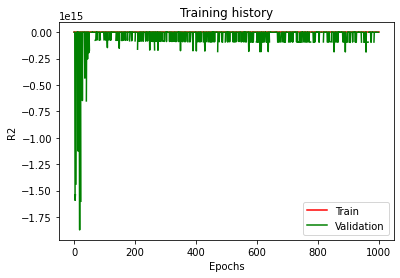

In [9]:
plt.plot( list(range(epochs)), [x[0] for x in metrics_history], color='r', label='Train')
plt.plot(list(range(epochs)), [x[0] for x in metrics_history_val], color='g', label='Validation')

plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Training history")

plt.legend()
plt.show()

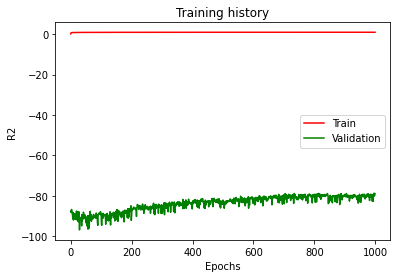

In [10]:
plt.plot( list(range(epochs)), [x[1] for x in metrics_history], color='r', label='Train')
plt.plot(list(range(epochs)), [x[1] for x in metrics_history_val], color='g', label='Validation')

plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Training history")

plt.legend()
plt.show()

In [11]:
test_AgeVae(vae, test, device, age_weight = 1)

Loss 628.67822265625 | Age r2: 0.3743630647659302 | Age loss: 0.1442776918411255 |Age reg: 0.01965200901031494 | MSE loss: 623.3871459960938 | R2: 0.9104659557342529 | KLD loss: 51.27140808105469


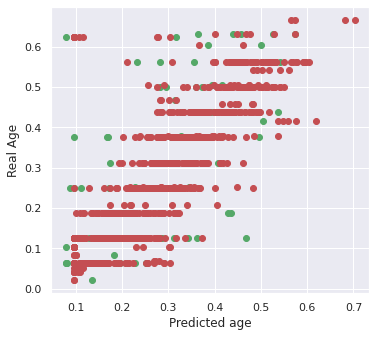

In [40]:
x, age = test[:, :-1], test[:, -1]
_, _, age_pred = vae(x.to(device))
plt.scatter(age_pred.cpu().detach(), age, color='g', label='Test')

x, age = train[:, :-1], train[:, -1]
_, _, age_pred = vae(x.to(device))
plt.scatter(age_pred.cpu().detach(), age, color='r', label='Train')

plt.xlabel("Predicted age")
plt.ylabel("Real Age")

plt.show()

In [12]:
data_test_brain = data.fillna(0)[data['Species'] == "Human"]
data_test_brain = torch.Tensor(data_test_brain.select_dtypes(include=['float64']).iloc[:, :-1].values).to(device)
test_AgeVae(vae, data_test_brain, device, age_weight = 1)

Loss 14137.1923828125 | Age r2: -0.5015863180160522 | Age loss: 0.26533225178718567 |Age reg: 0.01965200901031494 | MSE loss: 14132.05078125 | R2: -2.577786445617676 | KLD loss: 48.56293487548828


In [13]:
data_test_rat = data.fillna(0)[data['Species'] == "Rat"]
data_test_rat = torch.Tensor(data_test_rat.select_dtypes(include=['float64']).iloc[:, :-1].values).to(device)
test_AgeVae(vae, data_test_rat, device, age_weight = 1)

Loss 8877.958984375 | Age r2: -0.11274337768554688 | Age loss: 0.22170978784561157 |Age reg: 0.01965200901031494 | MSE loss: 8872.6533203125 | R2: -0.6067951917648315 | KLD loss: 50.648921966552734


In [14]:
data_test = data.fillna(0)
data_test = torch.Tensor(data_test.select_dtypes(include=['float64']).iloc[:, :-1].values).to(device)
test_AgeVae(vae, data_test, device, age_weight = 1)

Loss 6845.28759765625 | Age r2: -0.19166350364685059 | Age loss: 0.22737599909305573 |Age reg: 0.01965200901031494 | MSE loss: 6839.74365234375 | R2: 0.11268538236618042 | KLD loss: 52.96638107299805


In [19]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(torch.Tensor(datawNAN)[:, :-1].cpu().numpy())

In [20]:
d = {'t-SNE1': X_embedded[:, 0], 't-SNE2': X_embedded[:, 1], 'Age': data[data['Species'] == "Mouse"]["Age_rel_m"]}
df = pd.DataFrame(data=d)

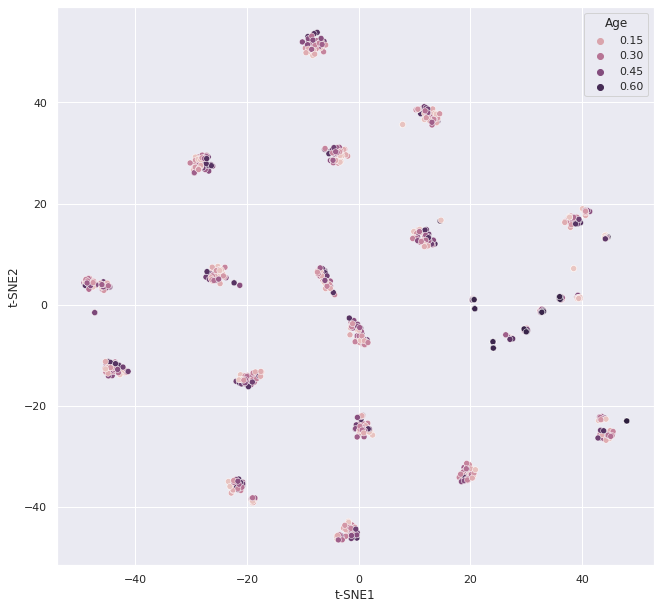

In [22]:
sns.scatterplot(data=df, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(5.7,5.27)})

In [23]:
x = vae.encode(torch.Tensor(datawNAN)[:, :-1].cuda())
x.shape

torch.Size([976, 10])

In [24]:
corr = np.concatenate([x.cpu().detach().numpy(), torch.Tensor(datawNAN)[:, -1].reshape((-1, 1)).cpu().detach().numpy()], axis = 1)
corr.shape

(976, 11)

In [25]:
corrcoef = np.corrcoef(corr, rowvar = False)
corrcoef.shape

(11, 11)

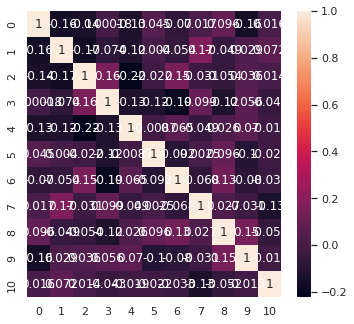

In [26]:
ax = sns.heatmap(corrcoef, annot=True)

In [27]:
vae_embedded = TSNE(n_components=2, init='random').fit_transform(x.cpu().detach().numpy())

In [28]:
d_vae = {'t-SNE1': vae_embedded[:, 0], 't-SNE2': vae_embedded[:, 1], 'Age': data[data['Species'] == "Mouse"]["Age_rel_m"]}
df_vae = pd.DataFrame(data=d_vae)

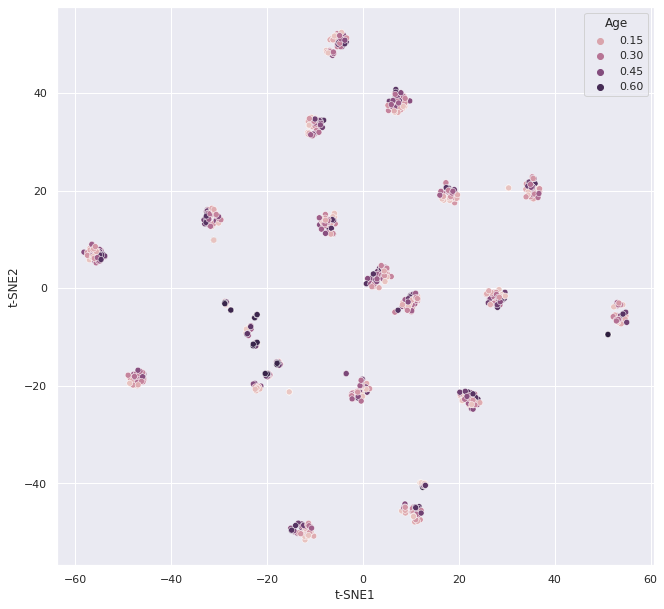

In [30]:
sns.scatterplot(data=df_vae, x="t-SNE1", y="t-SNE2", hue="Age")
sns.set(rc={'figure.figsize':(5.7,5.27)})